### Predict whether a flight will be delayed for more than 15 minutes

In [104]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from imblearn.over_sampling import SMOTENC
from catboost import CatBoostClassifier, cv, Pool
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline 
import os
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy=0.5)

In [32]:
train_df = pd.read_csv('input/flight_delays_train.csv')
test_df = pd.read_csv('input/flight_delays_test.csv')
SEED = 17

In [22]:
train_df.head()

Month DayofMonth DayOfWeek  DepTime UniqueCarrier Origin Dest  Distance  \
0   c-8       c-21       c-7     1934            AA    ATL  DFW       732   
1   c-4       c-20       c-3     1548            US    PIT  MCO       834   
2   c-9        c-2       c-5     1422            XE    RDU  CLE       416   
3  c-11       c-25       c-6     1015            OO    DEN  MEM       872   
4  c-10        c-7       c-6     1828            WN    MDW  OMA       423   

  dep_delayed_15min  
0                 N  
1                 N  
2                 N  
3                 N  
4                 Y

In [23]:
train_df.drop('dep_delayed_15min', axis=1)

Month DayofMonth DayOfWeek  DepTime UniqueCarrier Origin Dest  Distance
0       c-8       c-21       c-7     1934            AA    ATL  DFW       732
1       c-4       c-20       c-3     1548            US    PIT  MCO       834
2       c-9        c-2       c-5     1422            XE    RDU  CLE       416
3      c-11       c-25       c-6     1015            OO    DEN  MEM       872
4      c-10        c-7       c-6     1828            WN    MDW  OMA       423
...     ...        ...       ...      ...           ...    ...  ...       ...
99995   c-5        c-4       c-3     1618            OO    SFO  RDD       199
99996   c-1       c-18       c-3      804            CO    EWR  DAB       884
99997   c-1       c-24       c-2     1901            NW    DTW  IAH      1076
99998   c-4       c-27       c-4     1515            MQ    DFW  GGG       140
99999  c-11       c-17       c-4     1800            WN    SEA  SMF       605

[100000 rows x 8 columns]

In [114]:
def model_to_submission(train_df,test_df,non_cat_features, SEED, name='', under=False, over=False, grid='else', iterations = 600):
    X = train_df.drop('dep_delayed_15min', axis=1)
    y = train_df['dep_delayed_15min']
    cat_features = [x for x in range(len(X.columns)) if X.columns[x] not in non_cat_features ]
    
    #oversampling part1
    if over:
        # OnehotEncoding on our categorical features
        ohe = OneHotEncoder()
        ohe.fit(X[cat_features ])
        X_cat = ohe.transform(X[cat_features])
        #Concatenate our ohe features and numerical 
        X = hstack([X_cat, X_train[non_cat_features]])
        cat_features = [x for x in range(X_cat.shape[1])]
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=SEED,stratify=y)
    
    #oversampling part2
    if over:
        # Makes new rows with SMORENC
        sm = SMOTENC(random_state=SEED, categorical_features = cat_features)
        X_train, y_train = sm.fit_resample(X_train, y_train)
    
    #undersampling
    
    if under:
        X_train, y_train = undersample.fit_resample(X_train, y_train)
     
    
    #Catboost
    cat = CatBoostClassifier(random_seed=SEED, iterations=iterations, depth = 10, l2_leaf_reg = 5)
    
    # perfoming GridSearch for model complexity
    if (grid == 'complexity'):
        grid = {'depth': [4, 6, 10],
            'l2_leaf_reg': [1, 3, 5, 7, 9]}
        cv = StratifiedKFold(n_splits=3,random_state=SEED)
        grid = GridSearchCV(cat, param_grid = grid, 
                                scoring = 'roc_auc', cv = cv
                                )
        cat = grid.fit(X,y,cat_features=cat_features)
        
    # perfoming GridSearch for convergence
    elif (grid == 'convergence'):
        grid = {'iterations':[250,100,500,1000]}
        cv = StratifiedKFold(n_splits=3,random_state=SEED)
        grid = GridSearchCV(cat, param_grid = grid, 
                                scoring = 'roc_auc', cv = cv
                                )
        cat = grid.fit(X,y,cat_features=cat_features)
    else:
        cat.fit(X_train,y_train, eval_set=(X_valid,y_valid),
            cat_features=cat_features, use_best_model=True,
            verbose=True, plot=True)
    
    #Save predictions 
    predictions = cat.predict_proba(test_df)[:, 1]
    submission = pd.DataFrame({'id':range(100000),'dep_delayed_15min':predictions})
    filename = 'Flight_delay_predictions_{}.csv'.format(name)
    path =os.path.join('submissions',filename)
    
    submission.to_csv(path,index=False)
    print('Saved file: ' + filename)
    return cat

In [28]:
train_df.columns
non_cat_features=['Distance','dep_delayed_15min']

In [29]:
cat = model_to_submission(train_df,test_df,non_cat_features,SEED, name='default')

TypeError: model_to_submission() missing 1 required positional argument: 'SEED'

In [ ]:
#roc-auc test_df 0.71041

In [30]:
## Here I collect all feature engineering

#Clean month, day of month and day of week
def feature_eng(df):
    df['Month'] = df['Month'].str[2:].astype('int')
    df['DayofMonth'] = df['DayofMonth'].str[2:].astype('int')
    df['DayOfWeek'] = df['DayOfWeek'].str[2:].astype('int')

    #Feature extraction
    df['weekend'] = [1 if ((day == 7) or (day== 6)) else 0 for day in df['DayOfWeek'] ]

    df['DayPart'] = ['morning' if (6<=np.floor(time/100)) and (np.floor(time/100) < 11) \
                           else 'noon' if (11<= np.floor(time/100)) and (np.floor(time/100) <17) \
                           else 'evening' if (17<= np.floor(time/100)) and (np.floor(time/100) <23)\
                           else 'night' for time in df['DepTime']]

    df['Seasons'] = df['Month'].map(lambda x:
                                                'winter' if x in (11,12,1) else
                                                'spring' if x in (2,3,4) else
                                                'summer' if x in (5,6,7) else
                                                'fall'                        
                                                )
    #посмотри всё ли правльно ты сделал с семестрами
    df['Semester'] = df['Month'].map(lambda x:
                                                 '1semester' if x in range(1,7) else
                                                 '2semseter')
    df['DepHour'] = df['DepTime'].map(lambda x: (x // 100) % 24)
    df.drop(['DepHour'], axis= 1)

    #Feature combining 
    df['Path'] = df['Origin'] + '-->' + df['Dest']

    #Feature transformation

    df['logDistance'] = np.log(df['Distance'])
    df['DepHour_sin'] = np.sin(2*np.pi*df['DepHour']/24)
    df['DepHour_cos'] = np.cos(2*np.pi*df['DepHour']/24)
    # this one has to be changed
    # здесь можно посмотреть, как можно разбивать 
    df['RangeDistance'] = df['logDistance'].map(lambda x:
                                                'small' if x <=5.6 else
                                                'mid' if 5.6<x and x<7 else
                                                'long'                    
                                                )
    return df

In [33]:
train_df = feature_eng(train_df)
non_cat_features=['Distance','logDistance','DepHour_sin','DepHour_cos',]
test_df = feature_eng(test_df)

In [ ]:
cat = model_to_submission(train_df,test_df, non_cat_features, SEED, name='tryall')

In [ ]:
#roc-auc test_df 0.73870

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DC67C6EA48>]],
      dtype=object)

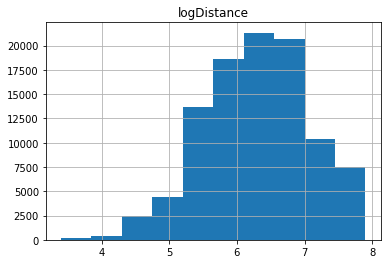

In [15]:
train_df.hist('logDistance')

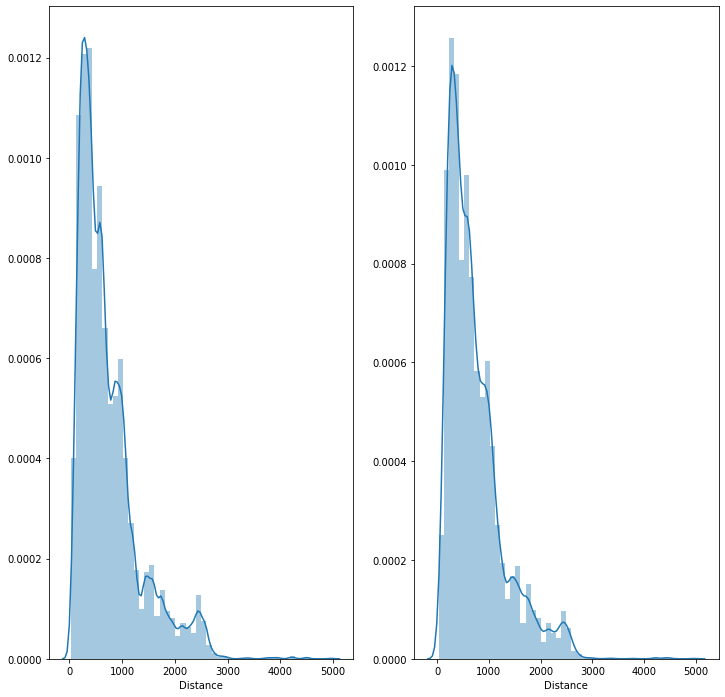

In [9]:
# нужн посмотреть как распределение зависи от класса 
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
sns.distplot(train_df[train_df['dep_delayed_15min'] == 'N']['Distance'])
plt.subplot(1,2,2)
sns.distplot(train_df[train_df['dep_delayed_15min'] == 'Y']['Distance'])

In [10]:
print('The number of outliers = ',np.sum(train_df['Distance']>2700))

The number of outliers =  384


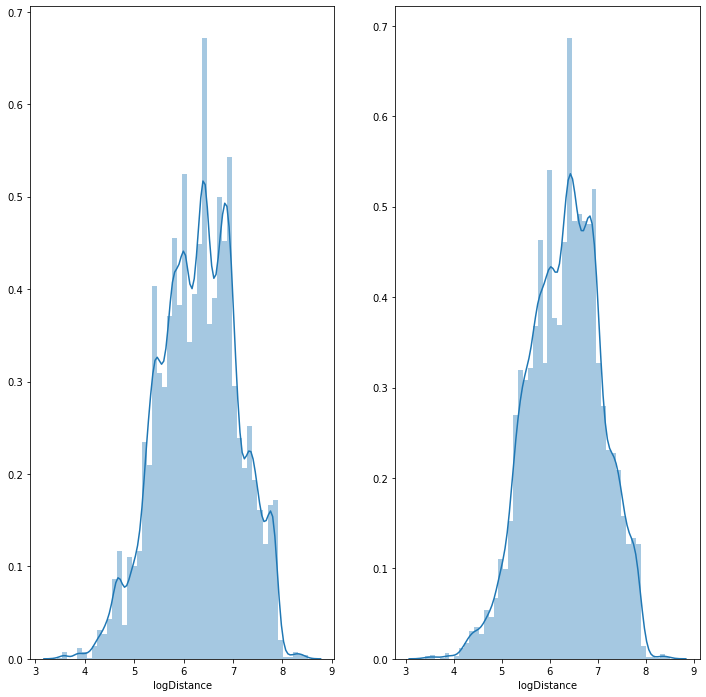

In [11]:
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
sns.distplot(train_df[train_df['dep_delayed_15min'] == 'N']['logDistance'])
plt.subplot(1,2,2)
sns.distplot(train_df[train_df['dep_delayed_15min'] == 'Y']['logDistance'])

In [12]:
# As we can wee the distributions of of our clases are almost the same
# So we can delete outliers from both classes by distance feature more than 3000

train_df = train_df[train_df['Distance'] <2700]

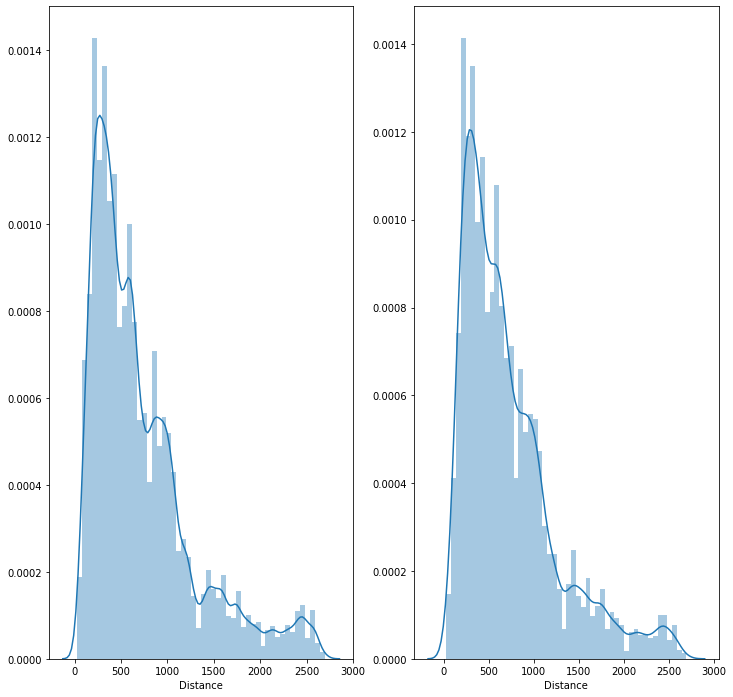

In [13]:
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
sns.distplot(train_df[train_df['dep_delayed_15min'] == 'N']['Distance'])
plt.subplot(1,2,2)
sns.distplot(train_df[train_df['dep_delayed_15min'] == 'Y']['Distance'])

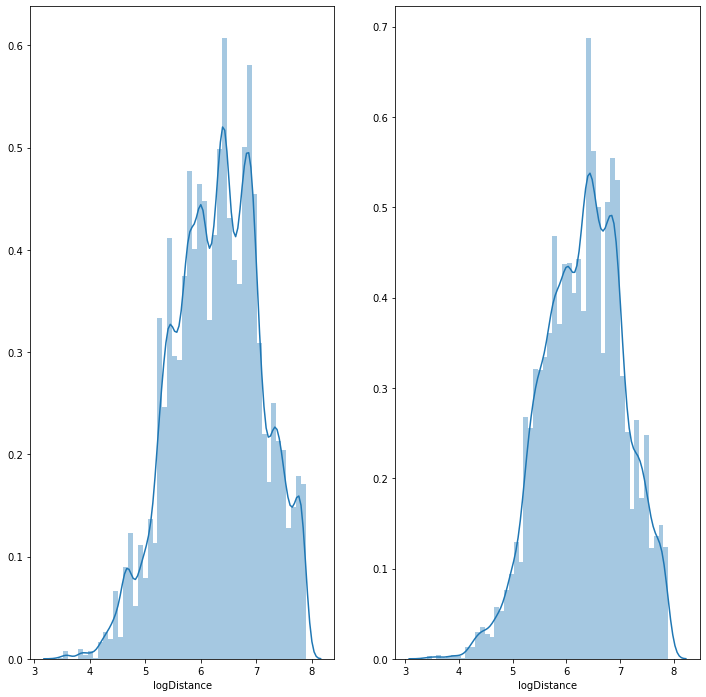

In [14]:
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
sns.distplot(train_df[train_df['dep_delayed_15min'] == 'N']['logDistance'])
plt.subplot(1,2,2)
sns.distplot(train_df[train_df['dep_delayed_15min'] == 'Y']['logDistance'])

In [17]:
# Check if it made the model better 

In [18]:
test_features(train_df,test_df, non_cat_features, SEED, name='tryall_v_2')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.116698
0:	learn: 0.6325073	test: 0.6328146	best: 0.6328146 (0)	total: 244ms	remaining: 2m 26s
1:	learn: 0.5889737	test: 0.5892029	best: 0.5892029 (1)	total: 573ms	remaining: 2m 51s
2:	learn: 0.5539367	test: 0.5539926	best: 0.5539926 (2)	total: 828ms	remaining: 2m 44s
3:	learn: 0.5268769	test: 0.5270627	best: 0.5270627 (3)	total: 1.08s	remaining: 2m 40s
4:	learn: 0.5078999	test: 0.5082872	best: 0.5082872 (4)	total: 1.35s	remaining: 2m 40s
5:	learn: 0.4935506	test: 0.4940838	best: 0.4940838 (5)	total: 1.59s	remaining: 2m 37s
6:	learn: 0.4812074	test: 0.4817898	best: 0.4817898 (6)	total: 1.91s	remaining: 2m 41s
7:	learn: 0.4721766	test: 0.4727156	best: 0.4727156 (7)	total: 2.21s	remaining: 2m 43s
8:	learn: 0.4657182	test: 0.4665490	best: 0.4665490 (8)	total: 2.51s	remaining: 2m 44s
9:	learn: 0.4603147	test: 0.4611365	best: 0.4611365 (9)	total: 2.8s	remaining: 2m 45s
10:	learn: 0.4552487	test: 0.4561241	best: 0.4561241 (10)	total: 3.07s	remaining: 2m 44s
11:	learn: 0

93:	learn: 0.3968616	test: 0.4053013	best: 0.4053013 (93)	total: 35.6s	remaining: 3m 11s
94:	learn: 0.3966583	test: 0.4052310	best: 0.4052310 (94)	total: 35.9s	remaining: 3m 10s
95:	learn: 0.3965231	test: 0.4051184	best: 0.4051184 (95)	total: 36.3s	remaining: 3m 10s
96:	learn: 0.3963142	test: 0.4050169	best: 0.4050169 (96)	total: 36.8s	remaining: 3m 10s
97:	learn: 0.3961080	test: 0.4049565	best: 0.4049565 (97)	total: 37.3s	remaining: 3m 11s
98:	learn: 0.3958577	test: 0.4047724	best: 0.4047724 (98)	total: 37.9s	remaining: 3m 11s
99:	learn: 0.3955832	test: 0.4047151	best: 0.4047151 (99)	total: 38.3s	remaining: 3m 11s
100:	learn: 0.3953972	test: 0.4045198	best: 0.4045198 (100)	total: 38.7s	remaining: 3m 11s
101:	learn: 0.3952413	test: 0.4043978	best: 0.4043978 (101)	total: 39.1s	remaining: 3m 10s
102:	learn: 0.3951131	test: 0.4042556	best: 0.4042556 (102)	total: 40.1s	remaining: 3m 13s
103:	learn: 0.3949775	test: 0.4038319	best: 0.4038319 (103)	total: 40.9s	remaining: 3m 15s
104:	learn: 0

184:	learn: 0.3851224	test: 0.3988095	best: 0.3987131 (183)	total: 1m 16s	remaining: 2m 52s
185:	learn: 0.3850313	test: 0.3988890	best: 0.3987131 (183)	total: 1m 17s	remaining: 2m 51s
186:	learn: 0.3849218	test: 0.3988130	best: 0.3987131 (183)	total: 1m 17s	remaining: 2m 51s
187:	learn: 0.3847928	test: 0.3988440	best: 0.3987131 (183)	total: 1m 17s	remaining: 2m 50s
188:	learn: 0.3847257	test: 0.3988732	best: 0.3987131 (183)	total: 1m 18s	remaining: 2m 50s
189:	learn: 0.3847024	test: 0.3988809	best: 0.3987131 (183)	total: 1m 18s	remaining: 2m 49s
190:	learn: 0.3846524	test: 0.3988643	best: 0.3987131 (183)	total: 1m 18s	remaining: 2m 48s
191:	learn: 0.3845798	test: 0.3988285	best: 0.3987131 (183)	total: 1m 19s	remaining: 2m 48s
192:	learn: 0.3845395	test: 0.3988145	best: 0.3987131 (183)	total: 1m 19s	remaining: 2m 47s
193:	learn: 0.3844524	test: 0.3987350	best: 0.3987131 (183)	total: 1m 19s	remaining: 2m 47s
194:	learn: 0.3843603	test: 0.3987004	best: 0.3987004 (194)	total: 1m 20s	remain

274:	learn: 0.3784857	test: 0.3961476	best: 0.3961476 (274)	total: 1m 46s	remaining: 2m 5s
275:	learn: 0.3784304	test: 0.3961032	best: 0.3961032 (275)	total: 1m 46s	remaining: 2m 5s
276:	learn: 0.3783780	test: 0.3960568	best: 0.3960568 (276)	total: 1m 46s	remaining: 2m 4s
277:	learn: 0.3782635	test: 0.3960301	best: 0.3960301 (277)	total: 1m 47s	remaining: 2m 4s
278:	learn: 0.3781789	test: 0.3958993	best: 0.3958993 (278)	total: 1m 47s	remaining: 2m 3s
279:	learn: 0.3780996	test: 0.3959351	best: 0.3958993 (278)	total: 1m 47s	remaining: 2m 3s
280:	learn: 0.3780152	test: 0.3959698	best: 0.3958993 (278)	total: 1m 48s	remaining: 2m 2s
281:	learn: 0.3779909	test: 0.3959807	best: 0.3958993 (278)	total: 1m 48s	remaining: 2m 2s
282:	learn: 0.3779066	test: 0.3959786	best: 0.3958993 (278)	total: 1m 48s	remaining: 2m 1s
283:	learn: 0.3778302	test: 0.3959504	best: 0.3958993 (278)	total: 1m 48s	remaining: 2m 1s
284:	learn: 0.3777962	test: 0.3959389	best: 0.3958993 (278)	total: 1m 49s	remaining: 2m
28

364:	learn: 0.3729594	test: 0.3957047	best: 0.3955425 (360)	total: 2m 14s	remaining: 1m 26s
365:	learn: 0.3729176	test: 0.3957064	best: 0.3955425 (360)	total: 2m 15s	remaining: 1m 26s
366:	learn: 0.3728768	test: 0.3956582	best: 0.3955425 (360)	total: 2m 15s	remaining: 1m 25s
367:	learn: 0.3728151	test: 0.3956433	best: 0.3955425 (360)	total: 2m 15s	remaining: 1m 25s
368:	learn: 0.3727490	test: 0.3956464	best: 0.3955425 (360)	total: 2m 16s	remaining: 1m 25s
369:	learn: 0.3726964	test: 0.3956532	best: 0.3955425 (360)	total: 2m 16s	remaining: 1m 24s
370:	learn: 0.3726372	test: 0.3956611	best: 0.3955425 (360)	total: 2m 16s	remaining: 1m 24s
371:	learn: 0.3726304	test: 0.3956715	best: 0.3955425 (360)	total: 2m 17s	remaining: 1m 24s
372:	learn: 0.3725763	test: 0.3956890	best: 0.3955425 (360)	total: 2m 17s	remaining: 1m 23s
373:	learn: 0.3725556	test: 0.3956790	best: 0.3955425 (360)	total: 2m 17s	remaining: 1m 23s
374:	learn: 0.3725108	test: 0.3956633	best: 0.3955425 (360)	total: 2m 18s	remain

454:	learn: 0.3677907	test: 0.3960313	best: 0.3955425 (360)	total: 2m 44s	remaining: 52.4s
455:	learn: 0.3676636	test: 0.3960296	best: 0.3955425 (360)	total: 2m 44s	remaining: 52s
456:	learn: 0.3676018	test: 0.3960592	best: 0.3955425 (360)	total: 2m 45s	remaining: 51.7s
457:	learn: 0.3675207	test: 0.3960992	best: 0.3955425 (360)	total: 2m 45s	remaining: 51.3s
458:	learn: 0.3674576	test: 0.3961237	best: 0.3955425 (360)	total: 2m 45s	remaining: 51s
459:	learn: 0.3673570	test: 0.3961478	best: 0.3955425 (360)	total: 2m 46s	remaining: 50.6s
460:	learn: 0.3673244	test: 0.3961924	best: 0.3955425 (360)	total: 2m 46s	remaining: 50.2s
461:	learn: 0.3672201	test: 0.3961852	best: 0.3955425 (360)	total: 2m 46s	remaining: 49.8s
462:	learn: 0.3671346	test: 0.3961960	best: 0.3955425 (360)	total: 2m 47s	remaining: 49.5s
463:	learn: 0.3670887	test: 0.3962034	best: 0.3955425 (360)	total: 2m 47s	remaining: 49.1s
464:	learn: 0.3670294	test: 0.3962023	best: 0.3955425 (360)	total: 2m 47s	remaining: 48.8s
465

545:	learn: 0.3630804	test: 0.3962603	best: 0.3955425 (360)	total: 3m 17s	remaining: 19.5s
546:	learn: 0.3630055	test: 0.3962447	best: 0.3955425 (360)	total: 3m 17s	remaining: 19.2s
547:	learn: 0.3629571	test: 0.3962199	best: 0.3955425 (360)	total: 3m 18s	remaining: 18.8s
548:	learn: 0.3628951	test: 0.3962153	best: 0.3955425 (360)	total: 3m 18s	remaining: 18.4s
549:	learn: 0.3628736	test: 0.3962486	best: 0.3955425 (360)	total: 3m 18s	remaining: 18.1s
550:	learn: 0.3628409	test: 0.3962334	best: 0.3955425 (360)	total: 3m 19s	remaining: 17.7s
551:	learn: 0.3627648	test: 0.3962298	best: 0.3955425 (360)	total: 3m 19s	remaining: 17.3s
552:	learn: 0.3626716	test: 0.3962396	best: 0.3955425 (360)	total: 3m 19s	remaining: 17s
553:	learn: 0.3625761	test: 0.3962576	best: 0.3955425 (360)	total: 3m 20s	remaining: 16.6s
554:	learn: 0.3625245	test: 0.3962246	best: 0.3955425 (360)	total: 3m 20s	remaining: 16.3s
555:	learn: 0.3624325	test: 0.3961629	best: 0.3955425 (360)	total: 3m 20s	remaining: 15.9s
5

In [19]:
# without roc-auc test_df 0.73822
# with outliers roc-auc test_df #roc-auc test_df 0.73870

In [34]:
cat = model_to_submission(train_df,test_df, non_cat_features, SEED, name='tryall')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.116809
0:	learn: 0.6329362	test: 0.6313379	best: 0.6313379 (0)	total: 350ms	remaining: 3m 29s
1:	learn: 0.5869746	test: 0.5851701	best: 0.5851701 (1)	total: 724ms	remaining: 3m 36s
2:	learn: 0.5523018	test: 0.5502107	best: 0.5502107 (2)	total: 969ms	remaining: 3m 12s
3:	learn: 0.5264054	test: 0.5237055	best: 0.5237055 (3)	total: 1.28s	remaining: 3m 11s
4:	learn: 0.5087212	test: 0.5055082	best: 0.5055082 (4)	total: 1.45s	remaining: 2m 52s
5:	learn: 0.4950672	test: 0.4916757	best: 0.4916757 (5)	total: 1.6s	remaining: 2m 38s
6:	learn: 0.4843655	test: 0.4807934	best: 0.4807934 (6)	total: 1.95s	remaining: 2m 44s
7:	learn: 0.4748853	test: 0.4704912	best: 0.4704912 (7)	total: 2.23s	remaining: 2m 45s
8:	learn: 0.4697450	test: 0.4654146	best: 0.4654146 (8)	total: 2.36s	remaining: 2m 34s
9:	learn: 0.4628722	test: 0.4577228	best: 0.4577228 (9)	total: 2.75s	remaining: 2m 42s
10:	learn: 0.4582075	test: 0.4527212	best: 0.4527212 (10)	total: 3.13s	remaining: 2m 47s
11:	learn: 0

93:	learn: 0.3981322	test: 0.3962744	best: 0.3962744 (93)	total: 41.5s	remaining: 3m 43s
94:	learn: 0.3980240	test: 0.3962644	best: 0.3962644 (94)	total: 41.8s	remaining: 3m 42s
95:	learn: 0.3978848	test: 0.3956925	best: 0.3956925 (95)	total: 42.2s	remaining: 3m 41s
96:	learn: 0.3977847	test: 0.3956409	best: 0.3956409 (96)	total: 42.6s	remaining: 3m 40s
97:	learn: 0.3976943	test: 0.3956132	best: 0.3956132 (97)	total: 43s	remaining: 3m 40s
98:	learn: 0.3975568	test: 0.3955377	best: 0.3955377 (98)	total: 43.3s	remaining: 3m 39s
99:	learn: 0.3974490	test: 0.3954624	best: 0.3954624 (99)	total: 43.7s	remaining: 3m 38s
100:	learn: 0.3973208	test: 0.3954219	best: 0.3954219 (100)	total: 44.2s	remaining: 3m 38s
101:	learn: 0.3972126	test: 0.3953998	best: 0.3953998 (101)	total: 44.6s	remaining: 3m 37s
102:	learn: 0.3970490	test: 0.3952752	best: 0.3952752 (102)	total: 45.1s	remaining: 3m 37s
103:	learn: 0.3968824	test: 0.3951372	best: 0.3951372 (103)	total: 45.4s	remaining: 3m 36s
104:	learn: 0.3

184:	learn: 0.3876528	test: 0.3910468	best: 0.3910468 (184)	total: 1m 21s	remaining: 3m 3s
185:	learn: 0.3874510	test: 0.3910096	best: 0.3910096 (185)	total: 1m 22s	remaining: 3m 2s
186:	learn: 0.3873478	test: 0.3909702	best: 0.3909702 (186)	total: 1m 22s	remaining: 3m 2s
187:	learn: 0.3873173	test: 0.3909214	best: 0.3909214 (187)	total: 1m 22s	remaining: 3m 1s
188:	learn: 0.3872524	test: 0.3909132	best: 0.3909132 (188)	total: 1m 23s	remaining: 3m
189:	learn: 0.3872281	test: 0.3909008	best: 0.3909008 (189)	total: 1m 23s	remaining: 3m
190:	learn: 0.3871288	test: 0.3909065	best: 0.3909008 (189)	total: 1m 23s	remaining: 2m 59s
191:	learn: 0.3870126	test: 0.3909605	best: 0.3909008 (189)	total: 1m 24s	remaining: 2m 59s
192:	learn: 0.3869726	test: 0.3909505	best: 0.3909008 (189)	total: 1m 24s	remaining: 2m 58s
193:	learn: 0.3868393	test: 0.3909564	best: 0.3909008 (189)	total: 1m 25s	remaining: 2m 58s
194:	learn: 0.3868001	test: 0.3909934	best: 0.3909008 (189)	total: 1m 25s	remaining: 2m 57s


274:	learn: 0.3812259	test: 0.3901338	best: 0.3900828 (260)	total: 2m 2s	remaining: 2m 25s
275:	learn: 0.3811568	test: 0.3900335	best: 0.3900335 (275)	total: 2m 3s	remaining: 2m 24s
276:	learn: 0.3810786	test: 0.3900128	best: 0.3900128 (276)	total: 2m 3s	remaining: 2m 24s
277:	learn: 0.3810601	test: 0.3900168	best: 0.3900128 (276)	total: 2m 3s	remaining: 2m 23s
278:	learn: 0.3810117	test: 0.3900040	best: 0.3900040 (278)	total: 2m 4s	remaining: 2m 22s
279:	learn: 0.3809880	test: 0.3899926	best: 0.3899926 (279)	total: 2m 4s	remaining: 2m 22s
280:	learn: 0.3809403	test: 0.3900046	best: 0.3899926 (279)	total: 2m 5s	remaining: 2m 22s
281:	learn: 0.3808881	test: 0.3900160	best: 0.3899926 (279)	total: 2m 5s	remaining: 2m 21s
282:	learn: 0.3808098	test: 0.3899858	best: 0.3899858 (282)	total: 2m 6s	remaining: 2m 21s
283:	learn: 0.3807282	test: 0.3899920	best: 0.3899858 (282)	total: 2m 6s	remaining: 2m 20s
284:	learn: 0.3806557	test: 0.3900460	best: 0.3899858 (282)	total: 2m 6s	remaining: 2m 20s

364:	learn: 0.3761290	test: 0.3898102	best: 0.3895498 (340)	total: 2m 36s	remaining: 1m 40s
365:	learn: 0.3760567	test: 0.3897940	best: 0.3895498 (340)	total: 2m 36s	remaining: 1m 40s
366:	learn: 0.3759979	test: 0.3897426	best: 0.3895498 (340)	total: 2m 37s	remaining: 1m 39s
367:	learn: 0.3759667	test: 0.3897525	best: 0.3895498 (340)	total: 2m 37s	remaining: 1m 39s
368:	learn: 0.3759108	test: 0.3897558	best: 0.3895498 (340)	total: 2m 37s	remaining: 1m 38s
369:	learn: 0.3758603	test: 0.3897917	best: 0.3895498 (340)	total: 2m 38s	remaining: 1m 38s
370:	learn: 0.3757963	test: 0.3898053	best: 0.3895498 (340)	total: 2m 38s	remaining: 1m 37s
371:	learn: 0.3757468	test: 0.3898150	best: 0.3895498 (340)	total: 2m 38s	remaining: 1m 37s
372:	learn: 0.3757262	test: 0.3898220	best: 0.3895498 (340)	total: 2m 38s	remaining: 1m 36s
373:	learn: 0.3756521	test: 0.3897634	best: 0.3895498 (340)	total: 2m 39s	remaining: 1m 36s
374:	learn: 0.3755822	test: 0.3897582	best: 0.3895498 (340)	total: 2m 39s	remain

454:	learn: 0.3709150	test: 0.3891191	best: 0.3891099 (452)	total: 3m 16s	remaining: 1m 2s
455:	learn: 0.3708520	test: 0.3891437	best: 0.3891099 (452)	total: 3m 17s	remaining: 1m 2s
456:	learn: 0.3708369	test: 0.3891431	best: 0.3891099 (452)	total: 3m 17s	remaining: 1m 1s
457:	learn: 0.3707705	test: 0.3891180	best: 0.3891099 (452)	total: 3m 18s	remaining: 1m 1s
458:	learn: 0.3707437	test: 0.3891013	best: 0.3891013 (458)	total: 3m 19s	remaining: 1m 1s
459:	learn: 0.3706775	test: 0.3891227	best: 0.3891013 (458)	total: 3m 20s	remaining: 1m
460:	learn: 0.3706410	test: 0.3891367	best: 0.3891013 (458)	total: 3m 20s	remaining: 1m
461:	learn: 0.3705871	test: 0.3891225	best: 0.3891013 (458)	total: 3m 21s	remaining: 1m
462:	learn: 0.3705532	test: 0.3891396	best: 0.3891013 (458)	total: 3m 21s	remaining: 59.7s
463:	learn: 0.3705112	test: 0.3891346	best: 0.3891013 (458)	total: 3m 22s	remaining: 59.3s
464:	learn: 0.3704676	test: 0.3891336	best: 0.3891013 (458)	total: 3m 23s	remaining: 58.9s
465:	lea

545:	learn: 0.3659102	test: 0.3886814	best: 0.3886814 (545)	total: 3m 52s	remaining: 23s
546:	learn: 0.3658951	test: 0.3886949	best: 0.3886814 (545)	total: 3m 52s	remaining: 22.5s
547:	learn: 0.3658719	test: 0.3887068	best: 0.3886814 (545)	total: 3m 52s	remaining: 22.1s
548:	learn: 0.3658648	test: 0.3886894	best: 0.3886814 (545)	total: 3m 53s	remaining: 21.7s
549:	learn: 0.3658340	test: 0.3886988	best: 0.3886814 (545)	total: 3m 53s	remaining: 21.2s
550:	learn: 0.3657599	test: 0.3886753	best: 0.3886753 (550)	total: 3m 53s	remaining: 20.8s
551:	learn: 0.3657270	test: 0.3886572	best: 0.3886572 (551)	total: 3m 54s	remaining: 20.4s
552:	learn: 0.3656910	test: 0.3886567	best: 0.3886567 (552)	total: 3m 54s	remaining: 19.9s
553:	learn: 0.3655960	test: 0.3887319	best: 0.3886567 (552)	total: 3m 55s	remaining: 19.5s
554:	learn: 0.3655203	test: 0.3887525	best: 0.3886567 (552)	total: 3m 55s	remaining: 19.1s
555:	learn: 0.3654926	test: 0.3887516	best: 0.3886567 (552)	total: 3m 55s	remaining: 18.7s
5

In [62]:
def feature_importance(model):
    scores = model.feature_importances_
    indecies = [int(c) for c in range(len(model.feature_names_))]
    ser = pd.Series(dict(zip(indecies, scores)))
    ser.sort_values(inplace=True)
    return ser

In [63]:
def plot_feature_importance(model, colnames):
    plt.figure(figsize=(12, 10))
    
    importance = feature_importance(model)
    importance.index = [colnames[i] for i in importance.index]
    importance.plot.barh()

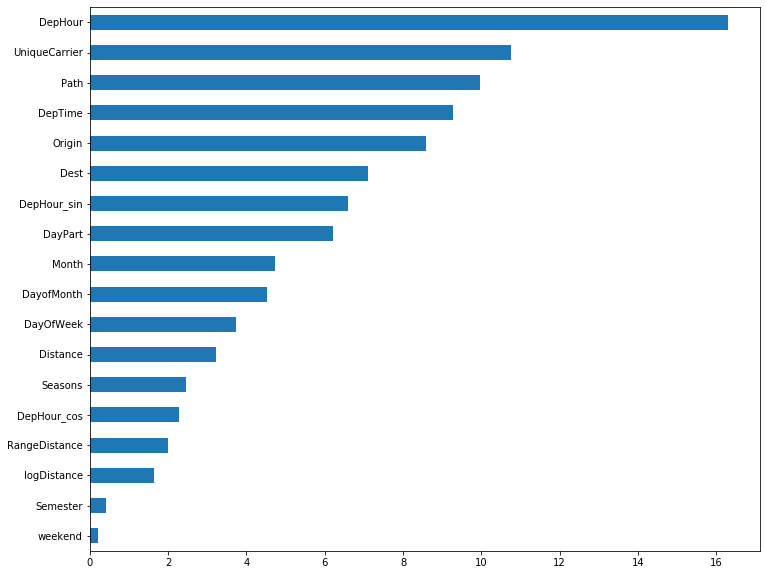

In [64]:
plot_feature_importance(cat, cat.feature_names_)

In [86]:
#Let's delete Semester and weekend and see what happen
maybe_useless = ['weekend', 'Semester']
train_df_without_v1 = train_df.drop(columns= maybe_useless)
test_df_without_v1 = test_df.drop(columns=maybe_useless)

In [82]:
train_df_without_v1.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
       'Origin', 'Dest', 'Distance', 'dep_delayed_15min', 'DayPart', 'Seasons',
       'DepHour', 'Path', 'logDistance', 'DepHour_sin', 'DepHour_cos',
       'RangeDistance'],
      dtype='object')

In [87]:
test_features(train_df_without_v1,test_df_without_v1, non_cat_features, SEED, name='without_maybe_useless')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.116809
0:	learn: 0.6343652	test: 0.6344021	best: 0.6344021 (0)	total: 307ms	remaining: 3m 3s
1:	learn: 0.5867718	test: 0.5856824	best: 0.5856824 (1)	total: 609ms	remaining: 3m 2s
2:	learn: 0.5525722	test: 0.5508575	best: 0.5508575 (2)	total: 908ms	remaining: 3m
3:	learn: 0.5274311	test: 0.5249747	best: 0.5249747 (3)	total: 1.13s	remaining: 2m 48s
4:	learn: 0.5080742	test: 0.5050732	best: 0.5050732 (4)	total: 1.43s	remaining: 2m 49s
5:	learn: 0.4928501	test: 0.4895351	best: 0.4895351 (5)	total: 1.65s	remaining: 2m 42s
6:	learn: 0.4822016	test: 0.4785693	best: 0.4785693 (6)	total: 1.87s	remaining: 2m 38s
7:	learn: 0.4731184	test: 0.4688049	best: 0.4688049 (7)	total: 2.19s	remaining: 2m 41s
8:	learn: 0.4660629	test: 0.4615993	best: 0.4615993 (8)	total: 2.56s	remaining: 2m 47s
9:	learn: 0.4601414	test: 0.4552434	best: 0.4552434 (9)	total: 2.83s	remaining: 2m 46s
10:	learn: 0.4575325	test: 0.4526837	best: 0.4526837 (10)	total: 2.86s	remaining: 2m 33s
11:	learn: 0.4537

93:	learn: 0.3985899	test: 0.3962611	best: 0.3962367 (92)	total: 32.6s	remaining: 2m 55s
94:	learn: 0.3983663	test: 0.3960286	best: 0.3960286 (94)	total: 32.8s	remaining: 2m 54s
95:	learn: 0.3982530	test: 0.3958134	best: 0.3958134 (95)	total: 33.3s	remaining: 2m 54s
96:	learn: 0.3980493	test: 0.3956124	best: 0.3956124 (96)	total: 33.7s	remaining: 2m 54s
97:	learn: 0.3979407	test: 0.3955642	best: 0.3955642 (97)	total: 34s	remaining: 2m 54s
98:	learn: 0.3978882	test: 0.3955482	best: 0.3955482 (98)	total: 34.5s	remaining: 2m 54s
99:	learn: 0.3976836	test: 0.3954677	best: 0.3954677 (99)	total: 34.8s	remaining: 2m 54s
100:	learn: 0.3975464	test: 0.3952518	best: 0.3952518 (100)	total: 35.2s	remaining: 2m 53s
101:	learn: 0.3973689	test: 0.3952178	best: 0.3952178 (101)	total: 35.4s	remaining: 2m 52s
102:	learn: 0.3972680	test: 0.3951314	best: 0.3951314 (102)	total: 35.7s	remaining: 2m 52s
103:	learn: 0.3970582	test: 0.3950392	best: 0.3950392 (103)	total: 36s	remaining: 2m 51s
104:	learn: 0.396

184:	learn: 0.3884691	test: 0.3908914	best: 0.3908914 (184)	total: 1m 2s	remaining: 2m 21s
185:	learn: 0.3884077	test: 0.3908809	best: 0.3908809 (185)	total: 1m 3s	remaining: 2m 20s
186:	learn: 0.3883310	test: 0.3908926	best: 0.3908809 (185)	total: 1m 3s	remaining: 2m 20s
187:	learn: 0.3882054	test: 0.3907181	best: 0.3907181 (187)	total: 1m 3s	remaining: 2m 19s
188:	learn: 0.3880908	test: 0.3906866	best: 0.3906866 (188)	total: 1m 4s	remaining: 2m 19s
189:	learn: 0.3880172	test: 0.3906893	best: 0.3906866 (188)	total: 1m 4s	remaining: 2m 19s
190:	learn: 0.3879295	test: 0.3906926	best: 0.3906866 (188)	total: 1m 4s	remaining: 2m 18s
191:	learn: 0.3877981	test: 0.3907502	best: 0.3906866 (188)	total: 1m 5s	remaining: 2m 18s
192:	learn: 0.3876703	test: 0.3907397	best: 0.3906866 (188)	total: 1m 5s	remaining: 2m 18s
193:	learn: 0.3875643	test: 0.3907206	best: 0.3906866 (188)	total: 1m 5s	remaining: 2m 18s
194:	learn: 0.3874683	test: 0.3906755	best: 0.3906755 (194)	total: 1m 6s	remaining: 2m 17s

274:	learn: 0.3816414	test: 0.3898135	best: 0.3897966 (269)	total: 1m 33s	remaining: 1m 50s
275:	learn: 0.3815868	test: 0.3898142	best: 0.3897966 (269)	total: 1m 34s	remaining: 1m 50s
276:	learn: 0.3815442	test: 0.3898369	best: 0.3897966 (269)	total: 1m 34s	remaining: 1m 50s
277:	learn: 0.3815129	test: 0.3898590	best: 0.3897966 (269)	total: 1m 34s	remaining: 1m 49s
278:	learn: 0.3814442	test: 0.3898864	best: 0.3897966 (269)	total: 1m 35s	remaining: 1m 49s
279:	learn: 0.3813806	test: 0.3898516	best: 0.3897966 (269)	total: 1m 35s	remaining: 1m 49s
280:	learn: 0.3813048	test: 0.3898173	best: 0.3897966 (269)	total: 1m 35s	remaining: 1m 48s
281:	learn: 0.3812655	test: 0.3898219	best: 0.3897966 (269)	total: 1m 36s	remaining: 1m 48s
282:	learn: 0.3812080	test: 0.3897784	best: 0.3897784 (282)	total: 1m 36s	remaining: 1m 47s
283:	learn: 0.3811473	test: 0.3898053	best: 0.3897784 (282)	total: 1m 36s	remaining: 1m 47s
284:	learn: 0.3810816	test: 0.3897779	best: 0.3897779 (284)	total: 1m 36s	remain

364:	learn: 0.3761255	test: 0.3893102	best: 0.3892930 (363)	total: 2m 4s	remaining: 1m 20s
365:	learn: 0.3760885	test: 0.3892943	best: 0.3892930 (363)	total: 2m 4s	remaining: 1m 19s
366:	learn: 0.3760185	test: 0.3893093	best: 0.3892930 (363)	total: 2m 5s	remaining: 1m 19s
367:	learn: 0.3759266	test: 0.3892940	best: 0.3892930 (363)	total: 2m 5s	remaining: 1m 19s
368:	learn: 0.3758648	test: 0.3892503	best: 0.3892503 (368)	total: 2m 6s	remaining: 1m 18s
369:	learn: 0.3757884	test: 0.3892777	best: 0.3892503 (368)	total: 2m 6s	remaining: 1m 18s
370:	learn: 0.3757265	test: 0.3892820	best: 0.3892503 (368)	total: 2m 6s	remaining: 1m 18s
371:	learn: 0.3757075	test: 0.3892766	best: 0.3892503 (368)	total: 2m 7s	remaining: 1m 17s
372:	learn: 0.3756451	test: 0.3892938	best: 0.3892503 (368)	total: 2m 7s	remaining: 1m 17s
373:	learn: 0.3755574	test: 0.3893633	best: 0.3892503 (368)	total: 2m 7s	remaining: 1m 17s
374:	learn: 0.3755261	test: 0.3893562	best: 0.3892503 (368)	total: 2m 8s	remaining: 1m 16s

455:	learn: 0.3709165	test: 0.3894541	best: 0.3891230 (411)	total: 2m 35s	remaining: 49s
456:	learn: 0.3708390	test: 0.3894848	best: 0.3891230 (411)	total: 2m 35s	remaining: 48.7s
457:	learn: 0.3708009	test: 0.3894630	best: 0.3891230 (411)	total: 2m 35s	remaining: 48.3s
458:	learn: 0.3707241	test: 0.3894403	best: 0.3891230 (411)	total: 2m 36s	remaining: 48s
459:	learn: 0.3706128	test: 0.3894367	best: 0.3891230 (411)	total: 2m 36s	remaining: 47.6s
460:	learn: 0.3705645	test: 0.3894571	best: 0.3891230 (411)	total: 2m 36s	remaining: 47.2s
461:	learn: 0.3705088	test: 0.3894736	best: 0.3891230 (411)	total: 2m 37s	remaining: 46.9s
462:	learn: 0.3704600	test: 0.3894543	best: 0.3891230 (411)	total: 2m 37s	remaining: 46.6s
463:	learn: 0.3703771	test: 0.3893544	best: 0.3891230 (411)	total: 2m 37s	remaining: 46.2s
464:	learn: 0.3703448	test: 0.3893613	best: 0.3891230 (411)	total: 2m 38s	remaining: 45.9s
465:	learn: 0.3702612	test: 0.3893545	best: 0.3891230 (411)	total: 2m 38s	remaining: 45.6s
466

546:	learn: 0.3662273	test: 0.3890070	best: 0.3890070 (546)	total: 3m 5s	remaining: 18s
547:	learn: 0.3661817	test: 0.3890127	best: 0.3890070 (546)	total: 3m 6s	remaining: 17.7s
548:	learn: 0.3660930	test: 0.3890211	best: 0.3890070 (546)	total: 3m 6s	remaining: 17.3s
549:	learn: 0.3660301	test: 0.3890433	best: 0.3890070 (546)	total: 3m 6s	remaining: 17s
550:	learn: 0.3659721	test: 0.3890182	best: 0.3890070 (546)	total: 3m 7s	remaining: 16.6s
551:	learn: 0.3659164	test: 0.3890286	best: 0.3890070 (546)	total: 3m 7s	remaining: 16.3s
552:	learn: 0.3659002	test: 0.3890273	best: 0.3890070 (546)	total: 3m 7s	remaining: 15.9s
553:	learn: 0.3658476	test: 0.3890235	best: 0.3890070 (546)	total: 3m 8s	remaining: 15.6s
554:	learn: 0.3657425	test: 0.3890541	best: 0.3890070 (546)	total: 3m 8s	remaining: 15.3s
555:	learn: 0.3656772	test: 0.3890615	best: 0.3890070 (546)	total: 3m 8s	remaining: 14.9s
556:	learn: 0.3656503	test: 0.3890291	best: 0.3890070 (546)	total: 3m 9s	remaining: 14.6s
557:	learn: 0.

In [ ]:
# roc-auc on test_df = 0.73866 
# didn't change much. Actually decreased a little bit comparing to all features

In [ ]:
#try to delete more features 

In [89]:
maybe_useless = ['weekend', 'Semester','logDistance']
train_df_without_v2 = train_df.drop(columns= maybe_useless)
test_df_without_v2 = test_df.drop(columns=maybe_useless)
test_features(train_df_without_v2,test_df_without_v2, non_cat_features, SEED, name='without_maybe_useless_v2')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.116809
0:	learn: 0.6317103	test: 0.6311225	best: 0.6311225 (0)	total: 242ms	remaining: 2m 25s
1:	learn: 0.5867033	test: 0.5855772	best: 0.5855772 (1)	total: 517ms	remaining: 2m 34s
2:	learn: 0.5518775	test: 0.5502208	best: 0.5502208 (2)	total: 741ms	remaining: 2m 27s
3:	learn: 0.5272883	test: 0.5251834	best: 0.5251834 (3)	total: 1.02s	remaining: 2m 31s
4:	learn: 0.5076704	test: 0.5046013	best: 0.5046013 (4)	total: 1.33s	remaining: 2m 38s
5:	learn: 0.4940661	test: 0.4901237	best: 0.4901237 (5)	total: 1.61s	remaining: 2m 39s
6:	learn: 0.4834581	test: 0.4792607	best: 0.4792607 (6)	total: 1.92s	remaining: 2m 42s
7:	learn: 0.4752483	test: 0.4709015	best: 0.4709015 (7)	total: 2.03s	remaining: 2m 30s
8:	learn: 0.4699568	test: 0.4656231	best: 0.4656231 (8)	total: 2.24s	remaining: 2m 27s
9:	learn: 0.4645580	test: 0.4599838	best: 0.4599838 (9)	total: 2.59s	remaining: 2m 32s
10:	learn: 0.4597979	test: 0.4546906	best: 0.4546906 (10)	total: 2.97s	remaining: 2m 38s
11:	learn: 

93:	learn: 0.3995367	test: 0.3955406	best: 0.3955406 (93)	total: 30.1s	remaining: 2m 41s
94:	learn: 0.3993303	test: 0.3952309	best: 0.3952309 (94)	total: 30.5s	remaining: 2m 42s
95:	learn: 0.3990849	test: 0.3949910	best: 0.3949910 (95)	total: 30.8s	remaining: 2m 41s
96:	learn: 0.3989561	test: 0.3949194	best: 0.3949194 (96)	total: 31s	remaining: 2m 41s
97:	learn: 0.3988442	test: 0.3948286	best: 0.3948286 (97)	total: 31.3s	remaining: 2m 40s
98:	learn: 0.3987254	test: 0.3948101	best: 0.3948101 (98)	total: 31.6s	remaining: 2m 40s
99:	learn: 0.3985063	test: 0.3947588	best: 0.3947588 (99)	total: 32s	remaining: 2m 39s
100:	learn: 0.3983804	test: 0.3946948	best: 0.3946948 (100)	total: 32.3s	remaining: 2m 39s
101:	learn: 0.3981839	test: 0.3945847	best: 0.3945847 (101)	total: 32.6s	remaining: 2m 39s
102:	learn: 0.3980109	test: 0.3945334	best: 0.3945334 (102)	total: 32.9s	remaining: 2m 38s
103:	learn: 0.3978225	test: 0.3943560	best: 0.3943560 (103)	total: 33.2s	remaining: 2m 38s
104:	learn: 0.397

184:	learn: 0.3883690	test: 0.3890767	best: 0.3890479 (183)	total: 1m	remaining: 2m 15s
185:	learn: 0.3882067	test: 0.3890307	best: 0.3890307 (185)	total: 1m	remaining: 2m 14s
186:	learn: 0.3881380	test: 0.3890545	best: 0.3890307 (185)	total: 1m	remaining: 2m 14s
187:	learn: 0.3879913	test: 0.3888841	best: 0.3888841 (187)	total: 1m 1s	remaining: 2m 14s
188:	learn: 0.3879418	test: 0.3888444	best: 0.3888444 (188)	total: 1m 1s	remaining: 2m 13s
189:	learn: 0.3878838	test: 0.3889474	best: 0.3888444 (188)	total: 1m 2s	remaining: 2m 13s
190:	learn: 0.3877705	test: 0.3888585	best: 0.3888444 (188)	total: 1m 2s	remaining: 2m 13s
191:	learn: 0.3876741	test: 0.3889012	best: 0.3888444 (188)	total: 1m 2s	remaining: 2m 13s
192:	learn: 0.3876145	test: 0.3889349	best: 0.3888444 (188)	total: 1m 3s	remaining: 2m 12s
193:	learn: 0.3875438	test: 0.3889303	best: 0.3888444 (188)	total: 1m 3s	remaining: 2m 12s
194:	learn: 0.3874802	test: 0.3889161	best: 0.3888444 (188)	total: 1m 3s	remaining: 2m 12s
195:	lea

274:	learn: 0.3817360	test: 0.3877050	best: 0.3877050 (274)	total: 1m 30s	remaining: 1m 47s
275:	learn: 0.3816939	test: 0.3876928	best: 0.3876928 (275)	total: 1m 31s	remaining: 1m 47s
276:	learn: 0.3816311	test: 0.3876987	best: 0.3876928 (275)	total: 1m 31s	remaining: 1m 46s
277:	learn: 0.3815755	test: 0.3876865	best: 0.3876865 (277)	total: 1m 31s	remaining: 1m 46s
278:	learn: 0.3815242	test: 0.3877030	best: 0.3876865 (277)	total: 1m 32s	remaining: 1m 46s
279:	learn: 0.3814822	test: 0.3876534	best: 0.3876534 (279)	total: 1m 32s	remaining: 1m 45s
280:	learn: 0.3814039	test: 0.3876651	best: 0.3876534 (279)	total: 1m 32s	remaining: 1m 45s
281:	learn: 0.3813461	test: 0.3876039	best: 0.3876039 (281)	total: 1m 33s	remaining: 1m 45s
282:	learn: 0.3812677	test: 0.3876131	best: 0.3876039 (281)	total: 1m 33s	remaining: 1m 44s
283:	learn: 0.3812040	test: 0.3875951	best: 0.3875951 (283)	total: 1m 33s	remaining: 1m 44s
284:	learn: 0.3811079	test: 0.3875976	best: 0.3875951 (283)	total: 1m 34s	remain

364:	learn: 0.3762076	test: 0.3876092	best: 0.3875343 (334)	total: 2m 1s	remaining: 1m 17s
365:	learn: 0.3761752	test: 0.3876014	best: 0.3875343 (334)	total: 2m 1s	remaining: 1m 17s
366:	learn: 0.3760942	test: 0.3875950	best: 0.3875343 (334)	total: 2m 1s	remaining: 1m 17s
367:	learn: 0.3760561	test: 0.3875355	best: 0.3875343 (334)	total: 2m 2s	remaining: 1m 16s
368:	learn: 0.3760117	test: 0.3875336	best: 0.3875336 (368)	total: 2m 2s	remaining: 1m 16s
369:	learn: 0.3759519	test: 0.3875529	best: 0.3875336 (368)	total: 2m 2s	remaining: 1m 16s
370:	learn: 0.3758741	test: 0.3875550	best: 0.3875336 (368)	total: 2m 2s	remaining: 1m 15s
371:	learn: 0.3757986	test: 0.3875267	best: 0.3875267 (371)	total: 2m 3s	remaining: 1m 15s
372:	learn: 0.3757197	test: 0.3875395	best: 0.3875267 (371)	total: 2m 3s	remaining: 1m 15s
373:	learn: 0.3756910	test: 0.3875351	best: 0.3875267 (371)	total: 2m 3s	remaining: 1m 14s
374:	learn: 0.3756678	test: 0.3875248	best: 0.3875248 (374)	total: 2m 4s	remaining: 1m 14s

455:	learn: 0.3713033	test: 0.3876594	best: 0.3875206 (375)	total: 2m 31s	remaining: 48s
456:	learn: 0.3712038	test: 0.3876722	best: 0.3875206 (375)	total: 2m 32s	remaining: 47.7s
457:	learn: 0.3711374	test: 0.3876560	best: 0.3875206 (375)	total: 2m 32s	remaining: 47.3s
458:	learn: 0.3710616	test: 0.3877022	best: 0.3875206 (375)	total: 2m 33s	remaining: 47s
459:	learn: 0.3709996	test: 0.3876826	best: 0.3875206 (375)	total: 2m 33s	remaining: 46.7s
460:	learn: 0.3709682	test: 0.3876951	best: 0.3875206 (375)	total: 2m 33s	remaining: 46.3s
461:	learn: 0.3709312	test: 0.3876912	best: 0.3875206 (375)	total: 2m 34s	remaining: 46s
462:	learn: 0.3708739	test: 0.3876927	best: 0.3875206 (375)	total: 2m 34s	remaining: 45.7s
463:	learn: 0.3708162	test: 0.3876934	best: 0.3875206 (375)	total: 2m 34s	remaining: 45.3s
464:	learn: 0.3707768	test: 0.3876652	best: 0.3875206 (375)	total: 2m 35s	remaining: 45s
465:	learn: 0.3707407	test: 0.3876940	best: 0.3875206 (375)	total: 2m 35s	remaining: 44.7s
466:	le

546:	learn: 0.3663832	test: 0.3878667	best: 0.3875206 (375)	total: 3m 4s	remaining: 17.8s
547:	learn: 0.3663392	test: 0.3878571	best: 0.3875206 (375)	total: 3m 4s	remaining: 17.5s
548:	learn: 0.3663061	test: 0.3878380	best: 0.3875206 (375)	total: 3m 4s	remaining: 17.2s
549:	learn: 0.3662036	test: 0.3878210	best: 0.3875206 (375)	total: 3m 5s	remaining: 16.8s
550:	learn: 0.3661633	test: 0.3878471	best: 0.3875206 (375)	total: 3m 5s	remaining: 16.5s
551:	learn: 0.3660873	test: 0.3878491	best: 0.3875206 (375)	total: 3m 6s	remaining: 16.2s
552:	learn: 0.3660607	test: 0.3878569	best: 0.3875206 (375)	total: 3m 6s	remaining: 15.8s
553:	learn: 0.3660312	test: 0.3878479	best: 0.3875206 (375)	total: 3m 6s	remaining: 15.5s
554:	learn: 0.3659866	test: 0.3878368	best: 0.3875206 (375)	total: 3m 7s	remaining: 15.2s
555:	learn: 0.3658846	test: 0.3878397	best: 0.3875206 (375)	total: 3m 7s	remaining: 14.8s
556:	learn: 0.3658210	test: 0.3878619	best: 0.3875206 (375)	total: 3m 7s	remaining: 14.5s
557:	learn

In [ ]:
# roc-auc score = 0.74034

In [90]:
#keep removing
maybe_useless = ['weekend', 'Semester','logDistance','RangeDistance']
train_df_without_v3 = train_df.drop(columns= maybe_useless)
test_df_without_v3 = test_df.drop(columns=maybe_useless)
test_features(train_df_without_v3,test_df_without_v3, non_cat_features, SEED, name='without_maybe_useless_v3')


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.116809
0:	learn: 0.6299915	test: 0.6291051	best: 0.6291051 (0)	total: 468ms	remaining: 4m 40s
1:	learn: 0.5842239	test: 0.5823003	best: 0.5823003 (1)	total: 712ms	remaining: 3m 33s
2:	learn: 0.5515601	test: 0.5491870	best: 0.5491870 (2)	total: 1.06s	remaining: 3m 31s
3:	learn: 0.5280740	test: 0.5254598	best: 0.5254598 (3)	total: 1.47s	remaining: 3m 38s
4:	learn: 0.5095287	test: 0.5070444	best: 0.5070444 (4)	total: 1.73s	remaining: 3m 26s
5:	learn: 0.4963616	test: 0.4935956	best: 0.4935956 (5)	total: 2.1s	remaining: 3m 27s
6:	learn: 0.4843250	test: 0.4809429	best: 0.4809429 (6)	total: 2.42s	remaining: 3m 25s
7:	learn: 0.4756403	test: 0.4720856	best: 0.4720856 (7)	total: 2.58s	remaining: 3m 11s
8:	learn: 0.4700568	test: 0.4663938	best: 0.4663938 (8)	total: 2.76s	remaining: 3m
9:	learn: 0.4634866	test: 0.4596238	best: 0.4596238 (9)	total: 3.06s	remaining: 3m
10:	learn: 0.4590328	test: 0.4547785	best: 0.4547785 (10)	total: 3.34s	remaining: 2m 58s
11:	learn: 0.4544665

93:	learn: 0.3979179	test: 0.3973178	best: 0.3973178 (93)	total: 36.7s	remaining: 3m 17s
94:	learn: 0.3978111	test: 0.3973270	best: 0.3973178 (93)	total: 37.1s	remaining: 3m 17s
95:	learn: 0.3976892	test: 0.3972218	best: 0.3972218 (95)	total: 37.5s	remaining: 3m 17s
96:	learn: 0.3975104	test: 0.3970139	best: 0.3970139 (96)	total: 37.9s	remaining: 3m 16s
97:	learn: 0.3974069	test: 0.3969530	best: 0.3969530 (97)	total: 38.3s	remaining: 3m 16s
98:	learn: 0.3973046	test: 0.3969252	best: 0.3969252 (98)	total: 38.8s	remaining: 3m 16s
99:	learn: 0.3970276	test: 0.3967557	best: 0.3967557 (99)	total: 39.1s	remaining: 3m 15s
100:	learn: 0.3969094	test: 0.3963325	best: 0.3963325 (100)	total: 39.8s	remaining: 3m 16s
101:	learn: 0.3966927	test: 0.3964020	best: 0.3963325 (100)	total: 40.2s	remaining: 3m 16s
102:	learn: 0.3965681	test: 0.3963384	best: 0.3963325 (100)	total: 40.5s	remaining: 3m 15s
103:	learn: 0.3963419	test: 0.3960973	best: 0.3960973 (103)	total: 40.8s	remaining: 3m 14s
104:	learn: 0

184:	learn: 0.3872626	test: 0.3925229	best: 0.3923990 (177)	total: 1m 9s	remaining: 2m 36s
185:	learn: 0.3872342	test: 0.3925345	best: 0.3923990 (177)	total: 1m 10s	remaining: 2m 36s
186:	learn: 0.3871599	test: 0.3925386	best: 0.3923990 (177)	total: 1m 10s	remaining: 2m 35s
187:	learn: 0.3870993	test: 0.3924715	best: 0.3923990 (177)	total: 1m 10s	remaining: 2m 35s
188:	learn: 0.3870105	test: 0.3924526	best: 0.3923990 (177)	total: 1m 11s	remaining: 2m 35s
189:	learn: 0.3869043	test: 0.3924437	best: 0.3923990 (177)	total: 1m 11s	remaining: 2m 34s
190:	learn: 0.3868557	test: 0.3924577	best: 0.3923990 (177)	total: 1m 11s	remaining: 2m 33s
191:	learn: 0.3867358	test: 0.3924280	best: 0.3923990 (177)	total: 1m 12s	remaining: 2m 33s
192:	learn: 0.3866699	test: 0.3924449	best: 0.3923990 (177)	total: 1m 12s	remaining: 2m 32s
193:	learn: 0.3865989	test: 0.3924433	best: 0.3923990 (177)	total: 1m 12s	remaining: 2m 32s
194:	learn: 0.3864809	test: 0.3923793	best: 0.3923793 (194)	total: 1m 13s	remaini

274:	learn: 0.3809044	test: 0.3916943	best: 0.3916943 (274)	total: 1m 43s	remaining: 2m 2s
275:	learn: 0.3808695	test: 0.3916768	best: 0.3916768 (275)	total: 1m 44s	remaining: 2m 2s
276:	learn: 0.3808294	test: 0.3916587	best: 0.3916587 (276)	total: 1m 44s	remaining: 2m 1s
277:	learn: 0.3807838	test: 0.3916605	best: 0.3916587 (276)	total: 1m 44s	remaining: 2m 1s
278:	learn: 0.3806724	test: 0.3916254	best: 0.3916254 (278)	total: 1m 45s	remaining: 2m
279:	learn: 0.3806467	test: 0.3916125	best: 0.3916125 (279)	total: 1m 45s	remaining: 2m
280:	learn: 0.3805482	test: 0.3915167	best: 0.3915167 (280)	total: 1m 46s	remaining: 2m
281:	learn: 0.3805177	test: 0.3915030	best: 0.3915030 (281)	total: 1m 46s	remaining: 1m 59s
282:	learn: 0.3804564	test: 0.3915326	best: 0.3915030 (281)	total: 1m 46s	remaining: 1m 59s
283:	learn: 0.3804079	test: 0.3915293	best: 0.3915030 (281)	total: 1m 47s	remaining: 1m 59s
284:	learn: 0.3803108	test: 0.3915442	best: 0.3915030 (281)	total: 1m 47s	remaining: 1m 58s
285:

364:	learn: 0.3754990	test: 0.3910553	best: 0.3909007 (362)	total: 2m 21s	remaining: 1m 31s
365:	learn: 0.3754166	test: 0.3910851	best: 0.3909007 (362)	total: 2m 21s	remaining: 1m 30s
366:	learn: 0.3753816	test: 0.3910749	best: 0.3909007 (362)	total: 2m 22s	remaining: 1m 30s
367:	learn: 0.3753037	test: 0.3910825	best: 0.3909007 (362)	total: 2m 22s	remaining: 1m 29s
368:	learn: 0.3752660	test: 0.3910919	best: 0.3909007 (362)	total: 2m 22s	remaining: 1m 29s
369:	learn: 0.3752556	test: 0.3910978	best: 0.3909007 (362)	total: 2m 23s	remaining: 1m 28s
370:	learn: 0.3752222	test: 0.3911110	best: 0.3909007 (362)	total: 2m 23s	remaining: 1m 28s
371:	learn: 0.3751772	test: 0.3911234	best: 0.3909007 (362)	total: 2m 23s	remaining: 1m 28s
372:	learn: 0.3751257	test: 0.3910817	best: 0.3909007 (362)	total: 2m 24s	remaining: 1m 27s
373:	learn: 0.3750953	test: 0.3910614	best: 0.3909007 (362)	total: 2m 24s	remaining: 1m 27s
374:	learn: 0.3749775	test: 0.3911207	best: 0.3909007 (362)	total: 2m 24s	remain

454:	learn: 0.3707860	test: 0.3910330	best: 0.3909007 (362)	total: 2m 55s	remaining: 55.8s
455:	learn: 0.3707552	test: 0.3910244	best: 0.3909007 (362)	total: 2m 55s	remaining: 55.4s
456:	learn: 0.3706571	test: 0.3910749	best: 0.3909007 (362)	total: 2m 55s	remaining: 55s
457:	learn: 0.3705854	test: 0.3910502	best: 0.3909007 (362)	total: 2m 56s	remaining: 54.6s
458:	learn: 0.3705403	test: 0.3909850	best: 0.3909007 (362)	total: 2m 56s	remaining: 54.2s
459:	learn: 0.3705041	test: 0.3909633	best: 0.3909007 (362)	total: 2m 56s	remaining: 53.8s
460:	learn: 0.3704813	test: 0.3909589	best: 0.3909007 (362)	total: 2m 57s	remaining: 53.4s
461:	learn: 0.3704297	test: 0.3912055	best: 0.3909007 (362)	total: 2m 57s	remaining: 53.1s
462:	learn: 0.3703994	test: 0.3911804	best: 0.3909007 (362)	total: 2m 57s	remaining: 52.7s
463:	learn: 0.3703705	test: 0.3911878	best: 0.3909007 (362)	total: 2m 58s	remaining: 52.3s
464:	learn: 0.3703243	test: 0.3912006	best: 0.3909007 (362)	total: 2m 58s	remaining: 51.9s
4

545:	learn: 0.3659018	test: 0.3906452	best: 0.3904380 (525)	total: 3m 26s	remaining: 20.4s
546:	learn: 0.3658553	test: 0.3906542	best: 0.3904380 (525)	total: 3m 26s	remaining: 20s
547:	learn: 0.3657950	test: 0.3906344	best: 0.3904380 (525)	total: 3m 27s	remaining: 19.6s
548:	learn: 0.3657440	test: 0.3906111	best: 0.3904380 (525)	total: 3m 27s	remaining: 19.3s
549:	learn: 0.3657046	test: 0.3906071	best: 0.3904380 (525)	total: 3m 27s	remaining: 18.9s
550:	learn: 0.3656567	test: 0.3905839	best: 0.3904380 (525)	total: 3m 28s	remaining: 18.5s
551:	learn: 0.3656198	test: 0.3905996	best: 0.3904380 (525)	total: 3m 28s	remaining: 18.1s
552:	learn: 0.3655539	test: 0.3906100	best: 0.3904380 (525)	total: 3m 28s	remaining: 17.7s
553:	learn: 0.3655194	test: 0.3906068	best: 0.3904380 (525)	total: 3m 29s	remaining: 17.4s
554:	learn: 0.3654676	test: 0.3906252	best: 0.3904380 (525)	total: 3m 29s	remaining: 17s
555:	learn: 0.3653682	test: 0.3906167	best: 0.3904380 (525)	total: 3m 29s	remaining: 16.6s
556

In [91]:
# roc-auc test_df - 0.74022

In [94]:
#keep removing
maybe_useless = ['weekend', 'Semester','logDistance','RangeDistance','DepHour_cos']
train_df_without_v4 = train_df.drop(columns= maybe_useless)
test_df_without_v4 = test_df.drop(columns=maybe_useless)
test_features(train_df_without_v4,test_df_without_v4, non_cat_features, SEED, name='without_maybe_useless_v4')


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.116809
0:	learn: 0.6324697	test: 0.6314605	best: 0.6314605 (0)	total: 218ms	remaining: 2m 10s
1:	learn: 0.5871522	test: 0.5847209	best: 0.5847209 (1)	total: 549ms	remaining: 2m 44s
2:	learn: 0.5531302	test: 0.5503261	best: 0.5503261 (2)	total: 725ms	remaining: 2m 24s
3:	learn: 0.5279335	test: 0.5247314	best: 0.5247314 (3)	total: 893ms	remaining: 2m 13s
4:	learn: 0.5093501	test: 0.5060548	best: 0.5060548 (4)	total: 1.15s	remaining: 2m 16s
5:	learn: 0.4967012	test: 0.4932383	best: 0.4932383 (5)	total: 1.26s	remaining: 2m 5s
6:	learn: 0.4859151	test: 0.4817906	best: 0.4817906 (6)	total: 1.4s	remaining: 1m 58s
7:	learn: 0.4757374	test: 0.4713937	best: 0.4713937 (7)	total: 1.66s	remaining: 2m 3s
8:	learn: 0.4667575	test: 0.4618482	best: 0.4618482 (8)	total: 2.01s	remaining: 2m 12s
9:	learn: 0.4613934	test: 0.4561388	best: 0.4561388 (9)	total: 2.25s	remaining: 2m 13s
10:	learn: 0.4561722	test: 0.4504044	best: 0.4504044 (10)	total: 2.52s	remaining: 2m 15s
11:	learn: 0.4

93:	learn: 0.3985803	test: 0.3976090	best: 0.3976090 (93)	total: 32.1s	remaining: 2m 52s
94:	learn: 0.3983854	test: 0.3976262	best: 0.3976090 (93)	total: 32.4s	remaining: 2m 51s
95:	learn: 0.3982915	test: 0.3975816	best: 0.3975816 (95)	total: 32.6s	remaining: 2m 51s
96:	learn: 0.3981578	test: 0.3975213	best: 0.3975213 (96)	total: 32.9s	remaining: 2m 50s
97:	learn: 0.3979289	test: 0.3974494	best: 0.3974494 (97)	total: 33.3s	remaining: 2m 50s
98:	learn: 0.3977828	test: 0.3973597	best: 0.3973597 (98)	total: 33.6s	remaining: 2m 49s
99:	learn: 0.3976488	test: 0.3972328	best: 0.3972328 (99)	total: 34s	remaining: 2m 49s
100:	learn: 0.3975153	test: 0.3971987	best: 0.3971987 (100)	total: 34.3s	remaining: 2m 49s
101:	learn: 0.3974168	test: 0.3971364	best: 0.3971364 (101)	total: 34.5s	remaining: 2m 48s
102:	learn: 0.3972387	test: 0.3970291	best: 0.3970291 (102)	total: 34.8s	remaining: 2m 48s
103:	learn: 0.3969027	test: 0.3967039	best: 0.3967039 (103)	total: 35.1s	remaining: 2m 47s
104:	learn: 0.3

184:	learn: 0.3882414	test: 0.3932136	best: 0.3931677 (177)	total: 1m 2s	remaining: 2m 19s
185:	learn: 0.3881663	test: 0.3931877	best: 0.3931677 (177)	total: 1m 2s	remaining: 2m 19s
186:	learn: 0.3881112	test: 0.3932038	best: 0.3931677 (177)	total: 1m 3s	remaining: 2m 19s
187:	learn: 0.3880513	test: 0.3931827	best: 0.3931677 (177)	total: 1m 3s	remaining: 2m 19s
188:	learn: 0.3879012	test: 0.3930742	best: 0.3930742 (188)	total: 1m 4s	remaining: 2m 19s
189:	learn: 0.3878499	test: 0.3930759	best: 0.3930742 (188)	total: 1m 4s	remaining: 2m 19s
190:	learn: 0.3877800	test: 0.3930662	best: 0.3930662 (190)	total: 1m 5s	remaining: 2m 19s
191:	learn: 0.3876797	test: 0.3930655	best: 0.3930655 (191)	total: 1m 5s	remaining: 2m 19s
192:	learn: 0.3876145	test: 0.3930306	best: 0.3930306 (192)	total: 1m 6s	remaining: 2m 19s
193:	learn: 0.3874907	test: 0.3930709	best: 0.3930306 (192)	total: 1m 6s	remaining: 2m 19s
194:	learn: 0.3873480	test: 0.3929903	best: 0.3929903 (194)	total: 1m 7s	remaining: 2m 19s

274:	learn: 0.3818940	test: 0.3910869	best: 0.3910768 (264)	total: 1m 40s	remaining: 1m 59s
275:	learn: 0.3818313	test: 0.3910627	best: 0.3910627 (275)	total: 1m 41s	remaining: 1m 58s
276:	learn: 0.3817864	test: 0.3910712	best: 0.3910627 (275)	total: 1m 41s	remaining: 1m 58s
277:	learn: 0.3817332	test: 0.3910713	best: 0.3910627 (275)	total: 1m 41s	remaining: 1m 58s
278:	learn: 0.3817019	test: 0.3910431	best: 0.3910431 (278)	total: 1m 42s	remaining: 1m 57s
279:	learn: 0.3816616	test: 0.3910736	best: 0.3910431 (278)	total: 1m 42s	remaining: 1m 57s
280:	learn: 0.3816514	test: 0.3910791	best: 0.3910431 (278)	total: 1m 42s	remaining: 1m 56s
281:	learn: 0.3815690	test: 0.3911320	best: 0.3910431 (278)	total: 1m 43s	remaining: 1m 56s
282:	learn: 0.3814981	test: 0.3911982	best: 0.3910431 (278)	total: 1m 43s	remaining: 1m 55s
283:	learn: 0.3814152	test: 0.3912127	best: 0.3910431 (278)	total: 1m 43s	remaining: 1m 55s
284:	learn: 0.3813538	test: 0.3912001	best: 0.3910431 (278)	total: 1m 44s	remain

364:	learn: 0.3766857	test: 0.3903739	best: 0.3902845 (357)	total: 2m 16s	remaining: 1m 28s
365:	learn: 0.3766425	test: 0.3903726	best: 0.3902845 (357)	total: 2m 17s	remaining: 1m 27s
366:	learn: 0.3765438	test: 0.3903842	best: 0.3902845 (357)	total: 2m 17s	remaining: 1m 27s
367:	learn: 0.3765089	test: 0.3903874	best: 0.3902845 (357)	total: 2m 18s	remaining: 1m 27s
368:	learn: 0.3764648	test: 0.3903929	best: 0.3902845 (357)	total: 2m 18s	remaining: 1m 26s
369:	learn: 0.3764069	test: 0.3903805	best: 0.3902845 (357)	total: 2m 19s	remaining: 1m 26s
370:	learn: 0.3763646	test: 0.3904119	best: 0.3902845 (357)	total: 2m 19s	remaining: 1m 26s
371:	learn: 0.3763244	test: 0.3904139	best: 0.3902845 (357)	total: 2m 20s	remaining: 1m 25s
372:	learn: 0.3762648	test: 0.3904071	best: 0.3902845 (357)	total: 2m 20s	remaining: 1m 25s
373:	learn: 0.3761858	test: 0.3904024	best: 0.3902845 (357)	total: 2m 21s	remaining: 1m 25s
374:	learn: 0.3761014	test: 0.3903947	best: 0.3902845 (357)	total: 2m 22s	remain

454:	learn: 0.3716174	test: 0.3908281	best: 0.3902845 (357)	total: 2m 56s	remaining: 56.3s
455:	learn: 0.3715340	test: 0.3908134	best: 0.3902845 (357)	total: 2m 57s	remaining: 56s
456:	learn: 0.3714657	test: 0.3908241	best: 0.3902845 (357)	total: 2m 57s	remaining: 55.6s
457:	learn: 0.3714138	test: 0.3908117	best: 0.3902845 (357)	total: 2m 58s	remaining: 55.2s
458:	learn: 0.3713016	test: 0.3907977	best: 0.3902845 (357)	total: 2m 58s	remaining: 54.8s
459:	learn: 0.3712034	test: 0.3908253	best: 0.3902845 (357)	total: 2m 58s	remaining: 54.4s
460:	learn: 0.3711466	test: 0.3908556	best: 0.3902845 (357)	total: 2m 59s	remaining: 54s
461:	learn: 0.3710916	test: 0.3908695	best: 0.3902845 (357)	total: 2m 59s	remaining: 53.7s
462:	learn: 0.3710155	test: 0.3908723	best: 0.3902845 (357)	total: 3m	remaining: 53.3s
463:	learn: 0.3709643	test: 0.3908537	best: 0.3902845 (357)	total: 3m	remaining: 52.9s
464:	learn: 0.3709412	test: 0.3908297	best: 0.3902845 (357)	total: 3m	remaining: 52.5s
465:	learn: 0.3

545:	learn: 0.3667699	test: 0.3904713	best: 0.3902845 (357)	total: 3m 39s	remaining: 21.7s
546:	learn: 0.3667164	test: 0.3904863	best: 0.3902845 (357)	total: 3m 40s	remaining: 21.3s
547:	learn: 0.3666908	test: 0.3905102	best: 0.3902845 (357)	total: 3m 40s	remaining: 20.9s
548:	learn: 0.3666292	test: 0.3905396	best: 0.3902845 (357)	total: 3m 41s	remaining: 20.5s
549:	learn: 0.3666110	test: 0.3904830	best: 0.3902845 (357)	total: 3m 41s	remaining: 20.2s
550:	learn: 0.3665655	test: 0.3904891	best: 0.3902845 (357)	total: 3m 42s	remaining: 19.8s
551:	learn: 0.3665179	test: 0.3904874	best: 0.3902845 (357)	total: 3m 42s	remaining: 19.4s
552:	learn: 0.3664605	test: 0.3905331	best: 0.3902845 (357)	total: 3m 43s	remaining: 19s
553:	learn: 0.3664124	test: 0.3905539	best: 0.3902845 (357)	total: 3m 43s	remaining: 18.5s
554:	learn: 0.3663059	test: 0.3905690	best: 0.3902845 (357)	total: 3m 43s	remaining: 18.1s
555:	learn: 0.3662403	test: 0.3906010	best: 0.3902845 (357)	total: 3m 44s	remaining: 17.7s
5

In [ ]:
# roc-auc test_df 0.73844

In [96]:
#keep removing
maybe_useless = ['weekend', 'Semester','logDistance','RangeDistance','DepHour_cos','Seasons']
train_df_without_v5 = train_df.drop(columns= maybe_useless)
test_df_without_v5 = test_df.drop(columns=maybe_useless)
test_features(train_df_without_v5,test_df_without_v5, non_cat_features, SEED, name='without_maybe_useless_v5')


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.116809
0:	learn: 0.6307967	test: 0.6299293	best: 0.6299293 (0)	total: 284ms	remaining: 2m 50s
1:	learn: 0.5866072	test: 0.5852674	best: 0.5852674 (1)	total: 416ms	remaining: 2m 4s
2:	learn: 0.5535551	test: 0.5515823	best: 0.5515823 (2)	total: 734ms	remaining: 2m 26s
3:	learn: 0.5291133	test: 0.5265148	best: 0.5265148 (3)	total: 1.01s	remaining: 2m 30s
4:	learn: 0.5119119	test: 0.5087514	best: 0.5087514 (4)	total: 1.08s	remaining: 2m 8s
5:	learn: 0.4950372	test: 0.4914880	best: 0.4914880 (5)	total: 1.32s	remaining: 2m 10s
6:	learn: 0.4826513	test: 0.4784365	best: 0.4784365 (6)	total: 1.56s	remaining: 2m 12s
7:	learn: 0.4738988	test: 0.4693771	best: 0.4693771 (7)	total: 1.76s	remaining: 2m 10s
8:	learn: 0.4675001	test: 0.4627969	best: 0.4627969 (8)	total: 1.93s	remaining: 2m 6s
9:	learn: 0.4619487	test: 0.4568226	best: 0.4568226 (9)	total: 2.18s	remaining: 2m 8s
10:	learn: 0.4564185	test: 0.4505571	best: 0.4505571 (10)	total: 2.48s	remaining: 2m 12s
11:	learn: 0.45

93:	learn: 0.3983591	test: 0.3992536	best: 0.3992536 (93)	total: 30.7s	remaining: 2m 45s
94:	learn: 0.3981813	test: 0.3991953	best: 0.3991953 (94)	total: 31s	remaining: 2m 44s
95:	learn: 0.3981010	test: 0.3992133	best: 0.3991953 (94)	total: 31.3s	remaining: 2m 44s
96:	learn: 0.3979249	test: 0.3992184	best: 0.3991953 (94)	total: 31.7s	remaining: 2m 44s
97:	learn: 0.3977908	test: 0.3991654	best: 0.3991654 (97)	total: 32s	remaining: 2m 43s
98:	learn: 0.3976420	test: 0.3988938	best: 0.3988938 (98)	total: 32.2s	remaining: 2m 43s
99:	learn: 0.3974930	test: 0.3987483	best: 0.3987483 (99)	total: 32.6s	remaining: 2m 42s
100:	learn: 0.3972946	test: 0.3984998	best: 0.3984998 (100)	total: 32.8s	remaining: 2m 42s
101:	learn: 0.3971420	test: 0.3984212	best: 0.3984212 (101)	total: 33.1s	remaining: 2m 41s
102:	learn: 0.3970378	test: 0.3981638	best: 0.3981638 (102)	total: 33.6s	remaining: 2m 41s
103:	learn: 0.3967377	test: 0.3980816	best: 0.3980816 (103)	total: 33.9s	remaining: 2m 41s
104:	learn: 0.396

184:	learn: 0.3880572	test: 0.3943834	best: 0.3942440 (181)	total: 1m 2s	remaining: 2m 19s
185:	learn: 0.3879255	test: 0.3939808	best: 0.3939808 (185)	total: 1m 2s	remaining: 2m 19s
186:	learn: 0.3878865	test: 0.3940073	best: 0.3939808 (185)	total: 1m 2s	remaining: 2m 18s
187:	learn: 0.3878072	test: 0.3940227	best: 0.3939808 (185)	total: 1m 3s	remaining: 2m 18s
188:	learn: 0.3877181	test: 0.3940335	best: 0.3939808 (185)	total: 1m 3s	remaining: 2m 18s
189:	learn: 0.3876197	test: 0.3939580	best: 0.3939580 (189)	total: 1m 3s	remaining: 2m 18s
190:	learn: 0.3875374	test: 0.3939104	best: 0.3939104 (190)	total: 1m 4s	remaining: 2m 17s
191:	learn: 0.3874491	test: 0.3938733	best: 0.3938733 (191)	total: 1m 4s	remaining: 2m 17s
192:	learn: 0.3873977	test: 0.3938631	best: 0.3938631 (192)	total: 1m 5s	remaining: 2m 17s
193:	learn: 0.3873280	test: 0.3938711	best: 0.3938631 (192)	total: 1m 5s	remaining: 2m 17s
194:	learn: 0.3871891	test: 0.3938229	best: 0.3938229 (194)	total: 1m 5s	remaining: 2m 16s

274:	learn: 0.3815918	test: 0.3926948	best: 0.3926712 (272)	total: 1m 34s	remaining: 1m 52s
275:	learn: 0.3815716	test: 0.3926960	best: 0.3926712 (272)	total: 1m 35s	remaining: 1m 51s
276:	learn: 0.3815055	test: 0.3926846	best: 0.3926712 (272)	total: 1m 35s	remaining: 1m 51s
277:	learn: 0.3814632	test: 0.3926848	best: 0.3926712 (272)	total: 1m 35s	remaining: 1m 51s
278:	learn: 0.3813652	test: 0.3926377	best: 0.3926377 (278)	total: 1m 36s	remaining: 1m 50s
279:	learn: 0.3813103	test: 0.3926412	best: 0.3926377 (278)	total: 1m 36s	remaining: 1m 50s
280:	learn: 0.3812352	test: 0.3926688	best: 0.3926377 (278)	total: 1m 37s	remaining: 1m 50s
281:	learn: 0.3811215	test: 0.3926078	best: 0.3926078 (281)	total: 1m 37s	remaining: 1m 49s
282:	learn: 0.3810420	test: 0.3926057	best: 0.3926057 (282)	total: 1m 38s	remaining: 1m 49s
283:	learn: 0.3809758	test: 0.3925775	best: 0.3925775 (283)	total: 1m 38s	remaining: 1m 49s
284:	learn: 0.3808531	test: 0.3925542	best: 0.3925542 (284)	total: 1m 38s	remain

364:	learn: 0.3759591	test: 0.3918888	best: 0.3918712 (363)	total: 2m 6s	remaining: 1m 21s
365:	learn: 0.3759267	test: 0.3919021	best: 0.3918712 (363)	total: 2m 6s	remaining: 1m 20s
366:	learn: 0.3758606	test: 0.3918960	best: 0.3918712 (363)	total: 2m 6s	remaining: 1m 20s
367:	learn: 0.3757802	test: 0.3918930	best: 0.3918712 (363)	total: 2m 7s	remaining: 1m 20s
368:	learn: 0.3757136	test: 0.3919164	best: 0.3918712 (363)	total: 2m 7s	remaining: 1m 19s
369:	learn: 0.3756463	test: 0.3919401	best: 0.3918712 (363)	total: 2m 7s	remaining: 1m 19s
370:	learn: 0.3755949	test: 0.3918687	best: 0.3918687 (370)	total: 2m 7s	remaining: 1m 18s
371:	learn: 0.3755411	test: 0.3919047	best: 0.3918687 (370)	total: 2m 8s	remaining: 1m 18s
372:	learn: 0.3754761	test: 0.3919139	best: 0.3918687 (370)	total: 2m 8s	remaining: 1m 18s
373:	learn: 0.3754180	test: 0.3918921	best: 0.3918687 (370)	total: 2m 8s	remaining: 1m 17s
374:	learn: 0.3753960	test: 0.3919161	best: 0.3918687 (370)	total: 2m 9s	remaining: 1m 17s

454:	learn: 0.3707799	test: 0.3914685	best: 0.3914090 (440)	total: 2m 40s	remaining: 51.1s
455:	learn: 0.3706903	test: 0.3914835	best: 0.3914090 (440)	total: 2m 41s	remaining: 50.8s
456:	learn: 0.3706174	test: 0.3914822	best: 0.3914090 (440)	total: 2m 41s	remaining: 50.5s
457:	learn: 0.3705966	test: 0.3914880	best: 0.3914090 (440)	total: 2m 41s	remaining: 50.1s
458:	learn: 0.3705316	test: 0.3914732	best: 0.3914090 (440)	total: 2m 41s	remaining: 49.8s
459:	learn: 0.3704489	test: 0.3914351	best: 0.3914090 (440)	total: 2m 42s	remaining: 49.4s
460:	learn: 0.3704103	test: 0.3914463	best: 0.3914090 (440)	total: 2m 42s	remaining: 49s
461:	learn: 0.3702950	test: 0.3914624	best: 0.3914090 (440)	total: 2m 42s	remaining: 48.7s
462:	learn: 0.3702387	test: 0.3914586	best: 0.3914090 (440)	total: 2m 43s	remaining: 48.3s
463:	learn: 0.3702049	test: 0.3914446	best: 0.3914090 (440)	total: 2m 43s	remaining: 47.9s
464:	learn: 0.3701785	test: 0.3914801	best: 0.3914090 (440)	total: 2m 43s	remaining: 47.5s
4

545:	learn: 0.3657771	test: 0.3913792	best: 0.3913446 (488)	total: 3m 12s	remaining: 19.1s
546:	learn: 0.3657410	test: 0.3913545	best: 0.3913446 (488)	total: 3m 13s	remaining: 18.7s
547:	learn: 0.3656647	test: 0.3912876	best: 0.3912876 (547)	total: 3m 13s	remaining: 18.4s
548:	learn: 0.3656405	test: 0.3912840	best: 0.3912840 (548)	total: 3m 13s	remaining: 18s
549:	learn: 0.3656014	test: 0.3913018	best: 0.3912840 (548)	total: 3m 14s	remaining: 17.6s
550:	learn: 0.3655428	test: 0.3913148	best: 0.3912840 (548)	total: 3m 14s	remaining: 17.3s
551:	learn: 0.3654993	test: 0.3913174	best: 0.3912840 (548)	total: 3m 14s	remaining: 16.9s
552:	learn: 0.3654209	test: 0.3913216	best: 0.3912840 (548)	total: 3m 15s	remaining: 16.6s
553:	learn: 0.3653860	test: 0.3912910	best: 0.3912840 (548)	total: 3m 15s	remaining: 16.2s
554:	learn: 0.3653354	test: 0.3912475	best: 0.3912475 (554)	total: 3m 15s	remaining: 15.9s
555:	learn: 0.3652876	test: 0.3912449	best: 0.3912449 (555)	total: 3m 16s	remaining: 15.5s
5

In [ ]:
# roc-auc test_df 0.73935

In [97]:
maybe_useless = ['weekend', 'Semester','logDistance','RangeDistance','DepHour_cos','Seasons','Distance']
train_df_without_v6 = train_df.drop(columns= maybe_useless)
test_df_without_v6 = test_df.drop(columns=maybe_useless)
test_features(train_df_without_v6,test_df_without_v6, non_cat_features, SEED, name='without_maybe_useless_v6')


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.116809
0:	learn: 0.6309678	test: 0.6295664	best: 0.6295664 (0)	total: 241ms	remaining: 2m 24s
1:	learn: 0.5875494	test: 0.5856489	best: 0.5856489 (1)	total: 511ms	remaining: 2m 32s
2:	learn: 0.5540119	test: 0.5513640	best: 0.5513640 (2)	total: 848ms	remaining: 2m 48s
3:	learn: 0.5269507	test: 0.5240173	best: 0.5240173 (3)	total: 1.2s	remaining: 2m 58s
4:	learn: 0.5096447	test: 0.5060952	best: 0.5060952 (4)	total: 1.42s	remaining: 2m 48s
5:	learn: 0.4947550	test: 0.4903614	best: 0.4903614 (5)	total: 1.93s	remaining: 3m 11s
6:	learn: 0.4844846	test: 0.4800387	best: 0.4800387 (6)	total: 2.47s	remaining: 3m 29s
7:	learn: 0.4754619	test: 0.4708310	best: 0.4708310 (7)	total: 2.68s	remaining: 3m 18s
8:	learn: 0.4676333	test: 0.4625255	best: 0.4625255 (8)	total: 2.98s	remaining: 3m 15s
9:	learn: 0.4611041	test: 0.4556867	best: 0.4556867 (9)	total: 3.38s	remaining: 3m 19s
10:	learn: 0.4560983	test: 0.4502159	best: 0.4502159 (10)	total: 3.73s	remaining: 3m 19s
11:	learn: 0

93:	learn: 0.3986928	test: 0.3954408	best: 0.3954408 (93)	total: 30.4s	remaining: 2m 43s
94:	learn: 0.3985349	test: 0.3953607	best: 0.3953607 (94)	total: 30.9s	remaining: 2m 44s
95:	learn: 0.3984709	test: 0.3953669	best: 0.3953607 (94)	total: 31.2s	remaining: 2m 43s
96:	learn: 0.3983628	test: 0.3953288	best: 0.3953288 (96)	total: 31.4s	remaining: 2m 42s
97:	learn: 0.3982116	test: 0.3953595	best: 0.3953288 (96)	total: 31.8s	remaining: 2m 43s
98:	learn: 0.3980217	test: 0.3952846	best: 0.3952846 (98)	total: 32.3s	remaining: 2m 43s
99:	learn: 0.3979237	test: 0.3950593	best: 0.3950593 (99)	total: 32.9s	remaining: 2m 44s
100:	learn: 0.3977016	test: 0.3948684	best: 0.3948684 (100)	total: 33.3s	remaining: 2m 44s
101:	learn: 0.3976179	test: 0.3947855	best: 0.3947855 (101)	total: 33.6s	remaining: 2m 44s
102:	learn: 0.3973844	test: 0.3946237	best: 0.3946237 (102)	total: 34.3s	remaining: 2m 45s
103:	learn: 0.3973034	test: 0.3945920	best: 0.3945920 (103)	total: 34.8s	remaining: 2m 45s
104:	learn: 0

184:	learn: 0.3891812	test: 0.3903643	best: 0.3903643 (184)	total: 1m 3s	remaining: 2m 22s
185:	learn: 0.3890988	test: 0.3902451	best: 0.3902451 (185)	total: 1m 4s	remaining: 2m 22s
186:	learn: 0.3890389	test: 0.3902549	best: 0.3902451 (185)	total: 1m 4s	remaining: 2m 22s
187:	learn: 0.3889968	test: 0.3902754	best: 0.3902451 (185)	total: 1m 4s	remaining: 2m 21s
188:	learn: 0.3889734	test: 0.3902606	best: 0.3902451 (185)	total: 1m 5s	remaining: 2m 21s
189:	learn: 0.3888888	test: 0.3902183	best: 0.3902183 (189)	total: 1m 5s	remaining: 2m 21s
190:	learn: 0.3888187	test: 0.3902065	best: 0.3902065 (190)	total: 1m 6s	remaining: 2m 21s
191:	learn: 0.3887346	test: 0.3902408	best: 0.3902065 (190)	total: 1m 6s	remaining: 2m 21s
192:	learn: 0.3886830	test: 0.3902026	best: 0.3902026 (192)	total: 1m 7s	remaining: 2m 21s
193:	learn: 0.3885774	test: 0.3901055	best: 0.3901055 (193)	total: 1m 7s	remaining: 2m 21s
194:	learn: 0.3885448	test: 0.3901179	best: 0.3901055 (193)	total: 1m 7s	remaining: 2m 20s

274:	learn: 0.3825724	test: 0.3890210	best: 0.3889745 (261)	total: 1m 34s	remaining: 1m 51s
275:	learn: 0.3825281	test: 0.3890131	best: 0.3889745 (261)	total: 1m 35s	remaining: 1m 51s
276:	learn: 0.3824214	test: 0.3890024	best: 0.3889745 (261)	total: 1m 35s	remaining: 1m 51s
277:	learn: 0.3823788	test: 0.3889848	best: 0.3889745 (261)	total: 1m 35s	remaining: 1m 50s
278:	learn: 0.3823177	test: 0.3890041	best: 0.3889745 (261)	total: 1m 36s	remaining: 1m 50s
279:	learn: 0.3822588	test: 0.3890204	best: 0.3889745 (261)	total: 1m 36s	remaining: 1m 50s
280:	learn: 0.3821904	test: 0.3890194	best: 0.3889745 (261)	total: 1m 36s	remaining: 1m 50s
281:	learn: 0.3821164	test: 0.3889871	best: 0.3889745 (261)	total: 1m 37s	remaining: 1m 49s
282:	learn: 0.3820507	test: 0.3890035	best: 0.3889745 (261)	total: 1m 37s	remaining: 1m 49s
283:	learn: 0.3819996	test: 0.3890490	best: 0.3889745 (261)	total: 1m 37s	remaining: 1m 49s
284:	learn: 0.3819677	test: 0.3890651	best: 0.3889745 (261)	total: 1m 38s	remain

364:	learn: 0.3770749	test: 0.3888166	best: 0.3887981 (349)	total: 2m 7s	remaining: 1m 22s
365:	learn: 0.3770342	test: 0.3888083	best: 0.3887981 (349)	total: 2m 8s	remaining: 1m 21s
366:	learn: 0.3770048	test: 0.3888251	best: 0.3887981 (349)	total: 2m 8s	remaining: 1m 21s
367:	learn: 0.3769084	test: 0.3887996	best: 0.3887981 (349)	total: 2m 8s	remaining: 1m 21s
368:	learn: 0.3768533	test: 0.3888059	best: 0.3887981 (349)	total: 2m 9s	remaining: 1m 20s
369:	learn: 0.3768124	test: 0.3887927	best: 0.3887927 (369)	total: 2m 9s	remaining: 1m 20s
370:	learn: 0.3767225	test: 0.3887696	best: 0.3887696 (370)	total: 2m 9s	remaining: 1m 20s
371:	learn: 0.3767041	test: 0.3887781	best: 0.3887696 (370)	total: 2m 10s	remaining: 1m 19s
372:	learn: 0.3766222	test: 0.3887022	best: 0.3887022 (372)	total: 2m 10s	remaining: 1m 19s
373:	learn: 0.3765562	test: 0.3886810	best: 0.3886810 (373)	total: 2m 10s	remaining: 1m 19s
374:	learn: 0.3764461	test: 0.3886903	best: 0.3886810 (373)	total: 2m 11s	remaining: 1m

454:	learn: 0.3723089	test: 0.3885899	best: 0.3883874 (429)	total: 2m 38s	remaining: 50.7s
455:	learn: 0.3722279	test: 0.3885348	best: 0.3883874 (429)	total: 2m 39s	remaining: 50.3s
456:	learn: 0.3721639	test: 0.3885273	best: 0.3883874 (429)	total: 2m 39s	remaining: 50s
457:	learn: 0.3721002	test: 0.3885194	best: 0.3883874 (429)	total: 2m 39s	remaining: 49.6s
458:	learn: 0.3720650	test: 0.3885144	best: 0.3883874 (429)	total: 2m 40s	remaining: 49.2s
459:	learn: 0.3720344	test: 0.3885301	best: 0.3883874 (429)	total: 2m 40s	remaining: 48.9s
460:	learn: 0.3720048	test: 0.3885197	best: 0.3883874 (429)	total: 2m 41s	remaining: 48.6s
461:	learn: 0.3719817	test: 0.3885220	best: 0.3883874 (429)	total: 2m 41s	remaining: 48.2s
462:	learn: 0.3719589	test: 0.3885228	best: 0.3883874 (429)	total: 2m 41s	remaining: 47.9s
463:	learn: 0.3719070	test: 0.3884502	best: 0.3883874 (429)	total: 2m 42s	remaining: 47.5s
464:	learn: 0.3718603	test: 0.3884607	best: 0.3883874 (429)	total: 2m 42s	remaining: 47.2s
4

545:	learn: 0.3675654	test: 0.3889037	best: 0.3883874 (429)	total: 3m 8s	remaining: 18.6s
546:	learn: 0.3675108	test: 0.3888897	best: 0.3883874 (429)	total: 3m 8s	remaining: 18.3s
547:	learn: 0.3674627	test: 0.3888975	best: 0.3883874 (429)	total: 3m 8s	remaining: 17.9s
548:	learn: 0.3674303	test: 0.3889224	best: 0.3883874 (429)	total: 3m 9s	remaining: 17.6s
549:	learn: 0.3673493	test: 0.3888913	best: 0.3883874 (429)	total: 3m 9s	remaining: 17.2s
550:	learn: 0.3673036	test: 0.3889055	best: 0.3883874 (429)	total: 3m 10s	remaining: 16.9s
551:	learn: 0.3672438	test: 0.3889369	best: 0.3883874 (429)	total: 3m 10s	remaining: 16.6s
552:	learn: 0.3672065	test: 0.3889489	best: 0.3883874 (429)	total: 3m 10s	remaining: 16.2s
553:	learn: 0.3671680	test: 0.3889595	best: 0.3883874 (429)	total: 3m 11s	remaining: 15.9s
554:	learn: 0.3670839	test: 0.3889561	best: 0.3883874 (429)	total: 3m 11s	remaining: 15.5s
555:	learn: 0.3670379	test: 0.3889177	best: 0.3883874 (429)	total: 3m 12s	remaining: 15.2s
556:

In [ ]:
# roc-auc test_df 0.73906

In [ ]:
# My next steps willl be: 
# 1) Because our data is unbalanced try oversampling and undersampling techniques
# 2) Perform randomize search for tuning model complexity, which is tunning depth and l2_leaf_reg(i will skip this step)
# 3) Perform grid search for range within borders of previous result
# 4) Repeat step 2 and 3 for convergence, which is tuning iterations leaf_estimation_iterations

In [107]:
model_to_submission(train_df_without_v3,test_df_without_v3,non_cat_features,SEED,name='without_maybe_useless_v3_under', under=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.101724
0:	learn: 0.6703692	test: 0.6593254	best: 0.6593254 (0)	total: 107ms	remaining: 1m 4s
1:	learn: 0.6509367	test: 0.6299721	best: 0.6299721 (1)	total: 348ms	remaining: 1m 44s
2:	learn: 0.6376616	test: 0.6080615	best: 0.6080615 (2)	total: 395ms	remaining: 1m 18s
3:	learn: 0.6249916	test: 0.5880446	best: 0.5880446 (3)	total: 543ms	remaining: 1m 20s
4:	learn: 0.6156977	test: 0.5721656	best: 0.5721656 (4)	total: 1.81s	remaining: 3m 35s
5:	learn: 0.6086174	test: 0.5595242	best: 0.5595242 (5)	total: 1.99s	remaining: 3m 17s
6:	learn: 0.6026141	test: 0.5485606	best: 0.5485606 (6)	total: 2.3s	remaining: 3m 15s
7:	learn: 0.5975249	test: 0.5385650	best: 0.5385650 (7)	total: 2.45s	remaining: 3m 1s
8:	learn: 0.5922833	test: 0.5290682	best: 0.5290682 (8)	total: 2.67s	remaining: 2m 55s
9:	learn: 0.5878772	test: 0.5207993	best: 0.5207993 (9)	total: 2.94s	remaining: 2m 53s
10:	learn: 0.5848804	test: 0.5148399	best: 0.5148399 (10)	total: 3.2s	remaining: 2m 51s
11:	learn: 0.58

93:	learn: 0.5336727	test: 0.4525012	best: 0.4525012 (93)	total: 20.4s	remaining: 1m 49s
94:	learn: 0.5335075	test: 0.4523391	best: 0.4523391 (94)	total: 20.6s	remaining: 1m 49s
95:	learn: 0.5330647	test: 0.4523553	best: 0.4523391 (94)	total: 20.8s	remaining: 1m 49s
96:	learn: 0.5328269	test: 0.4524278	best: 0.4523391 (94)	total: 21s	remaining: 1m 48s
97:	learn: 0.5324695	test: 0.4522638	best: 0.4522638 (97)	total: 21.1s	remaining: 1m 48s
98:	learn: 0.5321474	test: 0.4522563	best: 0.4522563 (98)	total: 21.3s	remaining: 1m 47s
99:	learn: 0.5319323	test: 0.4521315	best: 0.4521315 (99)	total: 21.5s	remaining: 1m 47s
100:	learn: 0.5317671	test: 0.4522135	best: 0.4521315 (99)	total: 21.8s	remaining: 1m 47s
101:	learn: 0.5314991	test: 0.4524377	best: 0.4521315 (99)	total: 22s	remaining: 1m 47s
102:	learn: 0.5312761	test: 0.4522614	best: 0.4521315 (99)	total: 22.3s	remaining: 1m 47s
103:	learn: 0.5311491	test: 0.4523116	best: 0.4521315 (99)	total: 22.6s	remaining: 1m 47s
104:	learn: 0.5308208

184:	learn: 0.5169093	test: 0.4521639	best: 0.4516320 (125)	total: 40.6s	remaining: 1m 31s
185:	learn: 0.5168291	test: 0.4520934	best: 0.4516320 (125)	total: 40.9s	remaining: 1m 30s
186:	learn: 0.5167285	test: 0.4519894	best: 0.4516320 (125)	total: 41s	remaining: 1m 30s
187:	learn: 0.5165312	test: 0.4520958	best: 0.4516320 (125)	total: 41.2s	remaining: 1m 30s
188:	learn: 0.5164526	test: 0.4521521	best: 0.4516320 (125)	total: 41.4s	remaining: 1m 29s
189:	learn: 0.5163633	test: 0.4521524	best: 0.4516320 (125)	total: 41.6s	remaining: 1m 29s
190:	learn: 0.5162034	test: 0.4522057	best: 0.4516320 (125)	total: 41.7s	remaining: 1m 29s
191:	learn: 0.5160461	test: 0.4523103	best: 0.4516320 (125)	total: 42s	remaining: 1m 29s
192:	learn: 0.5159120	test: 0.4523201	best: 0.4516320 (125)	total: 42.2s	remaining: 1m 29s
193:	learn: 0.5158252	test: 0.4523903	best: 0.4516320 (125)	total: 42.4s	remaining: 1m 28s
194:	learn: 0.5157565	test: 0.4524406	best: 0.4516320 (125)	total: 42.7s	remaining: 1m 28s
195

275:	learn: 0.5064621	test: 0.4515325	best: 0.4511009 (230)	total: 1m 16s	remaining: 1m 29s
276:	learn: 0.5063573	test: 0.4515068	best: 0.4511009 (230)	total: 1m 16s	remaining: 1m 28s
277:	learn: 0.5062731	test: 0.4512827	best: 0.4511009 (230)	total: 1m 16s	remaining: 1m 28s
278:	learn: 0.5062269	test: 0.4512838	best: 0.4511009 (230)	total: 1m 16s	remaining: 1m 28s
279:	learn: 0.5061148	test: 0.4512626	best: 0.4511009 (230)	total: 1m 16s	remaining: 1m 27s
280:	learn: 0.5059631	test: 0.4512160	best: 0.4511009 (230)	total: 1m 17s	remaining: 1m 27s
281:	learn: 0.5058972	test: 0.4512069	best: 0.4511009 (230)	total: 1m 17s	remaining: 1m 27s
282:	learn: 0.5058086	test: 0.4512289	best: 0.4511009 (230)	total: 1m 17s	remaining: 1m 26s
283:	learn: 0.5057084	test: 0.4510964	best: 0.4510964 (283)	total: 1m 17s	remaining: 1m 26s
284:	learn: 0.5056064	test: 0.4511068	best: 0.4510964 (283)	total: 1m 17s	remaining: 1m 26s
285:	learn: 0.5054987	test: 0.4511618	best: 0.4510964 (283)	total: 1m 18s	remain

365:	learn: 0.4978914	test: 0.4502503	best: 0.4498021 (352)	total: 1m 40s	remaining: 1m 3s
366:	learn: 0.4977378	test: 0.4503080	best: 0.4498021 (352)	total: 1m 40s	remaining: 1m 3s
367:	learn: 0.4976970	test: 0.4503198	best: 0.4498021 (352)	total: 1m 40s	remaining: 1m 3s
368:	learn: 0.4975947	test: 0.4503761	best: 0.4498021 (352)	total: 1m 40s	remaining: 1m 3s
369:	learn: 0.4975309	test: 0.4504430	best: 0.4498021 (352)	total: 1m 41s	remaining: 1m 2s
370:	learn: 0.4973665	test: 0.4503770	best: 0.4498021 (352)	total: 1m 41s	remaining: 1m 2s
371:	learn: 0.4972128	test: 0.4508320	best: 0.4498021 (352)	total: 1m 42s	remaining: 1m 2s
372:	learn: 0.4971655	test: 0.4508464	best: 0.4498021 (352)	total: 1m 42s	remaining: 1m 2s
373:	learn: 0.4970796	test: 0.4510023	best: 0.4498021 (352)	total: 1m 42s	remaining: 1m 2s
374:	learn: 0.4970318	test: 0.4510258	best: 0.4498021 (352)	total: 1m 43s	remaining: 1m 1s
375:	learn: 0.4969143	test: 0.4509804	best: 0.4498021 (352)	total: 1m 43s	remaining: 1m 1s

456:	learn: 0.4903812	test: 0.4507889	best: 0.4498021 (352)	total: 2m 2s	remaining: 38.4s
457:	learn: 0.4902776	test: 0.4506821	best: 0.4498021 (352)	total: 2m 2s	remaining: 38.1s
458:	learn: 0.4901686	test: 0.4506193	best: 0.4498021 (352)	total: 2m 3s	remaining: 37.8s
459:	learn: 0.4900975	test: 0.4506249	best: 0.4498021 (352)	total: 2m 3s	remaining: 37.5s
460:	learn: 0.4899718	test: 0.4506664	best: 0.4498021 (352)	total: 2m 3s	remaining: 37.3s
461:	learn: 0.4897976	test: 0.4505307	best: 0.4498021 (352)	total: 2m 3s	remaining: 37s
462:	learn: 0.4897343	test: 0.4505184	best: 0.4498021 (352)	total: 2m 4s	remaining: 36.7s
463:	learn: 0.4897002	test: 0.4504941	best: 0.4498021 (352)	total: 2m 4s	remaining: 36.4s
464:	learn: 0.4896539	test: 0.4504467	best: 0.4498021 (352)	total: 2m 4s	remaining: 36.1s
465:	learn: 0.4895497	test: 0.4503902	best: 0.4498021 (352)	total: 2m 4s	remaining: 35.9s
466:	learn: 0.4894078	test: 0.4503980	best: 0.4498021 (352)	total: 2m 4s	remaining: 35.6s
467:	learn: 

547:	learn: 0.4829560	test: 0.4513833	best: 0.4498021 (352)	total: 2m 25s	remaining: 13.8s
548:	learn: 0.4828017	test: 0.4514214	best: 0.4498021 (352)	total: 2m 25s	remaining: 13.5s
549:	learn: 0.4827346	test: 0.4514754	best: 0.4498021 (352)	total: 2m 25s	remaining: 13.3s
550:	learn: 0.4826660	test: 0.4514435	best: 0.4498021 (352)	total: 2m 26s	remaining: 13s
551:	learn: 0.4825246	test: 0.4515735	best: 0.4498021 (352)	total: 2m 26s	remaining: 12.7s
552:	learn: 0.4824714	test: 0.4515508	best: 0.4498021 (352)	total: 2m 26s	remaining: 12.5s
553:	learn: 0.4823771	test: 0.4515674	best: 0.4498021 (352)	total: 2m 27s	remaining: 12.2s
554:	learn: 0.4822783	test: 0.4515806	best: 0.4498021 (352)	total: 2m 27s	remaining: 12s
555:	learn: 0.4822004	test: 0.4515388	best: 0.4498021 (352)	total: 2m 27s	remaining: 11.7s
556:	learn: 0.4821166	test: 0.4514959	best: 0.4498021 (352)	total: 2m 27s	remaining: 11.4s
557:	learn: 0.4820724	test: 0.4514913	best: 0.4498021 (352)	total: 2m 28s	remaining: 11.2s
558

In [ ]:
# roc-auc score -  0.72841
# undersamplnig not suitable for this task

In [99]:
# I guess undersampling can show better score, because of bootsraping and boosting, but I won't perform it.
# It takes too long to compute it for my laptop 
test_features(train_df_without_v3,test_df_without_v3,non_cat_features,SEED,name='with_without_maybe_useless_v3_over', over=True)

TypeError: test_features() got an unexpected keyword argument 'over'

In [108]:
# let's see the best model complexity on given params 
model = model_to_submission(train_df_without_v3,test_df_without_v3,non_cat_features,SEED,name='with_without_maybe_useless_v3_grid', 
                     grid = 'complexity', iterations=350)

C:\Users\Brux\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0:	learn: 0.6759020	total: 200ms	remaining: 1m 9s
1:	learn: 0.6604492	total: 273ms	remaining: 47.6s
2:	learn: 0.6467247	total: 690ms	remaining: 1m 19s
3:	learn: 0.6331656	total: 1.88s	remaining: 2m 42s
4:	learn: 0.6204697	total: 2.25s	remaining: 2m 34s
5:	learn: 0.6092254	total: 2.7s	remaining: 2m 34s
6:	learn: 0.5987967	total: 2.79s	remaining: 2m 16s
7:	learn: 0.5888866	total: 2.94s	remaining: 2m 5s
8:	learn: 0.5800669	total: 3.04s	remaining: 1m 55s
9:	learn: 0.5713439	total: 3.55s	remaining: 2m
10:	learn: 0.5628907	total: 3.65s	remaining: 1m 52s
11:	learn: 0.5551417	total: 3.8s	remaining: 1m 47s
12:	learn: 0.5484583	total: 5.02s	remaining: 2m 10s
13:	learn: 0.5420171	total: 5.18s	remaining: 2m 4s
14:	learn: 0.5362395	total: 5.32s	remaining: 1m 58s
15:	learn: 0.5303081	total: 5.43s	remaining: 1m 53s
16:	learn: 0.5250522	total: 5.55s	remaining: 1m 48s
17:	learn: 0.5198544	total: 5.71s	remaining: 1m 45s
18:	learn: 0.5151937	total: 5.81s	remaining: 1m 41s
19:	learn: 0.5107719	total: 5.94

161:	learn: 0.4199655	total: 33.6s	remaining: 39s
162:	learn: 0.4198850	total: 33.9s	remaining: 38.8s
163:	learn: 0.4198036	total: 34.1s	remaining: 38.7s
164:	learn: 0.4197169	total: 34.3s	remaining: 38.4s
165:	learn: 0.4196134	total: 34.5s	remaining: 38.2s
166:	learn: 0.4194497	total: 34.7s	remaining: 38s
167:	learn: 0.4193807	total: 35s	remaining: 37.9s
168:	learn: 0.4192256	total: 35.2s	remaining: 37.7s
169:	learn: 0.4191503	total: 35.4s	remaining: 37.5s
170:	learn: 0.4190787	total: 35.6s	remaining: 37.2s
171:	learn: 0.4189538	total: 35.8s	remaining: 37.1s
172:	learn: 0.4188646	total: 36s	remaining: 36.9s
173:	learn: 0.4186773	total: 36.2s	remaining: 36.7s
174:	learn: 0.4185388	total: 36.4s	remaining: 36.4s
175:	learn: 0.4184859	total: 36.7s	remaining: 36.2s
176:	learn: 0.4183476	total: 36.8s	remaining: 36s
177:	learn: 0.4182097	total: 37s	remaining: 35.8s
178:	learn: 0.4181093	total: 37.2s	remaining: 35.5s
179:	learn: 0.4179730	total: 37.4s	remaining: 35.3s
180:	learn: 0.4178508	to

321:	learn: 0.4099545	total: 1m 4s	remaining: 5.61s
322:	learn: 0.4098799	total: 1m 4s	remaining: 5.41s
323:	learn: 0.4098661	total: 1m 5s	remaining: 5.22s
324:	learn: 0.4098289	total: 1m 5s	remaining: 5.01s
325:	learn: 0.4097871	total: 1m 5s	remaining: 4.81s
326:	learn: 0.4097415	total: 1m 5s	remaining: 4.61s
327:	learn: 0.4096811	total: 1m 5s	remaining: 4.41s
328:	learn: 0.4096591	total: 1m 5s	remaining: 4.21s
329:	learn: 0.4096431	total: 1m 6s	remaining: 4s
330:	learn: 0.4096056	total: 1m 6s	remaining: 3.81s
331:	learn: 0.4095759	total: 1m 6s	remaining: 3.6s
332:	learn: 0.4094974	total: 1m 6s	remaining: 3.4s
333:	learn: 0.4094416	total: 1m 6s	remaining: 3.2s
334:	learn: 0.4094144	total: 1m 6s	remaining: 3s
335:	learn: 0.4093716	total: 1m 7s	remaining: 2.8s
336:	learn: 0.4093333	total: 1m 7s	remaining: 2.6s
337:	learn: 0.4093055	total: 1m 7s	remaining: 2.4s
338:	learn: 0.4092809	total: 1m 7s	remaining: 2.2s
339:	learn: 0.4092555	total: 1m 7s	remaining: 2s
340:	learn: 0.4091878	total:

133:	learn: 0.4223864	total: 21.9s	remaining: 35.2s
134:	learn: 0.4222543	total: 22s	remaining: 35.1s
135:	learn: 0.4220560	total: 22.2s	remaining: 34.9s
136:	learn: 0.4219419	total: 22.4s	remaining: 34.8s
137:	learn: 0.4216850	total: 22.6s	remaining: 34.7s
138:	learn: 0.4214142	total: 22.8s	remaining: 34.6s
139:	learn: 0.4213188	total: 23s	remaining: 34.4s
140:	learn: 0.4211143	total: 23.1s	remaining: 34.3s
141:	learn: 0.4210487	total: 23.3s	remaining: 34.1s
142:	learn: 0.4209535	total: 23.5s	remaining: 34s
143:	learn: 0.4207215	total: 23.7s	remaining: 33.9s
144:	learn: 0.4205182	total: 23.9s	remaining: 33.8s
145:	learn: 0.4203842	total: 24.1s	remaining: 33.7s
146:	learn: 0.4203145	total: 24.2s	remaining: 33.5s
147:	learn: 0.4202050	total: 24.4s	remaining: 33.3s
148:	learn: 0.4201042	total: 24.5s	remaining: 33s
149:	learn: 0.4199557	total: 24.7s	remaining: 32.9s
150:	learn: 0.4197318	total: 24.9s	remaining: 32.8s
151:	learn: 0.4196553	total: 25.1s	remaining: 32.7s
152:	learn: 0.419582

292:	learn: 0.4092860	total: 52.1s	remaining: 10.1s
293:	learn: 0.4092608	total: 52.3s	remaining: 9.96s
294:	learn: 0.4092256	total: 52.5s	remaining: 9.79s
295:	learn: 0.4091781	total: 52.8s	remaining: 9.62s
296:	learn: 0.4091426	total: 52.9s	remaining: 9.44s
297:	learn: 0.4091067	total: 53.1s	remaining: 9.26s
298:	learn: 0.4090681	total: 53.3s	remaining: 9.08s
299:	learn: 0.4090371	total: 53.4s	remaining: 8.91s
300:	learn: 0.4090132	total: 53.6s	remaining: 8.73s
301:	learn: 0.4089932	total: 53.9s	remaining: 8.56s
302:	learn: 0.4089349	total: 54.1s	remaining: 8.39s
303:	learn: 0.4089136	total: 54.3s	remaining: 8.21s
304:	learn: 0.4088884	total: 54.4s	remaining: 8.03s
305:	learn: 0.4088343	total: 54.6s	remaining: 7.86s
306:	learn: 0.4087994	total: 54.9s	remaining: 7.69s
307:	learn: 0.4087783	total: 55.1s	remaining: 7.51s
308:	learn: 0.4087606	total: 55.3s	remaining: 7.34s
309:	learn: 0.4087299	total: 55.5s	remaining: 7.16s
310:	learn: 0.4087048	total: 55.7s	remaining: 6.99s
311:	learn: 

103:	learn: 0.4295818	total: 17.5s	remaining: 41.4s
104:	learn: 0.4292737	total: 17.8s	remaining: 41.4s
105:	learn: 0.4290815	total: 18s	remaining: 41.4s
106:	learn: 0.4288842	total: 18.2s	remaining: 41.4s
107:	learn: 0.4286763	total: 18.4s	remaining: 41.1s
108:	learn: 0.4283796	total: 18.6s	remaining: 41s
109:	learn: 0.4280241	total: 18.8s	remaining: 41s
110:	learn: 0.4276552	total: 18.9s	remaining: 40.7s
111:	learn: 0.4273759	total: 19s	remaining: 40.4s
112:	learn: 0.4270910	total: 19.2s	remaining: 40.2s
113:	learn: 0.4268249	total: 19.3s	remaining: 39.9s
114:	learn: 0.4266464	total: 19.5s	remaining: 39.8s
115:	learn: 0.4265030	total: 19.7s	remaining: 39.7s
116:	learn: 0.4263436	total: 19.9s	remaining: 39.7s
117:	learn: 0.4260823	total: 20s	remaining: 39.4s
118:	learn: 0.4258890	total: 20.2s	remaining: 39.3s
119:	learn: 0.4256000	total: 20.3s	remaining: 39s
120:	learn: 0.4254141	total: 20.5s	remaining: 38.8s
121:	learn: 0.4251974	total: 20.6s	remaining: 38.5s
122:	learn: 0.4250374	to

262:	learn: 0.4104489	total: 49.2s	remaining: 16.3s
263:	learn: 0.4103872	total: 49.4s	remaining: 16.1s
264:	learn: 0.4103670	total: 49.6s	remaining: 15.9s
265:	learn: 0.4103147	total: 49.8s	remaining: 15.7s
266:	learn: 0.4102687	total: 50.1s	remaining: 15.6s
267:	learn: 0.4102259	total: 50.2s	remaining: 15.4s
268:	learn: 0.4101919	total: 50.4s	remaining: 15.2s
269:	learn: 0.4101401	total: 50.7s	remaining: 15s
270:	learn: 0.4101111	total: 50.8s	remaining: 14.8s
271:	learn: 0.4100849	total: 50.9s	remaining: 14.6s
272:	learn: 0.4100507	total: 51.1s	remaining: 14.4s
273:	learn: 0.4100260	total: 51.2s	remaining: 14.2s
274:	learn: 0.4099942	total: 51.4s	remaining: 14s
275:	learn: 0.4099594	total: 51.6s	remaining: 13.8s
276:	learn: 0.4099140	total: 51.8s	remaining: 13.6s
277:	learn: 0.4098642	total: 51.9s	remaining: 13.4s
278:	learn: 0.4098023	total: 52.1s	remaining: 13.3s
279:	learn: 0.4097362	total: 52.3s	remaining: 13.1s
280:	learn: 0.4097105	total: 52.5s	remaining: 12.9s
281:	learn: 0.40

73:	learn: 0.4416364	total: 10.4s	remaining: 38.8s
74:	learn: 0.4411367	total: 10.6s	remaining: 38.7s
75:	learn: 0.4406339	total: 10.7s	remaining: 38.7s
76:	learn: 0.4402149	total: 10.9s	remaining: 38.5s
77:	learn: 0.4395690	total: 11s	remaining: 38.5s
78:	learn: 0.4391412	total: 11.2s	remaining: 38.4s
79:	learn: 0.4387225	total: 11.3s	remaining: 38.3s
80:	learn: 0.4383922	total: 11.5s	remaining: 38.1s
81:	learn: 0.4380274	total: 11.7s	remaining: 38.2s
82:	learn: 0.4374458	total: 11.9s	remaining: 38.1s
83:	learn: 0.4368906	total: 12s	remaining: 38.1s
84:	learn: 0.4365290	total: 12.2s	remaining: 38s
85:	learn: 0.4360735	total: 12.4s	remaining: 38s
86:	learn: 0.4355860	total: 12.6s	remaining: 37.9s
87:	learn: 0.4351832	total: 12.7s	remaining: 37.8s
88:	learn: 0.4349162	total: 12.9s	remaining: 37.7s
89:	learn: 0.4347065	total: 13s	remaining: 37.5s
90:	learn: 0.4343306	total: 13.2s	remaining: 37.5s
91:	learn: 0.4340769	total: 13.3s	remaining: 37.4s
92:	learn: 0.4337303	total: 13.5s	remaini

233:	learn: 0.4139781	total: 39.9s	remaining: 19.8s
234:	learn: 0.4139260	total: 40.1s	remaining: 19.6s
235:	learn: 0.4138703	total: 40.3s	remaining: 19.5s
236:	learn: 0.4137963	total: 40.5s	remaining: 19.3s
237:	learn: 0.4137760	total: 40.7s	remaining: 19.2s
238:	learn: 0.4137226	total: 40.9s	remaining: 19s
239:	learn: 0.4137021	total: 41.1s	remaining: 18.8s
240:	learn: 0.4136730	total: 41.3s	remaining: 18.7s
241:	learn: 0.4136249	total: 41.5s	remaining: 18.5s
242:	learn: 0.4135435	total: 41.6s	remaining: 18.3s
243:	learn: 0.4134876	total: 41.8s	remaining: 18.2s
244:	learn: 0.4134552	total: 41.9s	remaining: 18s
245:	learn: 0.4133982	total: 42.1s	remaining: 17.8s
246:	learn: 0.4133322	total: 42.3s	remaining: 17.6s
247:	learn: 0.4132918	total: 42.5s	remaining: 17.5s
248:	learn: 0.4131941	total: 42.7s	remaining: 17.3s
249:	learn: 0.4131453	total: 43s	remaining: 17.2s
250:	learn: 0.4131159	total: 43.2s	remaining: 17s
251:	learn: 0.4130776	total: 43.4s	remaining: 16.9s
252:	learn: 0.413045

44:	learn: 0.4598057	total: 6.18s	remaining: 41.9s
45:	learn: 0.4592597	total: 6.21s	remaining: 41.1s
46:	learn: 0.4583599	total: 6.36s	remaining: 41s
47:	learn: 0.4574643	total: 6.47s	remaining: 40.7s
48:	learn: 0.4566711	total: 6.57s	remaining: 40.3s
49:	learn: 0.4557538	total: 6.7s	remaining: 40.2s
50:	learn: 0.4549090	total: 6.86s	remaining: 40.2s
51:	learn: 0.4540648	total: 6.99s	remaining: 40.1s
52:	learn: 0.4534269	total: 7.12s	remaining: 39.9s
53:	learn: 0.4526878	total: 7.27s	remaining: 39.9s
54:	learn: 0.4519975	total: 7.43s	remaining: 39.8s
55:	learn: 0.4513495	total: 7.57s	remaining: 39.7s
56:	learn: 0.4506827	total: 7.67s	remaining: 39.4s
57:	learn: 0.4500268	total: 7.77s	remaining: 39.1s
58:	learn: 0.4494956	total: 7.92s	remaining: 39.1s
59:	learn: 0.4486460	total: 8.1s	remaining: 39.2s
60:	learn: 0.4481979	total: 8.27s	remaining: 39.2s
61:	learn: 0.4474132	total: 8.46s	remaining: 39.3s
62:	learn: 0.4469393	total: 8.62s	remaining: 39.2s
63:	learn: 0.4464305	total: 8.83s	r

205:	learn: 0.4138010	total: 38.5s	remaining: 26.9s
206:	learn: 0.4137378	total: 38.7s	remaining: 26.8s
207:	learn: 0.4136123	total: 38.9s	remaining: 26.5s
208:	learn: 0.4135557	total: 39.1s	remaining: 26.4s
209:	learn: 0.4134828	total: 39.2s	remaining: 26.1s
210:	learn: 0.4134118	total: 39.4s	remaining: 26s
211:	learn: 0.4133509	total: 39.6s	remaining: 25.8s
212:	learn: 0.4133149	total: 39.8s	remaining: 25.6s
213:	learn: 0.4132781	total: 40s	remaining: 25.4s
214:	learn: 0.4132373	total: 40.1s	remaining: 25.2s
215:	learn: 0.4131848	total: 40.3s	remaining: 25s
216:	learn: 0.4130633	total: 40.5s	remaining: 24.8s
217:	learn: 0.4130101	total: 40.6s	remaining: 24.6s
218:	learn: 0.4129732	total: 40.7s	remaining: 24.3s
219:	learn: 0.4129428	total: 40.8s	remaining: 24.1s
220:	learn: 0.4128617	total: 41s	remaining: 23.9s
221:	learn: 0.4128158	total: 41.1s	remaining: 23.7s
222:	learn: 0.4127805	total: 41.3s	remaining: 23.5s
223:	learn: 0.4127344	total: 41.5s	remaining: 23.3s
224:	learn: 0.412694

16:	learn: 0.5255626	total: 1.87s	remaining: 36.6s
17:	learn: 0.5204513	total: 2s	remaining: 36.8s
18:	learn: 0.5159690	total: 2.12s	remaining: 37s
19:	learn: 0.5117309	total: 2.28s	remaining: 37.6s
20:	learn: 0.5074813	total: 2.35s	remaining: 36.8s
21:	learn: 0.5037151	total: 2.44s	remaining: 36.4s
22:	learn: 0.5002379	total: 2.56s	remaining: 36.5s
23:	learn: 0.4969495	total: 2.71s	remaining: 36.8s
24:	learn: 0.4939426	total: 2.84s	remaining: 36.9s
25:	learn: 0.4909406	total: 2.97s	remaining: 37s
26:	learn: 0.4883128	total: 3.07s	remaining: 36.7s
27:	learn: 0.4855791	total: 3.18s	remaining: 36.6s
28:	learn: 0.4830345	total: 3.27s	remaining: 36.2s
29:	learn: 0.4808558	total: 3.39s	remaining: 36.2s
30:	learn: 0.4788206	total: 3.52s	remaining: 36.2s
31:	learn: 0.4768432	total: 3.63s	remaining: 36.1s
32:	learn: 0.4750394	total: 3.72s	remaining: 35.8s
33:	learn: 0.4733397	total: 3.87s	remaining: 35.9s
34:	learn: 0.4721301	total: 3.94s	remaining: 35.4s
35:	learn: 0.4708814	total: 4.04s	rema

178:	learn: 0.4161611	total: 29.6s	remaining: 28.3s
179:	learn: 0.4160885	total: 29.7s	remaining: 28.1s
180:	learn: 0.4159646	total: 29.9s	remaining: 27.9s
181:	learn: 0.4158909	total: 30.1s	remaining: 27.8s
182:	learn: 0.4157940	total: 30.2s	remaining: 27.6s
183:	learn: 0.4156689	total: 30.5s	remaining: 27.5s
184:	learn: 0.4155496	total: 30.7s	remaining: 27.4s
185:	learn: 0.4154795	total: 30.9s	remaining: 27.2s
186:	learn: 0.4153631	total: 31.1s	remaining: 27.1s
187:	learn: 0.4153025	total: 31.3s	remaining: 26.9s
188:	learn: 0.4151661	total: 31.4s	remaining: 26.8s
189:	learn: 0.4151013	total: 31.6s	remaining: 26.6s
190:	learn: 0.4150499	total: 31.8s	remaining: 26.5s
191:	learn: 0.4149671	total: 32s	remaining: 26.3s
192:	learn: 0.4148887	total: 32.3s	remaining: 26.3s
193:	learn: 0.4148212	total: 32.5s	remaining: 26.1s
194:	learn: 0.4147934	total: 32.6s	remaining: 25.9s
195:	learn: 0.4147520	total: 32.8s	remaining: 25.8s
196:	learn: 0.4146619	total: 32.9s	remaining: 25.6s
197:	learn: 0.

337:	learn: 0.4076792	total: 57.4s	remaining: 2.04s
338:	learn: 0.4076092	total: 57.5s	remaining: 1.87s
339:	learn: 0.4075860	total: 57.7s	remaining: 1.7s
340:	learn: 0.4075644	total: 57.9s	remaining: 1.53s
341:	learn: 0.4075497	total: 58.1s	remaining: 1.36s
342:	learn: 0.4075123	total: 58.3s	remaining: 1.19s
343:	learn: 0.4074885	total: 58.5s	remaining: 1.02s
344:	learn: 0.4074543	total: 58.7s	remaining: 851ms
345:	learn: 0.4074292	total: 58.8s	remaining: 680ms
346:	learn: 0.4074050	total: 59s	remaining: 510ms
347:	learn: 0.4073859	total: 59.1s	remaining: 340ms
348:	learn: 0.4073654	total: 59.3s	remaining: 170ms
349:	learn: 0.4073401	total: 59.5s	remaining: 0us
0:	learn: 0.6759256	total: 168ms	remaining: 58.5s
1:	learn: 0.6604724	total: 248ms	remaining: 43.1s
2:	learn: 0.6467490	total: 414ms	remaining: 47.9s
3:	learn: 0.6331891	total: 572ms	remaining: 49.5s
4:	learn: 0.6204917	total: 699ms	remaining: 48.2s
5:	learn: 0.6084190	total: 813ms	remaining: 46.6s
6:	learn: 0.5977216	total: 91

149:	learn: 0.4208743	total: 24.7s	remaining: 32.9s
150:	learn: 0.4207907	total: 24.8s	remaining: 32.7s
151:	learn: 0.4206716	total: 25s	remaining: 32.6s
152:	learn: 0.4205100	total: 25.2s	remaining: 32.5s
153:	learn: 0.4203951	total: 25.4s	remaining: 32.3s
154:	learn: 0.4202896	total: 25.5s	remaining: 32.1s
155:	learn: 0.4201619	total: 25.7s	remaining: 32s
156:	learn: 0.4200447	total: 25.9s	remaining: 31.8s
157:	learn: 0.4198958	total: 26.1s	remaining: 31.7s
158:	learn: 0.4197000	total: 26.3s	remaining: 31.6s
159:	learn: 0.4195566	total: 26.5s	remaining: 31.5s
160:	learn: 0.4194478	total: 26.7s	remaining: 31.4s
161:	learn: 0.4193736	total: 26.9s	remaining: 31.2s
162:	learn: 0.4192411	total: 27.1s	remaining: 31s
163:	learn: 0.4191844	total: 27.2s	remaining: 30.9s
164:	learn: 0.4190750	total: 27.3s	remaining: 30.7s
165:	learn: 0.4189952	total: 27.5s	remaining: 30.5s
166:	learn: 0.4189206	total: 27.7s	remaining: 30.3s
167:	learn: 0.4188339	total: 27.8s	remaining: 30.2s
168:	learn: 0.4187

308:	learn: 0.4106429	total: 55s	remaining: 7.3s
309:	learn: 0.4106165	total: 55.2s	remaining: 7.12s
310:	learn: 0.4105722	total: 55.4s	remaining: 6.95s
311:	learn: 0.4105303	total: 55.5s	remaining: 6.76s
312:	learn: 0.4105003	total: 55.8s	remaining: 6.59s
313:	learn: 0.4104575	total: 56s	remaining: 6.42s
314:	learn: 0.4104169	total: 56.2s	remaining: 6.24s
315:	learn: 0.4103997	total: 56.3s	remaining: 6.06s
316:	learn: 0.4103580	total: 56.5s	remaining: 5.88s
317:	learn: 0.4103273	total: 56.7s	remaining: 5.7s
318:	learn: 0.4102856	total: 57s	remaining: 5.54s
319:	learn: 0.4102647	total: 57.2s	remaining: 5.36s
320:	learn: 0.4102245	total: 57.5s	remaining: 5.19s
321:	learn: 0.4102051	total: 57.6s	remaining: 5.01s
322:	learn: 0.4101338	total: 57.8s	remaining: 4.83s
323:	learn: 0.4101184	total: 58s	remaining: 4.65s
324:	learn: 0.4100807	total: 58.3s	remaining: 4.49s
325:	learn: 0.4100579	total: 58.5s	remaining: 4.31s
326:	learn: 0.4100338	total: 58.7s	remaining: 4.13s
327:	learn: 0.4100042	

120:	learn: 0.4250292	total: 25s	remaining: 47.2s
121:	learn: 0.4247656	total: 25.2s	remaining: 47.1s
122:	learn: 0.4245510	total: 25.4s	remaining: 47s
123:	learn: 0.4242950	total: 25.7s	remaining: 46.9s
124:	learn: 0.4241571	total: 25.9s	remaining: 46.6s
125:	learn: 0.4239286	total: 26.1s	remaining: 46.5s
126:	learn: 0.4236480	total: 26.4s	remaining: 46.4s
127:	learn: 0.4234095	total: 26.7s	remaining: 46.3s
128:	learn: 0.4233162	total: 27s	remaining: 46.2s
129:	learn: 0.4230717	total: 27.3s	remaining: 46.2s
130:	learn: 0.4229265	total: 27.5s	remaining: 46s
131:	learn: 0.4228283	total: 27.8s	remaining: 45.9s
132:	learn: 0.4226945	total: 28.1s	remaining: 45.8s
133:	learn: 0.4224992	total: 28.4s	remaining: 45.7s
134:	learn: 0.4223134	total: 28.8s	remaining: 45.8s
135:	learn: 0.4221168	total: 29s	remaining: 45.7s
136:	learn: 0.4219767	total: 29.3s	remaining: 45.6s
137:	learn: 0.4218110	total: 29.5s	remaining: 45.3s
138:	learn: 0.4216828	total: 29.6s	remaining: 45s
139:	learn: 0.4215869	to

279:	learn: 0.4102651	total: 1m	remaining: 15.2s
280:	learn: 0.4101932	total: 1m 1s	remaining: 15s
281:	learn: 0.4101423	total: 1m 1s	remaining: 14.8s
282:	learn: 0.4100834	total: 1m 1s	remaining: 14.6s
283:	learn: 0.4100421	total: 1m 2s	remaining: 14.4s
284:	learn: 0.4100147	total: 1m 2s	remaining: 14.2s
285:	learn: 0.4099527	total: 1m 2s	remaining: 14s
286:	learn: 0.4098982	total: 1m 2s	remaining: 13.8s
287:	learn: 0.4098691	total: 1m 3s	remaining: 13.6s
288:	learn: 0.4097932	total: 1m 3s	remaining: 13.4s
289:	learn: 0.4097619	total: 1m 3s	remaining: 13.1s
290:	learn: 0.4096729	total: 1m 3s	remaining: 12.9s
291:	learn: 0.4096495	total: 1m 3s	remaining: 12.7s
292:	learn: 0.4096257	total: 1m 4s	remaining: 12.5s
293:	learn: 0.4095862	total: 1m 4s	remaining: 12.3s
294:	learn: 0.4095438	total: 1m 4s	remaining: 12s
295:	learn: 0.4095325	total: 1m 4s	remaining: 11.8s
296:	learn: 0.4094821	total: 1m 4s	remaining: 11.6s
297:	learn: 0.4094355	total: 1m 5s	remaining: 11.4s
298:	learn: 0.4094019

89:	learn: 0.4323773	total: 14.6s	remaining: 42.2s
90:	learn: 0.4319854	total: 14.8s	remaining: 42.3s
91:	learn: 0.4315514	total: 14.9s	remaining: 41.9s
92:	learn: 0.4312588	total: 15.2s	remaining: 42s
93:	learn: 0.4310285	total: 15.4s	remaining: 42s
94:	learn: 0.4306800	total: 15.6s	remaining: 42s
95:	learn: 0.4303841	total: 15.8s	remaining: 41.9s
96:	learn: 0.4300568	total: 16.1s	remaining: 41.9s
97:	learn: 0.4297223	total: 16.2s	remaining: 41.7s
98:	learn: 0.4295079	total: 16.4s	remaining: 41.7s
99:	learn: 0.4292866	total: 16.6s	remaining: 41.6s
100:	learn: 0.4290579	total: 16.9s	remaining: 41.6s
101:	learn: 0.4288292	total: 17s	remaining: 41.4s
102:	learn: 0.4286578	total: 17.2s	remaining: 41.2s
103:	learn: 0.4284903	total: 17.4s	remaining: 41.2s
104:	learn: 0.4283272	total: 17.6s	remaining: 41.1s
105:	learn: 0.4281014	total: 17.8s	remaining: 41.1s
106:	learn: 0.4278420	total: 18.1s	remaining: 41.2s
107:	learn: 0.4276620	total: 18.3s	remaining: 41s
108:	learn: 0.4274108	total: 18.5

248:	learn: 0.4114316	total: 45s	remaining: 18.3s
249:	learn: 0.4113795	total: 45.3s	remaining: 18.1s
250:	learn: 0.4113242	total: 45.4s	remaining: 17.9s
251:	learn: 0.4112723	total: 45.6s	remaining: 17.7s
252:	learn: 0.4111984	total: 45.9s	remaining: 17.6s
253:	learn: 0.4111620	total: 46s	remaining: 17.4s
254:	learn: 0.4111426	total: 46.3s	remaining: 17.2s
255:	learn: 0.4110819	total: 46.5s	remaining: 17.1s
256:	learn: 0.4110482	total: 46.7s	remaining: 16.9s
257:	learn: 0.4110004	total: 46.9s	remaining: 16.7s
258:	learn: 0.4109382	total: 47.2s	remaining: 16.6s
259:	learn: 0.4109015	total: 47.3s	remaining: 16.4s
260:	learn: 0.4108500	total: 47.5s	remaining: 16.2s
261:	learn: 0.4108365	total: 47.6s	remaining: 16s
262:	learn: 0.4108035	total: 47.8s	remaining: 15.8s
263:	learn: 0.4107552	total: 47.9s	remaining: 15.6s
264:	learn: 0.4107186	total: 48.1s	remaining: 15.4s
265:	learn: 0.4106669	total: 48.4s	remaining: 15.3s
266:	learn: 0.4106298	total: 48.6s	remaining: 15.1s
267:	learn: 0.4105

59:	learn: 0.4480516	total: 8.67s	remaining: 41.9s
60:	learn: 0.4471759	total: 8.85s	remaining: 41.9s
61:	learn: 0.4464385	total: 8.98s	remaining: 41.7s
62:	learn: 0.4457639	total: 9.16s	remaining: 41.7s
63:	learn: 0.4451111	total: 9.23s	remaining: 41.3s
64:	learn: 0.4445869	total: 9.31s	remaining: 40.8s
65:	learn: 0.4438318	total: 9.48s	remaining: 40.8s
66:	learn: 0.4433989	total: 9.63s	remaining: 40.7s
67:	learn: 0.4429259	total: 9.8s	remaining: 40.6s
68:	learn: 0.4425094	total: 9.97s	remaining: 40.6s
69:	learn: 0.4420914	total: 10.1s	remaining: 40.6s
70:	learn: 0.4414364	total: 10.4s	remaining: 40.7s
71:	learn: 0.4409236	total: 10.6s	remaining: 40.7s
72:	learn: 0.4404339	total: 10.7s	remaining: 40.7s
73:	learn: 0.4399641	total: 10.9s	remaining: 40.7s
74:	learn: 0.4395582	total: 11.1s	remaining: 40.7s
75:	learn: 0.4391188	total: 11.2s	remaining: 40.3s
76:	learn: 0.4387259	total: 11.3s	remaining: 40s
77:	learn: 0.4383085	total: 11.5s	remaining: 40s
78:	learn: 0.4379494	total: 11.6s	re

219:	learn: 0.4144370	total: 36.1s	remaining: 21.3s
220:	learn: 0.4143772	total: 36.3s	remaining: 21.2s
221:	learn: 0.4143015	total: 36.5s	remaining: 21s
222:	learn: 0.4142440	total: 36.6s	remaining: 20.9s
223:	learn: 0.4142177	total: 36.8s	remaining: 20.7s
224:	learn: 0.4141743	total: 37s	remaining: 20.6s
225:	learn: 0.4141568	total: 37.2s	remaining: 20.4s
226:	learn: 0.4140979	total: 37.4s	remaining: 20.3s
227:	learn: 0.4140312	total: 37.5s	remaining: 20.1s
228:	learn: 0.4140097	total: 37.7s	remaining: 19.9s
229:	learn: 0.4139551	total: 37.8s	remaining: 19.7s
230:	learn: 0.4138806	total: 38s	remaining: 19.6s
231:	learn: 0.4137802	total: 38.2s	remaining: 19.4s
232:	learn: 0.4136955	total: 38.3s	remaining: 19.2s
233:	learn: 0.4136382	total: 38.6s	remaining: 19.1s
234:	learn: 0.4135689	total: 38.7s	remaining: 19s
235:	learn: 0.4135374	total: 38.9s	remaining: 18.8s
236:	learn: 0.4134993	total: 39.1s	remaining: 18.6s
237:	learn: 0.4134475	total: 39.3s	remaining: 18.5s
238:	learn: 0.413402

29:	learn: 0.4820776	total: 3.88s	remaining: 41.4s
30:	learn: 0.4799137	total: 4.02s	remaining: 41.4s
31:	learn: 0.4780326	total: 4.19s	remaining: 41.6s
32:	learn: 0.4763204	total: 4.33s	remaining: 41.6s
33:	learn: 0.4745386	total: 4.45s	remaining: 41.4s
34:	learn: 0.4724341	total: 4.62s	remaining: 41.5s
35:	learn: 0.4709616	total: 4.77s	remaining: 41.6s
36:	learn: 0.4693786	total: 4.89s	remaining: 41.4s
37:	learn: 0.4678380	total: 5.05s	remaining: 41.5s
38:	learn: 0.4662795	total: 5.2s	remaining: 41.5s
39:	learn: 0.4650134	total: 5.36s	remaining: 41.5s
40:	learn: 0.4637929	total: 5.5s	remaining: 41.5s
41:	learn: 0.4626599	total: 5.63s	remaining: 41.3s
42:	learn: 0.4615808	total: 5.77s	remaining: 41.2s
43:	learn: 0.4606103	total: 5.93s	remaining: 41.2s
44:	learn: 0.4596271	total: 6.06s	remaining: 41.1s
45:	learn: 0.4584522	total: 6.22s	remaining: 41.1s
46:	learn: 0.4579458	total: 6.25s	remaining: 40.3s
47:	learn: 0.4571346	total: 6.35s	remaining: 40s
48:	learn: 0.4559911	total: 6.51s	r

191:	learn: 0.4157305	total: 30.4s	remaining: 25s
192:	learn: 0.4156892	total: 30.6s	remaining: 24.9s
193:	learn: 0.4156040	total: 30.7s	remaining: 24.7s
194:	learn: 0.4155291	total: 30.9s	remaining: 24.6s
195:	learn: 0.4154395	total: 31.1s	remaining: 24.4s
196:	learn: 0.4153658	total: 31.2s	remaining: 24.2s
197:	learn: 0.4153255	total: 31.4s	remaining: 24.1s
198:	learn: 0.4152645	total: 31.6s	remaining: 23.9s
199:	learn: 0.4151865	total: 31.7s	remaining: 23.8s
200:	learn: 0.4151362	total: 31.9s	remaining: 23.6s
201:	learn: 0.4150771	total: 32s	remaining: 23.5s
202:	learn: 0.4149735	total: 32.2s	remaining: 23.3s
203:	learn: 0.4148789	total: 32.3s	remaining: 23.1s
204:	learn: 0.4147939	total: 32.6s	remaining: 23s
205:	learn: 0.4147084	total: 32.7s	remaining: 22.9s
206:	learn: 0.4146428	total: 32.9s	remaining: 22.7s
207:	learn: 0.4145857	total: 33.1s	remaining: 22.6s
208:	learn: 0.4145083	total: 33.3s	remaining: 22.4s
209:	learn: 0.4144304	total: 33.4s	remaining: 22.3s
210:	learn: 0.4143

0:	learn: 0.6770492	total: 124ms	remaining: 43.3s
1:	learn: 0.6612365	total: 270ms	remaining: 46.9s
2:	learn: 0.6464279	total: 382ms	remaining: 44.2s
3:	learn: 0.6328399	total: 473ms	remaining: 40.9s
4:	learn: 0.6211189	total: 544ms	remaining: 37.6s
5:	learn: 0.6104280	total: 584ms	remaining: 33.5s
6:	learn: 0.6001410	total: 669ms	remaining: 32.8s
7:	learn: 0.5899176	total: 788ms	remaining: 33.7s
8:	learn: 0.5803908	total: 911ms	remaining: 34.5s
9:	learn: 0.5714950	total: 993ms	remaining: 33.8s
10:	learn: 0.5632018	total: 1.09s	remaining: 33.7s
11:	learn: 0.5565324	total: 1.13s	remaining: 31.9s
12:	learn: 0.5495571	total: 1.2s	remaining: 31.2s
13:	learn: 0.5431423	total: 1.34s	remaining: 32.1s
14:	learn: 0.5372116	total: 1.49s	remaining: 33.2s
15:	learn: 0.5322248	total: 1.53s	remaining: 31.9s
16:	learn: 0.5267777	total: 1.61s	remaining: 31.6s
17:	learn: 0.5215369	total: 1.74s	remaining: 32.1s
18:	learn: 0.5167104	total: 1.88s	remaining: 32.7s
19:	learn: 0.5121807	total: 2.02s	remainin

162:	learn: 0.4178294	total: 24.5s	remaining: 28.1s
163:	learn: 0.4176917	total: 24.6s	remaining: 27.9s
164:	learn: 0.4175757	total: 24.8s	remaining: 27.8s
165:	learn: 0.4174541	total: 25s	remaining: 27.7s
166:	learn: 0.4174012	total: 25.1s	remaining: 27.5s
167:	learn: 0.4172756	total: 25.3s	remaining: 27.4s
168:	learn: 0.4171966	total: 25.4s	remaining: 27.2s
169:	learn: 0.4171116	total: 25.6s	remaining: 27.1s
170:	learn: 0.4170047	total: 25.8s	remaining: 27s
171:	learn: 0.4169365	total: 25.9s	remaining: 26.9s
172:	learn: 0.4168177	total: 26.1s	remaining: 26.7s
173:	learn: 0.4167226	total: 26.3s	remaining: 26.6s
174:	learn: 0.4166371	total: 26.4s	remaining: 26.4s
175:	learn: 0.4165297	total: 26.6s	remaining: 26.3s
176:	learn: 0.4164589	total: 26.7s	remaining: 26.1s
177:	learn: 0.4163554	total: 26.9s	remaining: 26s
178:	learn: 0.4162219	total: 27.1s	remaining: 25.8s
179:	learn: 0.4161073	total: 27.2s	remaining: 25.7s
180:	learn: 0.4160494	total: 27.4s	remaining: 25.5s
181:	learn: 0.4159

321:	learn: 0.4083483	total: 51.3s	remaining: 4.46s
322:	learn: 0.4083036	total: 51.5s	remaining: 4.31s
323:	learn: 0.4082849	total: 51.7s	remaining: 4.15s
324:	learn: 0.4082619	total: 51.9s	remaining: 3.99s
325:	learn: 0.4082237	total: 52.1s	remaining: 3.83s
326:	learn: 0.4081483	total: 52.3s	remaining: 3.68s
327:	learn: 0.4081052	total: 52.5s	remaining: 3.52s
328:	learn: 0.4080773	total: 52.7s	remaining: 3.36s
329:	learn: 0.4080487	total: 52.9s	remaining: 3.2s
330:	learn: 0.4080251	total: 53.1s	remaining: 3.05s
331:	learn: 0.4079886	total: 53.3s	remaining: 2.89s
332:	learn: 0.4079217	total: 53.5s	remaining: 2.73s
333:	learn: 0.4078969	total: 53.7s	remaining: 2.57s
334:	learn: 0.4078682	total: 53.8s	remaining: 2.41s
335:	learn: 0.4078495	total: 54s	remaining: 2.25s
336:	learn: 0.4078140	total: 54.2s	remaining: 2.09s
337:	learn: 0.4077805	total: 54.3s	remaining: 1.93s
338:	learn: 0.4077389	total: 54.5s	remaining: 1.77s
339:	learn: 0.4077062	total: 54.6s	remaining: 1.61s
340:	learn: 0.4

132:	learn: 0.4229833	total: 20.2s	remaining: 33s
133:	learn: 0.4228135	total: 20.4s	remaining: 32.9s
134:	learn: 0.4226904	total: 20.6s	remaining: 32.8s
135:	learn: 0.4224758	total: 20.8s	remaining: 32.7s
136:	learn: 0.4223608	total: 20.9s	remaining: 32.6s
137:	learn: 0.4222156	total: 21.1s	remaining: 32.5s
138:	learn: 0.4221393	total: 21.3s	remaining: 32.3s
139:	learn: 0.4219661	total: 21.5s	remaining: 32.2s
140:	learn: 0.4218824	total: 21.6s	remaining: 32s
141:	learn: 0.4217171	total: 21.8s	remaining: 31.9s
142:	learn: 0.4215877	total: 22s	remaining: 31.8s
143:	learn: 0.4214497	total: 22.1s	remaining: 31.7s
144:	learn: 0.4212860	total: 22.3s	remaining: 31.6s
145:	learn: 0.4211606	total: 22.5s	remaining: 31.5s
146:	learn: 0.4209332	total: 22.7s	remaining: 31.4s
147:	learn: 0.4207196	total: 22.9s	remaining: 31.3s
148:	learn: 0.4206391	total: 23.1s	remaining: 31.2s
149:	learn: 0.4204890	total: 23.3s	remaining: 31.1s
150:	learn: 0.4203595	total: 23.5s	remaining: 30.9s
151:	learn: 0.4202

291:	learn: 0.4111711	total: 47.1s	remaining: 9.35s
292:	learn: 0.4111397	total: 47.3s	remaining: 9.2s
293:	learn: 0.4111141	total: 47.5s	remaining: 9.04s
294:	learn: 0.4110646	total: 47.6s	remaining: 8.88s
295:	learn: 0.4110195	total: 47.8s	remaining: 8.72s
296:	learn: 0.4109570	total: 47.9s	remaining: 8.55s
297:	learn: 0.4108987	total: 48.1s	remaining: 8.39s
298:	learn: 0.4108496	total: 48.2s	remaining: 8.23s
299:	learn: 0.4107971	total: 48.4s	remaining: 8.07s
300:	learn: 0.4107620	total: 48.6s	remaining: 7.91s
301:	learn: 0.4106825	total: 48.8s	remaining: 7.75s
302:	learn: 0.4106604	total: 49s	remaining: 7.6s
303:	learn: 0.4106400	total: 49.2s	remaining: 7.44s
304:	learn: 0.4105908	total: 49.4s	remaining: 7.28s
305:	learn: 0.4105608	total: 49.6s	remaining: 7.13s
306:	learn: 0.4104790	total: 49.8s	remaining: 6.97s
307:	learn: 0.4104622	total: 50s	remaining: 6.82s
308:	learn: 0.4104224	total: 50.1s	remaining: 6.65s
309:	learn: 0.4104000	total: 50.3s	remaining: 6.49s
310:	learn: 0.4103

103:	learn: 0.4302753	total: 14.8s	remaining: 34.9s
104:	learn: 0.4300159	total: 14.9s	remaining: 34.8s
105:	learn: 0.4296800	total: 15.1s	remaining: 34.7s
106:	learn: 0.4292403	total: 15.3s	remaining: 34.7s
107:	learn: 0.4287921	total: 15.5s	remaining: 34.6s
108:	learn: 0.4284479	total: 15.6s	remaining: 34.6s
109:	learn: 0.4280155	total: 15.8s	remaining: 34.6s
110:	learn: 0.4275847	total: 15.9s	remaining: 34.3s
111:	learn: 0.4272460	total: 16s	remaining: 34.1s
112:	learn: 0.4269992	total: 16.2s	remaining: 34s
113:	learn: 0.4267674	total: 16.3s	remaining: 33.8s
114:	learn: 0.4264437	total: 16.5s	remaining: 33.8s
115:	learn: 0.4261979	total: 16.7s	remaining: 33.7s
116:	learn: 0.4260370	total: 16.8s	remaining: 33.5s
117:	learn: 0.4258254	total: 17s	remaining: 33.4s
118:	learn: 0.4257274	total: 17.1s	remaining: 33.2s
119:	learn: 0.4254835	total: 17.3s	remaining: 33.1s
120:	learn: 0.4252935	total: 17.5s	remaining: 33.1s
121:	learn: 0.4251198	total: 17.6s	remaining: 33s
122:	learn: 0.424846

262:	learn: 0.4110337	total: 41.3s	remaining: 13.7s
263:	learn: 0.4110050	total: 41.5s	remaining: 13.5s
264:	learn: 0.4109593	total: 41.6s	remaining: 13.3s
265:	learn: 0.4109065	total: 41.8s	remaining: 13.2s
266:	learn: 0.4108075	total: 42s	remaining: 13.1s
267:	learn: 0.4107430	total: 42.2s	remaining: 12.9s
268:	learn: 0.4107010	total: 42.4s	remaining: 12.8s
269:	learn: 0.4106545	total: 42.5s	remaining: 12.6s
270:	learn: 0.4106166	total: 42.7s	remaining: 12.4s
271:	learn: 0.4105971	total: 42.8s	remaining: 12.3s
272:	learn: 0.4105453	total: 42.9s	remaining: 12.1s
273:	learn: 0.4104941	total: 43.2s	remaining: 12s
274:	learn: 0.4104473	total: 43.4s	remaining: 11.8s
275:	learn: 0.4103654	total: 43.5s	remaining: 11.7s
276:	learn: 0.4103154	total: 43.7s	remaining: 11.5s
277:	learn: 0.4102966	total: 43.9s	remaining: 11.4s
278:	learn: 0.4102594	total: 44.1s	remaining: 11.2s
279:	learn: 0.4102340	total: 44.3s	remaining: 11.1s
280:	learn: 0.4101463	total: 44.5s	remaining: 10.9s
281:	learn: 0.41

74:	learn: 0.4398379	total: 9.02s	remaining: 33.1s
75:	learn: 0.4392762	total: 9.1s	remaining: 32.8s
76:	learn: 0.4387915	total: 9.28s	remaining: 32.9s
77:	learn: 0.4383843	total: 9.44s	remaining: 32.9s
78:	learn: 0.4380410	total: 9.6s	remaining: 32.9s
79:	learn: 0.4375905	total: 9.73s	remaining: 32.8s
80:	learn: 0.4372208	total: 9.91s	remaining: 32.9s
81:	learn: 0.4367970	total: 10.1s	remaining: 32.9s
82:	learn: 0.4364252	total: 10.2s	remaining: 32.9s
83:	learn: 0.4360254	total: 10.4s	remaining: 32.9s
84:	learn: 0.4356791	total: 10.5s	remaining: 32.8s
85:	learn: 0.4353806	total: 10.7s	remaining: 32.8s
86:	learn: 0.4348720	total: 10.8s	remaining: 32.8s
87:	learn: 0.4345715	total: 11s	remaining: 32.7s
88:	learn: 0.4343181	total: 11.2s	remaining: 32.7s
89:	learn: 0.4339049	total: 11.3s	remaining: 32.8s
90:	learn: 0.4336556	total: 11.5s	remaining: 32.7s
91:	learn: 0.4333734	total: 11.7s	remaining: 32.8s
92:	learn: 0.4331396	total: 11.8s	remaining: 32.7s
93:	learn: 0.4328012	total: 12s	rem

234:	learn: 0.4127965	total: 35.1s	remaining: 17.2s
235:	learn: 0.4127122	total: 35.3s	remaining: 17s
236:	learn: 0.4126177	total: 35.5s	remaining: 16.9s
237:	learn: 0.4125771	total: 35.6s	remaining: 16.7s
238:	learn: 0.4125554	total: 35.7s	remaining: 16.6s
239:	learn: 0.4125310	total: 35.8s	remaining: 16.4s
240:	learn: 0.4124969	total: 36s	remaining: 16.3s
241:	learn: 0.4124434	total: 36.2s	remaining: 16.1s
242:	learn: 0.4123623	total: 36.3s	remaining: 16s
243:	learn: 0.4123043	total: 36.4s	remaining: 15.8s
244:	learn: 0.4122529	total: 36.6s	remaining: 15.7s
245:	learn: 0.4121834	total: 36.8s	remaining: 15.5s
246:	learn: 0.4121171	total: 36.9s	remaining: 15.4s
247:	learn: 0.4120408	total: 37.1s	remaining: 15.2s
248:	learn: 0.4119864	total: 37.2s	remaining: 15.1s
249:	learn: 0.4119343	total: 37.4s	remaining: 15s
250:	learn: 0.4118561	total: 37.6s	remaining: 14.8s
251:	learn: 0.4118277	total: 37.8s	remaining: 14.7s
252:	learn: 0.4117741	total: 38s	remaining: 14.6s
253:	learn: 0.4117379	

44:	learn: 0.4557724	total: 8.07s	remaining: 54.7s
45:	learn: 0.4547418	total: 8.32s	remaining: 55s
46:	learn: 0.4537871	total: 8.56s	remaining: 55.2s
47:	learn: 0.4529104	total: 8.65s	remaining: 54.5s
48:	learn: 0.4519864	total: 8.9s	remaining: 54.7s
49:	learn: 0.4509237	total: 9.13s	remaining: 54.8s
50:	learn: 0.4501676	total: 9.33s	remaining: 54.7s
51:	learn: 0.4492877	total: 9.55s	remaining: 54.7s
52:	learn: 0.4484637	total: 9.77s	remaining: 54.8s
53:	learn: 0.4474677	total: 10s	remaining: 54.9s
54:	learn: 0.4467333	total: 10.2s	remaining: 54.8s
55:	learn: 0.4460241	total: 10.5s	remaining: 54.9s
56:	learn: 0.4451868	total: 10.7s	remaining: 55.1s
57:	learn: 0.4446237	total: 10.9s	remaining: 55.1s
58:	learn: 0.4438323	total: 11.2s	remaining: 55.3s
59:	learn: 0.4429773	total: 11.4s	remaining: 55.3s
60:	learn: 0.4422282	total: 11.7s	remaining: 55.3s
61:	learn: 0.4417028	total: 11.9s	remaining: 55.5s
62:	learn: 0.4410677	total: 12.2s	remaining: 55.5s
63:	learn: 0.4403772	total: 12.4s	re

204:	learn: 0.4084005	total: 48.1s	remaining: 34s
205:	learn: 0.4082804	total: 48.3s	remaining: 33.7s
206:	learn: 0.4081632	total: 48.5s	remaining: 33.5s
207:	learn: 0.4080914	total: 48.8s	remaining: 33.3s
208:	learn: 0.4080748	total: 48.9s	remaining: 33s
209:	learn: 0.4080303	total: 49.1s	remaining: 32.8s
210:	learn: 0.4079202	total: 49.4s	remaining: 32.5s
211:	learn: 0.4078642	total: 49.7s	remaining: 32.3s
212:	learn: 0.4078037	total: 50s	remaining: 32.2s
213:	learn: 0.4077367	total: 50.2s	remaining: 31.9s
214:	learn: 0.4076242	total: 50.4s	remaining: 31.6s
215:	learn: 0.4075716	total: 50.7s	remaining: 31.4s
216:	learn: 0.4075246	total: 51s	remaining: 31.3s
217:	learn: 0.4074457	total: 51.3s	remaining: 31s
218:	learn: 0.4073491	total: 51.5s	remaining: 30.8s
219:	learn: 0.4073001	total: 51.9s	remaining: 30.7s
220:	learn: 0.4072255	total: 52.3s	remaining: 30.5s
221:	learn: 0.4071602	total: 52.7s	remaining: 30.4s
222:	learn: 0.4070975	total: 53.1s	remaining: 30.2s
223:	learn: 0.4070190	

12:	learn: 0.5491326	total: 2.22s	remaining: 57.7s
13:	learn: 0.5424883	total: 2.4s	remaining: 57.5s
14:	learn: 0.5365756	total: 2.49s	remaining: 55.7s
15:	learn: 0.5308026	total: 2.66s	remaining: 55.6s
16:	learn: 0.5253975	total: 2.76s	remaining: 54.1s
17:	learn: 0.5204487	total: 2.87s	remaining: 52.9s
18:	learn: 0.5158376	total: 3.09s	remaining: 53.9s
19:	learn: 0.5112891	total: 3.31s	remaining: 54.6s
20:	learn: 0.5078748	total: 3.38s	remaining: 53s
21:	learn: 0.5041231	total: 3.5s	remaining: 52.1s
22:	learn: 0.5002943	total: 3.77s	remaining: 53.6s
23:	learn: 0.4970692	total: 4.01s	remaining: 54.5s
24:	learn: 0.4937695	total: 4.28s	remaining: 55.7s
25:	learn: 0.4903897	total: 4.48s	remaining: 55.8s
26:	learn: 0.4876134	total: 4.65s	remaining: 55.6s
27:	learn: 0.4846204	total: 4.96s	remaining: 57s
28:	learn: 0.4826759	total: 5.06s	remaining: 56s
29:	learn: 0.4802760	total: 5.3s	remaining: 56.6s
30:	learn: 0.4781853	total: 5.45s	remaining: 56.1s
31:	learn: 0.4759588	total: 5.72s	remain

173:	learn: 0.4097801	total: 39s	remaining: 39.5s
174:	learn: 0.4096976	total: 39.3s	remaining: 39.3s
175:	learn: 0.4096110	total: 39.5s	remaining: 39.1s
176:	learn: 0.4094474	total: 39.8s	remaining: 38.9s
177:	learn: 0.4093633	total: 40.1s	remaining: 38.8s
178:	learn: 0.4092493	total: 40.4s	remaining: 38.6s
179:	learn: 0.4091871	total: 40.7s	remaining: 38.5s
180:	learn: 0.4090546	total: 41s	remaining: 38.3s
181:	learn: 0.4089161	total: 41.3s	remaining: 38.1s
182:	learn: 0.4087439	total: 41.6s	remaining: 38s
183:	learn: 0.4086306	total: 41.8s	remaining: 37.7s
184:	learn: 0.4085812	total: 42.1s	remaining: 37.5s
185:	learn: 0.4085170	total: 42.3s	remaining: 37.3s
186:	learn: 0.4084530	total: 42.5s	remaining: 37.1s
187:	learn: 0.4083914	total: 42.8s	remaining: 36.8s
188:	learn: 0.4082816	total: 43s	remaining: 36.7s
189:	learn: 0.4081675	total: 43.3s	remaining: 36.5s
190:	learn: 0.4081151	total: 43.5s	remaining: 36.2s
191:	learn: 0.4080504	total: 43.7s	remaining: 36s
192:	learn: 0.4079636	

331:	learn: 0.3996858	total: 1m 19s	remaining: 4.32s
332:	learn: 0.3996539	total: 1m 19s	remaining: 4.08s
333:	learn: 0.3996433	total: 1m 20s	remaining: 3.84s
334:	learn: 0.3995832	total: 1m 20s	remaining: 3.6s
335:	learn: 0.3995293	total: 1m 20s	remaining: 3.36s
336:	learn: 0.3994998	total: 1m 20s	remaining: 3.12s
337:	learn: 0.3994754	total: 1m 21s	remaining: 2.88s
338:	learn: 0.3993992	total: 1m 21s	remaining: 2.64s
339:	learn: 0.3993592	total: 1m 21s	remaining: 2.41s
340:	learn: 0.3993286	total: 1m 22s	remaining: 2.17s
341:	learn: 0.3993028	total: 1m 22s	remaining: 1.93s
342:	learn: 0.3992873	total: 1m 22s	remaining: 1.68s
343:	learn: 0.3992304	total: 1m 22s	remaining: 1.44s
344:	learn: 0.3991618	total: 1m 22s	remaining: 1.2s
345:	learn: 0.3991377	total: 1m 23s	remaining: 962ms
346:	learn: 0.3990807	total: 1m 23s	remaining: 722ms
347:	learn: 0.3990336	total: 1m 23s	remaining: 481ms
348:	learn: 0.3989748	total: 1m 23s	remaining: 241ms
349:	learn: 0.3989028	total: 1m 24s	remaining: 0

142:	learn: 0.4138246	total: 30.6s	remaining: 44.3s
143:	learn: 0.4136936	total: 30.8s	remaining: 44s
144:	learn: 0.4135720	total: 31s	remaining: 43.8s
145:	learn: 0.4134259	total: 31.2s	remaining: 43.6s
146:	learn: 0.4132814	total: 31.5s	remaining: 43.4s
147:	learn: 0.4131950	total: 31.7s	remaining: 43.3s
148:	learn: 0.4131148	total: 31.9s	remaining: 43.1s
149:	learn: 0.4129783	total: 32.2s	remaining: 42.9s
150:	learn: 0.4127889	total: 32.6s	remaining: 42.9s
151:	learn: 0.4126321	total: 32.9s	remaining: 42.8s
152:	learn: 0.4124310	total: 33.1s	remaining: 42.7s
153:	learn: 0.4123218	total: 33.4s	remaining: 42.5s
154:	learn: 0.4122106	total: 33.6s	remaining: 42.3s
155:	learn: 0.4120853	total: 33.9s	remaining: 42.1s
156:	learn: 0.4119642	total: 34s	remaining: 41.8s
157:	learn: 0.4118130	total: 34.3s	remaining: 41.7s
158:	learn: 0.4117048	total: 34.5s	remaining: 41.4s
159:	learn: 0.4116196	total: 34.8s	remaining: 41.3s
160:	learn: 0.4114812	total: 35s	remaining: 41.1s
161:	learn: 0.411410

301:	learn: 0.4012356	total: 1m 11s	remaining: 11.4s
302:	learn: 0.4011863	total: 1m 12s	remaining: 11.2s
303:	learn: 0.4011249	total: 1m 12s	remaining: 10.9s
304:	learn: 0.4010551	total: 1m 12s	remaining: 10.7s
305:	learn: 0.4010227	total: 1m 12s	remaining: 10.5s
306:	learn: 0.4009592	total: 1m 13s	remaining: 10.2s
307:	learn: 0.4009109	total: 1m 13s	remaining: 9.99s
308:	learn: 0.4008868	total: 1m 13s	remaining: 9.76s
309:	learn: 0.4008031	total: 1m 13s	remaining: 9.53s
310:	learn: 0.4007415	total: 1m 14s	remaining: 9.29s
311:	learn: 0.4006550	total: 1m 14s	remaining: 9.07s
312:	learn: 0.4006165	total: 1m 14s	remaining: 8.83s
313:	learn: 0.4005810	total: 1m 14s	remaining: 8.59s
314:	learn: 0.4005313	total: 1m 15s	remaining: 8.36s
315:	learn: 0.4004881	total: 1m 15s	remaining: 8.12s
316:	learn: 0.4004448	total: 1m 15s	remaining: 7.89s
317:	learn: 0.4003847	total: 1m 16s	remaining: 7.65s
318:	learn: 0.4003256	total: 1m 16s	remaining: 7.41s
319:	learn: 0.4003006	total: 1m 16s	remaining:

111:	learn: 0.4221495	total: 24.2s	remaining: 51.3s
112:	learn: 0.4217643	total: 24.5s	remaining: 51.3s
113:	learn: 0.4213983	total: 24.7s	remaining: 51.2s
114:	learn: 0.4209048	total: 24.9s	remaining: 50.9s
115:	learn: 0.4205582	total: 25.2s	remaining: 50.8s
116:	learn: 0.4202182	total: 25.5s	remaining: 50.7s
117:	learn: 0.4199351	total: 25.6s	remaining: 50.4s
118:	learn: 0.4196112	total: 25.9s	remaining: 50.4s
119:	learn: 0.4194463	total: 26.2s	remaining: 50.2s
120:	learn: 0.4192195	total: 26.5s	remaining: 50.2s
121:	learn: 0.4190325	total: 26.7s	remaining: 50s
122:	learn: 0.4187068	total: 27s	remaining: 49.8s
123:	learn: 0.4185149	total: 27.2s	remaining: 49.6s
124:	learn: 0.4183807	total: 27.5s	remaining: 49.5s
125:	learn: 0.4180863	total: 27.8s	remaining: 49.4s
126:	learn: 0.4179163	total: 28s	remaining: 49.2s
127:	learn: 0.4176664	total: 28.3s	remaining: 49.1s
128:	learn: 0.4174325	total: 28.6s	remaining: 49s
129:	learn: 0.4172125	total: 28.9s	remaining: 48.9s
130:	learn: 0.417045

270:	learn: 0.4045840	total: 1m 8s	remaining: 19.9s
271:	learn: 0.4045326	total: 1m 8s	remaining: 19.7s
272:	learn: 0.4044524	total: 1m 8s	remaining: 19.4s
273:	learn: 0.4044273	total: 1m 9s	remaining: 19.2s
274:	learn: 0.4043753	total: 1m 9s	remaining: 18.9s
275:	learn: 0.4043348	total: 1m 9s	remaining: 18.7s
276:	learn: 0.4042536	total: 1m 10s	remaining: 18.4s
277:	learn: 0.4042075	total: 1m 10s	remaining: 18.2s
278:	learn: 0.4041691	total: 1m 10s	remaining: 17.9s
279:	learn: 0.4041201	total: 1m 10s	remaining: 17.7s
280:	learn: 0.4040909	total: 1m 11s	remaining: 17.5s
281:	learn: 0.4040143	total: 1m 11s	remaining: 17.2s
282:	learn: 0.4039806	total: 1m 11s	remaining: 17s
283:	learn: 0.4039806	total: 1m 11s	remaining: 16.7s
284:	learn: 0.4038916	total: 1m 11s	remaining: 16.4s
285:	learn: 0.4038396	total: 1m 12s	remaining: 16.2s
286:	learn: 0.4037866	total: 1m 12s	remaining: 15.9s
287:	learn: 0.4037314	total: 1m 12s	remaining: 15.7s
288:	learn: 0.4036953	total: 1m 13s	remaining: 15.4s
2

79:	learn: 0.4319964	total: 15.8s	remaining: 53.3s
80:	learn: 0.4314338	total: 16s	remaining: 53.2s
81:	learn: 0.4309397	total: 16.2s	remaining: 53.1s
82:	learn: 0.4305037	total: 16.3s	remaining: 52.6s
83:	learn: 0.4299714	total: 16.5s	remaining: 52.3s
84:	learn: 0.4292712	total: 16.7s	remaining: 52.2s
85:	learn: 0.4289494	total: 17s	remaining: 52.1s
86:	learn: 0.4284153	total: 17.2s	remaining: 52s
87:	learn: 0.4279741	total: 17.4s	remaining: 51.9s
88:	learn: 0.4276803	total: 17.7s	remaining: 51.8s
89:	learn: 0.4272070	total: 17.9s	remaining: 51.6s
90:	learn: 0.4265898	total: 18.2s	remaining: 51.7s
91:	learn: 0.4262243	total: 18.4s	remaining: 51.5s
92:	learn: 0.4259004	total: 18.5s	remaining: 51.2s
93:	learn: 0.4255938	total: 18.7s	remaining: 50.9s
94:	learn: 0.4251680	total: 18.9s	remaining: 50.7s
95:	learn: 0.4249133	total: 19.2s	remaining: 50.7s
96:	learn: 0.4245717	total: 19.4s	remaining: 50.5s
97:	learn: 0.4240760	total: 19.6s	remaining: 50.4s
98:	learn: 0.4236668	total: 19.8s	rem

239:	learn: 0.4046021	total: 53.4s	remaining: 24.5s
240:	learn: 0.4045358	total: 53.7s	remaining: 24.3s
241:	learn: 0.4045017	total: 53.9s	remaining: 24s
242:	learn: 0.4044271	total: 54.1s	remaining: 23.8s
243:	learn: 0.4043860	total: 54.3s	remaining: 23.6s
244:	learn: 0.4043122	total: 54.6s	remaining: 23.4s
245:	learn: 0.4042696	total: 54.8s	remaining: 23.2s
246:	learn: 0.4042514	total: 54.9s	remaining: 22.9s
247:	learn: 0.4041895	total: 55.1s	remaining: 22.7s
248:	learn: 0.4040938	total: 55.4s	remaining: 22.5s
249:	learn: 0.4040563	total: 55.6s	remaining: 22.3s
250:	learn: 0.4039904	total: 55.9s	remaining: 22s
251:	learn: 0.4039372	total: 56.1s	remaining: 21.8s
252:	learn: 0.4038589	total: 56.4s	remaining: 21.6s
253:	learn: 0.4038014	total: 56.6s	remaining: 21.4s
254:	learn: 0.4037015	total: 56.9s	remaining: 21.2s
255:	learn: 0.4036410	total: 57.1s	remaining: 21s
256:	learn: 0.4036173	total: 57.3s	remaining: 20.7s
257:	learn: 0.4035668	total: 57.6s	remaining: 20.5s
258:	learn: 0.4035

49:	learn: 0.4497503	total: 8.03s	remaining: 48.2s
50:	learn: 0.4484618	total: 8.25s	remaining: 48.4s
51:	learn: 0.4471667	total: 8.47s	remaining: 48.5s
52:	learn: 0.4463605	total: 8.66s	remaining: 48.5s
53:	learn: 0.4453684	total: 8.9s	remaining: 48.8s
54:	learn: 0.4447345	total: 9.11s	remaining: 48.9s
55:	learn: 0.4438301	total: 9.36s	remaining: 49.1s
56:	learn: 0.4428436	total: 9.61s	remaining: 49.4s
57:	learn: 0.4419708	total: 9.77s	remaining: 49.2s
58:	learn: 0.4412288	total: 9.99s	remaining: 49.3s
59:	learn: 0.4404956	total: 10.3s	remaining: 49.6s
60:	learn: 0.4396164	total: 10.5s	remaining: 49.6s
61:	learn: 0.4388668	total: 10.7s	remaining: 49.7s
62:	learn: 0.4381737	total: 10.9s	remaining: 49.9s
63:	learn: 0.4373924	total: 11.2s	remaining: 50s
64:	learn: 0.4368304	total: 11.4s	remaining: 50.2s
65:	learn: 0.4364238	total: 11.7s	remaining: 50.2s
66:	learn: 0.4357970	total: 11.9s	remaining: 50.2s
67:	learn: 0.4351961	total: 12.1s	remaining: 50.3s
68:	learn: 0.4346461	total: 12.4s	

209:	learn: 0.4071172	total: 45.6s	remaining: 30.4s
210:	learn: 0.4070395	total: 45.8s	remaining: 30.2s
211:	learn: 0.4069340	total: 46.1s	remaining: 30s
212:	learn: 0.4068821	total: 46.2s	remaining: 29.7s
213:	learn: 0.4068333	total: 46.4s	remaining: 29.5s
214:	learn: 0.4067673	total: 46.7s	remaining: 29.3s
215:	learn: 0.4067055	total: 47s	remaining: 29.2s
216:	learn: 0.4066441	total: 47.3s	remaining: 29s
217:	learn: 0.4065649	total: 47.5s	remaining: 28.8s
218:	learn: 0.4065066	total: 47.8s	remaining: 28.6s
219:	learn: 0.4064434	total: 48s	remaining: 28.3s
220:	learn: 0.4063845	total: 48.2s	remaining: 28.1s
221:	learn: 0.4063401	total: 48.5s	remaining: 28s
222:	learn: 0.4062635	total: 48.7s	remaining: 27.7s
223:	learn: 0.4062175	total: 48.9s	remaining: 27.5s
224:	learn: 0.4061886	total: 49.1s	remaining: 27.3s
225:	learn: 0.4061276	total: 49.4s	remaining: 27.1s
226:	learn: 0.4060439	total: 49.6s	remaining: 26.9s
227:	learn: 0.4059796	total: 49.8s	remaining: 26.7s
228:	learn: 0.4058697	

19:	learn: 0.5104563	total: 3.46s	remaining: 57.2s
20:	learn: 0.5064598	total: 3.66s	remaining: 57.4s
21:	learn: 0.5026134	total: 3.87s	remaining: 57.7s
22:	learn: 0.4988816	total: 4.1s	remaining: 58.3s
23:	learn: 0.4952366	total: 4.27s	remaining: 58s
24:	learn: 0.4918243	total: 4.46s	remaining: 58s
25:	learn: 0.4889928	total: 4.69s	remaining: 58.4s
26:	learn: 0.4866538	total: 4.81s	remaining: 57.6s
27:	learn: 0.4841585	total: 4.91s	remaining: 56.5s
28:	learn: 0.4815038	total: 5.09s	remaining: 56.3s
29:	learn: 0.4796316	total: 5.23s	remaining: 55.8s
30:	learn: 0.4775746	total: 5.42s	remaining: 55.7s
31:	learn: 0.4755625	total: 5.63s	remaining: 55.9s
32:	learn: 0.4736221	total: 5.82s	remaining: 55.9s
33:	learn: 0.4717845	total: 6.02s	remaining: 55.9s
34:	learn: 0.4696857	total: 6.22s	remaining: 56s
35:	learn: 0.4677965	total: 6.43s	remaining: 56.1s
36:	learn: 0.4661050	total: 6.66s	remaining: 56.4s
37:	learn: 0.4645368	total: 6.83s	remaining: 56.1s
38:	learn: 0.4631602	total: 6.98s	rema

180:	learn: 0.4107399	total: 39.6s	remaining: 37s
181:	learn: 0.4106952	total: 39.8s	remaining: 36.8s
182:	learn: 0.4106162	total: 40s	remaining: 36.5s
183:	learn: 0.4105882	total: 40.2s	remaining: 36.3s
184:	learn: 0.4104306	total: 40.5s	remaining: 36.1s
185:	learn: 0.4103668	total: 40.7s	remaining: 35.9s
186:	learn: 0.4102217	total: 41s	remaining: 35.7s
187:	learn: 0.4101076	total: 41.2s	remaining: 35.5s
188:	learn: 0.4100318	total: 41.5s	remaining: 35.3s
189:	learn: 0.4099539	total: 41.7s	remaining: 35.2s
190:	learn: 0.4098766	total: 42s	remaining: 34.9s
191:	learn: 0.4097423	total: 42.3s	remaining: 34.8s
192:	learn: 0.4096189	total: 42.5s	remaining: 34.6s
193:	learn: 0.4094801	total: 42.8s	remaining: 34.4s
194:	learn: 0.4093901	total: 43s	remaining: 34.2s
195:	learn: 0.4093361	total: 43.2s	remaining: 33.9s
196:	learn: 0.4092881	total: 43.4s	remaining: 33.7s
197:	learn: 0.4092030	total: 43.7s	remaining: 33.6s
198:	learn: 0.4091098	total: 44s	remaining: 33.4s
199:	learn: 0.4090340	to

339:	learn: 0.4014416	total: 1m 17s	remaining: 2.28s
340:	learn: 0.4014239	total: 1m 17s	remaining: 2.05s
341:	learn: 0.4013996	total: 1m 18s	remaining: 1.83s
342:	learn: 0.4013753	total: 1m 18s	remaining: 1.6s
343:	learn: 0.4013162	total: 1m 18s	remaining: 1.37s
344:	learn: 0.4012950	total: 1m 18s	remaining: 1.14s
345:	learn: 0.4012599	total: 1m 19s	remaining: 915ms
346:	learn: 0.4011826	total: 1m 19s	remaining: 686ms
347:	learn: 0.4011488	total: 1m 19s	remaining: 458ms
348:	learn: 0.4011031	total: 1m 19s	remaining: 229ms
349:	learn: 0.4010611	total: 1m 20s	remaining: 0us
0:	learn: 0.6770624	total: 152ms	remaining: 53.1s
1:	learn: 0.6618347	total: 371ms	remaining: 1m 4s
2:	learn: 0.6473350	total: 523ms	remaining: 1m
3:	learn: 0.6341886	total: 676ms	remaining: 58.5s
4:	learn: 0.6212272	total: 828ms	remaining: 57.1s
5:	learn: 0.6095531	total: 1.01s	remaining: 58.1s
6:	learn: 0.5993135	total: 1.18s	remaining: 57.7s
7:	learn: 0.5896073	total: 1.31s	remaining: 56.2s
8:	learn: 0.5803320	tot

150:	learn: 0.4132770	total: 32.2s	remaining: 42.4s
151:	learn: 0.4130732	total: 32.5s	remaining: 42.3s
152:	learn: 0.4128724	total: 32.7s	remaining: 42.1s
153:	learn: 0.4127372	total: 32.9s	remaining: 41.9s
154:	learn: 0.4125849	total: 33.1s	remaining: 41.7s
155:	learn: 0.4124463	total: 33.4s	remaining: 41.5s
156:	learn: 0.4123179	total: 33.6s	remaining: 41.3s
157:	learn: 0.4121126	total: 33.9s	remaining: 41.2s
158:	learn: 0.4119911	total: 34.1s	remaining: 41s
159:	learn: 0.4117758	total: 34.3s	remaining: 40.8s
160:	learn: 0.4116734	total: 34.6s	remaining: 40.6s
161:	learn: 0.4115861	total: 34.8s	remaining: 40.4s
162:	learn: 0.4114984	total: 35.1s	remaining: 40.3s
163:	learn: 0.4113184	total: 35.4s	remaining: 40.2s
164:	learn: 0.4111945	total: 35.7s	remaining: 40s
165:	learn: 0.4111303	total: 36s	remaining: 39.9s
166:	learn: 0.4110150	total: 36.3s	remaining: 39.7s
167:	learn: 0.4108662	total: 36.5s	remaining: 39.6s
168:	learn: 0.4107329	total: 36.8s	remaining: 39.4s
169:	learn: 0.4106

309:	learn: 0.4010221	total: 1m 10s	remaining: 9.07s
310:	learn: 0.4009803	total: 1m 10s	remaining: 8.84s
311:	learn: 0.4009426	total: 1m 10s	remaining: 8.62s
312:	learn: 0.4008812	total: 1m 11s	remaining: 8.4s
313:	learn: 0.4008580	total: 1m 11s	remaining: 8.17s
314:	learn: 0.4008287	total: 1m 11s	remaining: 7.95s
315:	learn: 0.4007946	total: 1m 11s	remaining: 7.72s
316:	learn: 0.4007739	total: 1m 11s	remaining: 7.5s
317:	learn: 0.4007149	total: 1m 12s	remaining: 7.27s
318:	learn: 0.4006325	total: 1m 12s	remaining: 7.04s
319:	learn: 0.4006140	total: 1m 12s	remaining: 6.82s
320:	learn: 0.4005561	total: 1m 13s	remaining: 6.59s
321:	learn: 0.4005206	total: 1m 13s	remaining: 6.37s
322:	learn: 0.4005085	total: 1m 13s	remaining: 6.14s
323:	learn: 0.4004754	total: 1m 13s	remaining: 5.91s
324:	learn: 0.4004371	total: 1m 13s	remaining: 5.69s
325:	learn: 0.4003741	total: 1m 14s	remaining: 5.46s
326:	learn: 0.4003362	total: 1m 14s	remaining: 5.23s
327:	learn: 0.4003069	total: 1m 14s	remaining: 5

120:	learn: 0.4178743	total: 24.6s	remaining: 46.5s
121:	learn: 0.4176085	total: 24.8s	remaining: 46.4s
122:	learn: 0.4173302	total: 25s	remaining: 46.1s
123:	learn: 0.4170644	total: 25.3s	remaining: 46s
124:	learn: 0.4168541	total: 25.5s	remaining: 46s
125:	learn: 0.4165957	total: 25.8s	remaining: 45.9s
126:	learn: 0.4163109	total: 26s	remaining: 45.7s
127:	learn: 0.4160801	total: 26.3s	remaining: 45.5s
128:	learn: 0.4158198	total: 26.5s	remaining: 45.4s
129:	learn: 0.4155654	total: 26.8s	remaining: 45.3s
130:	learn: 0.4153075	total: 27.1s	remaining: 45.2s
131:	learn: 0.4151342	total: 27.3s	remaining: 45s
132:	learn: 0.4149573	total: 27.5s	remaining: 44.8s
133:	learn: 0.4147893	total: 27.6s	remaining: 44.6s
134:	learn: 0.4146959	total: 27.9s	remaining: 44.5s
135:	learn: 0.4145750	total: 28.2s	remaining: 44.3s
136:	learn: 0.4144007	total: 28.5s	remaining: 44.3s
137:	learn: 0.4142537	total: 28.7s	remaining: 44.1s
138:	learn: 0.4141219	total: 29s	remaining: 44s
139:	learn: 0.4140153	tota

279:	learn: 0.4024557	total: 1m 2s	remaining: 15.6s
280:	learn: 0.4023910	total: 1m 2s	remaining: 15.4s
281:	learn: 0.4023278	total: 1m 2s	remaining: 15.2s
282:	learn: 0.4022433	total: 1m 3s	remaining: 14.9s
283:	learn: 0.4021785	total: 1m 3s	remaining: 14.7s
284:	learn: 0.4021551	total: 1m 3s	remaining: 14.5s
285:	learn: 0.4021029	total: 1m 3s	remaining: 14.3s
286:	learn: 0.4020645	total: 1m 4s	remaining: 14.1s
287:	learn: 0.4019959	total: 1m 4s	remaining: 13.8s
288:	learn: 0.4019695	total: 1m 4s	remaining: 13.6s
289:	learn: 0.4019204	total: 1m 4s	remaining: 13.4s
290:	learn: 0.4018599	total: 1m 5s	remaining: 13.2s
291:	learn: 0.4018202	total: 1m 5s	remaining: 13s
292:	learn: 0.4017782	total: 1m 5s	remaining: 12.7s
293:	learn: 0.4017467	total: 1m 5s	remaining: 12.5s
294:	learn: 0.4016942	total: 1m 6s	remaining: 12.3s
295:	learn: 0.4016434	total: 1m 6s	remaining: 12.1s
296:	learn: 0.4015874	total: 1m 6s	remaining: 11.9s
297:	learn: 0.4015305	total: 1m 6s	remaining: 11.7s
298:	learn: 0.

90:	learn: 0.4262581	total: 18.1s	remaining: 51.6s
91:	learn: 0.4257782	total: 18.4s	remaining: 51.5s
92:	learn: 0.4254934	total: 18.6s	remaining: 51.3s
93:	learn: 0.4250334	total: 18.9s	remaining: 51.4s
94:	learn: 0.4248391	total: 19.1s	remaining: 51.3s
95:	learn: 0.4245192	total: 19.3s	remaining: 51.2s
96:	learn: 0.4243575	total: 19.6s	remaining: 51.1s
97:	learn: 0.4240378	total: 19.8s	remaining: 50.9s
98:	learn: 0.4237468	total: 20.1s	remaining: 50.9s
99:	learn: 0.4234459	total: 20.4s	remaining: 50.9s
100:	learn: 0.4232030	total: 20.5s	remaining: 50.6s
101:	learn: 0.4229633	total: 20.8s	remaining: 50.6s
102:	learn: 0.4227247	total: 21s	remaining: 50.4s
103:	learn: 0.4226034	total: 21.2s	remaining: 50.2s
104:	learn: 0.4223583	total: 21.5s	remaining: 50.2s
105:	learn: 0.4221994	total: 21.8s	remaining: 50.1s
106:	learn: 0.4219828	total: 22s	remaining: 50s
107:	learn: 0.4217326	total: 22.2s	remaining: 49.8s
108:	learn: 0.4215228	total: 22.5s	remaining: 49.7s
109:	learn: 0.4213421	total:

249:	learn: 0.4057750	total: 55.9s	remaining: 22.4s
250:	learn: 0.4056546	total: 56.1s	remaining: 22.1s
251:	learn: 0.4056125	total: 56.4s	remaining: 21.9s
252:	learn: 0.4055230	total: 56.7s	remaining: 21.7s
253:	learn: 0.4054759	total: 56.9s	remaining: 21.5s
254:	learn: 0.4053650	total: 57.1s	remaining: 21.3s
255:	learn: 0.4053645	total: 57.2s	remaining: 21s
256:	learn: 0.4053127	total: 57.4s	remaining: 20.8s
257:	learn: 0.4052448	total: 57.7s	remaining: 20.6s
258:	learn: 0.4052223	total: 57.9s	remaining: 20.4s
259:	learn: 0.4051622	total: 58.1s	remaining: 20.1s
260:	learn: 0.4051055	total: 58.4s	remaining: 19.9s
261:	learn: 0.4050445	total: 58.6s	remaining: 19.7s
262:	learn: 0.4050087	total: 58.9s	remaining: 19.5s
263:	learn: 0.4049229	total: 59.1s	remaining: 19.3s
264:	learn: 0.4048680	total: 59.4s	remaining: 19s
265:	learn: 0.4048140	total: 59.6s	remaining: 18.8s
266:	learn: 0.4047794	total: 59.8s	remaining: 18.6s
267:	learn: 0.4047333	total: 60s	remaining: 18.3s
268:	learn: 0.4046

58:	learn: 0.4445501	total: 10.3s	remaining: 50.9s
59:	learn: 0.4434869	total: 10.6s	remaining: 51.1s
60:	learn: 0.4426834	total: 10.8s	remaining: 51s
61:	learn: 0.4421820	total: 11s	remaining: 51s
62:	learn: 0.4415896	total: 11.2s	remaining: 51s
63:	learn: 0.4409266	total: 11.4s	remaining: 51.1s
64:	learn: 0.4404410	total: 11.7s	remaining: 51.2s
65:	learn: 0.4397364	total: 11.8s	remaining: 51s
66:	learn: 0.4392447	total: 12.1s	remaining: 51s
67:	learn: 0.4387489	total: 12.3s	remaining: 50.9s
68:	learn: 0.4381141	total: 12.5s	remaining: 50.9s
69:	learn: 0.4376866	total: 12.7s	remaining: 50.8s
70:	learn: 0.4369365	total: 12.9s	remaining: 50.8s
71:	learn: 0.4364849	total: 13.1s	remaining: 50.7s
72:	learn: 0.4358816	total: 13.4s	remaining: 50.7s
73:	learn: 0.4355817	total: 13.6s	remaining: 50.8s
74:	learn: 0.4351854	total: 13.9s	remaining: 50.9s
75:	learn: 0.4346965	total: 14.1s	remaining: 51s
76:	learn: 0.4341453	total: 14.4s	remaining: 51.2s
77:	learn: 0.4336114	total: 14.6s	remaining: 

218:	learn: 0.4066316	total: 47.7s	remaining: 28.5s
219:	learn: 0.4066001	total: 47.9s	remaining: 28.3s
220:	learn: 0.4065091	total: 48.2s	remaining: 28.1s
221:	learn: 0.4064522	total: 48.5s	remaining: 27.9s
222:	learn: 0.4064186	total: 48.7s	remaining: 27.7s
223:	learn: 0.4063442	total: 48.9s	remaining: 27.5s
224:	learn: 0.4062337	total: 49.1s	remaining: 27.3s
225:	learn: 0.4060881	total: 49.4s	remaining: 27.1s
226:	learn: 0.4059883	total: 49.6s	remaining: 26.9s
227:	learn: 0.4059359	total: 49.9s	remaining: 26.7s
228:	learn: 0.4058732	total: 50.2s	remaining: 26.5s
229:	learn: 0.4058017	total: 50.4s	remaining: 26.3s
230:	learn: 0.4057302	total: 50.7s	remaining: 26.1s
231:	learn: 0.4056458	total: 50.9s	remaining: 25.9s
232:	learn: 0.4055499	total: 51.1s	remaining: 25.7s
233:	learn: 0.4054140	total: 51.3s	remaining: 25.4s
234:	learn: 0.4054067	total: 51.3s	remaining: 25.1s
235:	learn: 0.4053321	total: 51.6s	remaining: 24.9s
236:	learn: 0.4052586	total: 51.8s	remaining: 24.7s
237:	learn: 

27:	learn: 0.4853815	total: 4.11s	remaining: 47.3s
28:	learn: 0.4829108	total: 4.33s	remaining: 47.9s
29:	learn: 0.4800415	total: 4.5s	remaining: 48s
30:	learn: 0.4781435	total: 4.58s	remaining: 47.2s
31:	learn: 0.4760830	total: 4.71s	remaining: 46.8s
32:	learn: 0.4740726	total: 4.82s	remaining: 46.3s
33:	learn: 0.4722963	total: 4.93s	remaining: 45.8s
34:	learn: 0.4706384	total: 5.08s	remaining: 45.8s
35:	learn: 0.4686393	total: 5.23s	remaining: 45.6s
36:	learn: 0.4668361	total: 5.44s	remaining: 46s
37:	learn: 0.4653593	total: 5.62s	remaining: 46.1s
38:	learn: 0.4637995	total: 5.8s	remaining: 46.3s
39:	learn: 0.4624087	total: 5.99s	remaining: 46.4s
40:	learn: 0.4611722	total: 6.19s	remaining: 46.6s
41:	learn: 0.4598580	total: 6.42s	remaining: 47.1s
42:	learn: 0.4584385	total: 6.64s	remaining: 47.4s
43:	learn: 0.4570236	total: 6.83s	remaining: 47.5s
44:	learn: 0.4558649	total: 6.99s	remaining: 47.4s
45:	learn: 0.4548521	total: 7.22s	remaining: 47.7s
46:	learn: 0.4539967	total: 7.43s	rem

188:	learn: 0.4091910	total: 40.5s	remaining: 34.5s
189:	learn: 0.4091087	total: 40.7s	remaining: 34.3s
190:	learn: 0.4090370	total: 40.9s	remaining: 34.1s
191:	learn: 0.4089746	total: 41.1s	remaining: 33.8s
192:	learn: 0.4088848	total: 41.4s	remaining: 33.7s
193:	learn: 0.4087768	total: 41.6s	remaining: 33.4s
194:	learn: 0.4086895	total: 41.8s	remaining: 33.3s
195:	learn: 0.4086389	total: 42.1s	remaining: 33s
196:	learn: 0.4085255	total: 42.3s	remaining: 32.8s
197:	learn: 0.4084707	total: 42.5s	remaining: 32.6s
198:	learn: 0.4083541	total: 42.6s	remaining: 32.4s
199:	learn: 0.4082288	total: 42.9s	remaining: 32.2s
200:	learn: 0.4081131	total: 43.1s	remaining: 31.9s
201:	learn: 0.4080171	total: 43.3s	remaining: 31.7s
202:	learn: 0.4079082	total: 43.5s	remaining: 31.5s
203:	learn: 0.4078508	total: 43.8s	remaining: 31.3s
204:	learn: 0.4077750	total: 44s	remaining: 31.1s
205:	learn: 0.4077536	total: 44.3s	remaining: 30.9s
206:	learn: 0.4076359	total: 44.5s	remaining: 30.8s
207:	learn: 0.40

347:	learn: 0.3994922	total: 1m 17s	remaining: 446ms
348:	learn: 0.3994719	total: 1m 17s	remaining: 223ms
349:	learn: 0.3994230	total: 1m 18s	remaining: 0us
0:	learn: 0.6758769	total: 221ms	remaining: 1m 17s
1:	learn: 0.6608946	total: 394ms	remaining: 1m 8s
2:	learn: 0.6466851	total: 533ms	remaining: 1m 1s
3:	learn: 0.6332642	total: 728ms	remaining: 1m 3s
4:	learn: 0.6206446	total: 925ms	remaining: 1m 3s
5:	learn: 0.6089416	total: 1.04s	remaining: 59.5s
6:	learn: 0.5977756	total: 1.21s	remaining: 59.5s
7:	learn: 0.5876183	total: 1.37s	remaining: 58.6s
8:	learn: 0.5792398	total: 1.52s	remaining: 57.6s
9:	learn: 0.5709779	total: 1.61s	remaining: 54.9s
10:	learn: 0.5627728	total: 1.77s	remaining: 54.4s
11:	learn: 0.5555150	total: 1.85s	remaining: 52.1s
12:	learn: 0.5478307	total: 2.02s	remaining: 52.5s
13:	learn: 0.5408966	total: 2.16s	remaining: 51.9s
14:	learn: 0.5345758	total: 2.38s	remaining: 53.2s
15:	learn: 0.5286561	total: 2.56s	remaining: 53.6s
16:	learn: 0.5239820	total: 2.66s	re

158:	learn: 0.4133605	total: 33.8s	remaining: 40.6s
159:	learn: 0.4132092	total: 34s	remaining: 40.4s
160:	learn: 0.4131371	total: 34.2s	remaining: 40.2s
161:	learn: 0.4129988	total: 34.5s	remaining: 40s
162:	learn: 0.4128832	total: 34.8s	remaining: 39.9s
163:	learn: 0.4128128	total: 35s	remaining: 39.7s
164:	learn: 0.4127034	total: 35.2s	remaining: 39.5s
165:	learn: 0.4125703	total: 35.5s	remaining: 39.3s
166:	learn: 0.4125101	total: 35.7s	remaining: 39.1s
167:	learn: 0.4123505	total: 36s	remaining: 39s
168:	learn: 0.4122225	total: 36.2s	remaining: 38.7s
169:	learn: 0.4121447	total: 36.4s	remaining: 38.6s
170:	learn: 0.4119584	total: 36.7s	remaining: 38.4s
171:	learn: 0.4118467	total: 36.9s	remaining: 38.2s
172:	learn: 0.4117238	total: 37.2s	remaining: 38.1s
173:	learn: 0.4116461	total: 37.5s	remaining: 37.9s
174:	learn: 0.4114825	total: 37.7s	remaining: 37.7s
175:	learn: 0.4113658	total: 37.9s	remaining: 37.5s
176:	learn: 0.4112478	total: 38.1s	remaining: 37.3s
177:	learn: 0.4111195	

318:	learn: 0.4028019	total: 1m 10s	remaining: 6.88s
319:	learn: 0.4027495	total: 1m 11s	remaining: 6.66s
320:	learn: 0.4027264	total: 1m 11s	remaining: 6.43s
321:	learn: 0.4026779	total: 1m 11s	remaining: 6.22s
322:	learn: 0.4026779	total: 1m 11s	remaining: 5.98s
323:	learn: 0.4026378	total: 1m 11s	remaining: 5.76s
324:	learn: 0.4025522	total: 1m 11s	remaining: 5.54s
325:	learn: 0.4025188	total: 1m 12s	remaining: 5.32s
326:	learn: 0.4024889	total: 1m 12s	remaining: 5.09s
327:	learn: 0.4024395	total: 1m 12s	remaining: 4.87s
328:	learn: 0.4023805	total: 1m 12s	remaining: 4.65s
329:	learn: 0.4023410	total: 1m 13s	remaining: 4.43s
330:	learn: 0.4022897	total: 1m 13s	remaining: 4.21s
331:	learn: 0.4022485	total: 1m 13s	remaining: 3.99s
332:	learn: 0.4022186	total: 1m 13s	remaining: 3.77s
333:	learn: 0.4021619	total: 1m 14s	remaining: 3.55s
334:	learn: 0.4020992	total: 1m 14s	remaining: 3.33s
335:	learn: 0.4020436	total: 1m 14s	remaining: 3.11s
336:	learn: 0.4019767	total: 1m 14s	remaining:

129:	learn: 0.4160367	total: 27.1s	remaining: 45.9s
130:	learn: 0.4158624	total: 27.4s	remaining: 45.8s
131:	learn: 0.4157095	total: 27.6s	remaining: 45.6s
132:	learn: 0.4156213	total: 27.8s	remaining: 45.4s
133:	learn: 0.4154521	total: 28s	remaining: 45.2s
134:	learn: 0.4152963	total: 28.3s	remaining: 45s
135:	learn: 0.4151922	total: 28.5s	remaining: 44.8s
136:	learn: 0.4150644	total: 28.7s	remaining: 44.6s
137:	learn: 0.4148910	total: 28.9s	remaining: 44.4s
138:	learn: 0.4147021	total: 29.2s	remaining: 44.3s
139:	learn: 0.4144988	total: 29.4s	remaining: 44.1s
140:	learn: 0.4143285	total: 29.7s	remaining: 44s
141:	learn: 0.4142110	total: 29.9s	remaining: 43.8s
142:	learn: 0.4140796	total: 30.1s	remaining: 43.6s
143:	learn: 0.4138895	total: 30.4s	remaining: 43.5s
144:	learn: 0.4137840	total: 30.6s	remaining: 43.3s
145:	learn: 0.4136681	total: 30.9s	remaining: 43.1s
146:	learn: 0.4135137	total: 31.2s	remaining: 43.1s
147:	learn: 0.4133890	total: 31.4s	remaining: 42.9s
148:	learn: 0.4132

288:	learn: 0.4022066	total: 1m 5s	remaining: 13.8s
289:	learn: 0.4021536	total: 1m 5s	remaining: 13.6s
290:	learn: 0.4021182	total: 1m 5s	remaining: 13.4s
291:	learn: 0.4020389	total: 1m 6s	remaining: 13.1s
292:	learn: 0.4020169	total: 1m 6s	remaining: 12.9s
293:	learn: 0.4019783	total: 1m 6s	remaining: 12.7s
294:	learn: 0.4019551	total: 1m 6s	remaining: 12.5s
295:	learn: 0.4019074	total: 1m 7s	remaining: 12.2s
296:	learn: 0.4018207	total: 1m 7s	remaining: 12s
297:	learn: 0.4017906	total: 1m 7s	remaining: 11.8s
298:	learn: 0.4017541	total: 1m 7s	remaining: 11.5s
299:	learn: 0.4017210	total: 1m 7s	remaining: 11.3s
300:	learn: 0.4016777	total: 1m 8s	remaining: 11.1s
301:	learn: 0.4016008	total: 1m 8s	remaining: 10.9s
302:	learn: 0.4015673	total: 1m 8s	remaining: 10.6s
303:	learn: 0.4015037	total: 1m 8s	remaining: 10.4s
304:	learn: 0.4014646	total: 1m 9s	remaining: 10.2s
305:	learn: 0.4014116	total: 1m 9s	remaining: 9.96s
306:	learn: 0.4013907	total: 1m 9s	remaining: 9.73s
307:	learn: 0.

98:	learn: 0.4232837	total: 18.8s	remaining: 47.8s
99:	learn: 0.4230488	total: 19.1s	remaining: 47.7s
100:	learn: 0.4226181	total: 19.4s	remaining: 47.7s
101:	learn: 0.4223603	total: 19.6s	remaining: 47.7s
102:	learn: 0.4218612	total: 19.9s	remaining: 47.7s
103:	learn: 0.4216491	total: 20.1s	remaining: 47.5s
104:	learn: 0.4214624	total: 20.3s	remaining: 47.3s
105:	learn: 0.4211546	total: 20.4s	remaining: 46.9s
106:	learn: 0.4207363	total: 20.7s	remaining: 46.9s
107:	learn: 0.4204215	total: 20.9s	remaining: 46.7s
108:	learn: 0.4201620	total: 21.1s	remaining: 46.7s
109:	learn: 0.4198897	total: 21.3s	remaining: 46.6s
110:	learn: 0.4196545	total: 21.6s	remaining: 46.4s
111:	learn: 0.4194997	total: 21.8s	remaining: 46.3s
112:	learn: 0.4193307	total: 22s	remaining: 46.1s
113:	learn: 0.4190603	total: 22.2s	remaining: 45.9s
114:	learn: 0.4188651	total: 22.3s	remaining: 45.6s
115:	learn: 0.4185998	total: 22.6s	remaining: 45.5s
116:	learn: 0.4184603	total: 22.8s	remaining: 45.4s
117:	learn: 0.41

258:	learn: 0.4040017	total: 57s	remaining: 20s
259:	learn: 0.4039387	total: 57.3s	remaining: 19.8s
260:	learn: 0.4038796	total: 57.5s	remaining: 19.6s
261:	learn: 0.4038380	total: 57.8s	remaining: 19.4s
262:	learn: 0.4037977	total: 58s	remaining: 19.2s
263:	learn: 0.4037071	total: 58.3s	remaining: 19s
264:	learn: 0.4036814	total: 58.5s	remaining: 18.8s
265:	learn: 0.4036394	total: 58.7s	remaining: 18.5s
266:	learn: 0.4035556	total: 59s	remaining: 18.3s
267:	learn: 0.4034873	total: 59.2s	remaining: 18.1s
268:	learn: 0.4034502	total: 59.4s	remaining: 17.9s
269:	learn: 0.4033857	total: 59.7s	remaining: 17.7s
270:	learn: 0.4033078	total: 60s	remaining: 17.5s
271:	learn: 0.4032799	total: 1m	remaining: 17.3s
272:	learn: 0.4032133	total: 1m	remaining: 17.1s
273:	learn: 0.4031167	total: 1m	remaining: 16.9s
274:	learn: 0.4030750	total: 1m 1s	remaining: 16.6s
275:	learn: 0.4030479	total: 1m 1s	remaining: 16.4s
276:	learn: 0.4029978	total: 1m 1s	remaining: 16.2s
277:	learn: 0.4029262	total: 1m 1

68:	learn: 0.4248313	total: 30.6s	remaining: 2m 4s
69:	learn: 0.4239553	total: 31.2s	remaining: 2m 4s
70:	learn: 0.4232397	total: 31.8s	remaining: 2m 4s
71:	learn: 0.4223242	total: 32.4s	remaining: 2m 5s
72:	learn: 0.4212174	total: 33s	remaining: 2m 5s
73:	learn: 0.4203384	total: 33.6s	remaining: 2m 5s
74:	learn: 0.4196084	total: 34.2s	remaining: 2m 5s
75:	learn: 0.4188340	total: 34.8s	remaining: 2m 5s
76:	learn: 0.4182613	total: 35.4s	remaining: 2m 5s
77:	learn: 0.4175326	total: 36s	remaining: 2m 5s
78:	learn: 0.4168264	total: 36.6s	remaining: 2m 5s
79:	learn: 0.4159430	total: 37.2s	remaining: 2m 5s
80:	learn: 0.4150735	total: 37.8s	remaining: 2m 5s
81:	learn: 0.4143478	total: 38.5s	remaining: 2m 5s
82:	learn: 0.4138008	total: 39s	remaining: 2m 5s
83:	learn: 0.4130608	total: 39.6s	remaining: 2m 5s
84:	learn: 0.4128196	total: 39.7s	remaining: 2m 3s
85:	learn: 0.4125669	total: 39.9s	remaining: 2m 2s
86:	learn: 0.4119809	total: 40.5s	remaining: 2m 2s
87:	learn: 0.4116406	total: 41s	remai

223:	learn: 0.3710967	total: 1m 55s	remaining: 1m 5s
224:	learn: 0.3709060	total: 1m 56s	remaining: 1m 4s
225:	learn: 0.3705888	total: 1m 56s	remaining: 1m 4s
226:	learn: 0.3702671	total: 1m 57s	remaining: 1m 3s
227:	learn: 0.3701232	total: 1m 58s	remaining: 1m 3s
228:	learn: 0.3700053	total: 1m 58s	remaining: 1m 2s
229:	learn: 0.3697363	total: 1m 59s	remaining: 1m 2s
230:	learn: 0.3696332	total: 1m 59s	remaining: 1m 1s
231:	learn: 0.3696327	total: 1m 59s	remaining: 1m
232:	learn: 0.3696117	total: 1m 59s	remaining: 1m
233:	learn: 0.3694900	total: 2m	remaining: 59.7s
234:	learn: 0.3693208	total: 2m 1s	remaining: 59.2s
235:	learn: 0.3689233	total: 2m 1s	remaining: 58.8s
236:	learn: 0.3688099	total: 2m 2s	remaining: 58.3s
237:	learn: 0.3686882	total: 2m 2s	remaining: 57.8s
238:	learn: 0.3685347	total: 2m 3s	remaining: 57.3s
239:	learn: 0.3683014	total: 2m 4s	remaining: 56.8s
240:	learn: 0.3681137	total: 2m 4s	remaining: 56.4s
241:	learn: 0.3679551	total: 2m 5s	remaining: 55.9s
242:	learn:

30:	learn: 0.4722558	total: 11.4s	remaining: 1m 56s
31:	learn: 0.4695920	total: 11.9s	remaining: 1m 58s
32:	learn: 0.4680031	total: 12.1s	remaining: 1m 55s
33:	learn: 0.4656594	total: 12.6s	remaining: 1m 56s
34:	learn: 0.4635996	total: 13.1s	remaining: 1m 57s
35:	learn: 0.4614083	total: 13.7s	remaining: 1m 59s
36:	learn: 0.4593114	total: 14.2s	remaining: 2m
37:	learn: 0.4575761	total: 14.8s	remaining: 2m 1s
38:	learn: 0.4561737	total: 15.3s	remaining: 2m 1s
39:	learn: 0.4545253	total: 15.8s	remaining: 2m 2s
40:	learn: 0.4530613	total: 16.4s	remaining: 2m 3s
41:	learn: 0.4515197	total: 17s	remaining: 2m 4s
42:	learn: 0.4501361	total: 17.5s	remaining: 2m 4s
43:	learn: 0.4488182	total: 18s	remaining: 2m 5s
44:	learn: 0.4480779	total: 18.2s	remaining: 2m 3s
45:	learn: 0.4465673	total: 18.8s	remaining: 2m 3s
46:	learn: 0.4452384	total: 19.4s	remaining: 2m 4s
47:	learn: 0.4446124	total: 19.5s	remaining: 2m 2s
48:	learn: 0.4432500	total: 20s	remaining: 2m 3s
49:	learn: 0.4418687	total: 20.6s	

187:	learn: 0.3732254	total: 1m 39s	remaining: 1m 25s
188:	learn: 0.3729252	total: 1m 39s	remaining: 1m 25s
189:	learn: 0.3728880	total: 1m 40s	remaining: 1m 24s
190:	learn: 0.3725097	total: 1m 40s	remaining: 1m 23s
191:	learn: 0.3721414	total: 1m 41s	remaining: 1m 23s
192:	learn: 0.3719173	total: 1m 42s	remaining: 1m 23s
193:	learn: 0.3717043	total: 1m 42s	remaining: 1m 22s
194:	learn: 0.3713983	total: 1m 43s	remaining: 1m 22s
195:	learn: 0.3711408	total: 1m 44s	remaining: 1m 21s
196:	learn: 0.3709367	total: 1m 44s	remaining: 1m 21s
197:	learn: 0.3705787	total: 1m 45s	remaining: 1m 20s
198:	learn: 0.3703572	total: 1m 45s	remaining: 1m 20s
199:	learn: 0.3702330	total: 1m 46s	remaining: 1m 19s
200:	learn: 0.3700534	total: 1m 46s	remaining: 1m 19s
201:	learn: 0.3699056	total: 1m 47s	remaining: 1m 18s
202:	learn: 0.3697310	total: 1m 48s	remaining: 1m 18s
203:	learn: 0.3694740	total: 1m 48s	remaining: 1m 17s
204:	learn: 0.3692513	total: 1m 49s	remaining: 1m 17s
205:	learn: 0.3691191	total:

343:	learn: 0.3454541	total: 3m 9s	remaining: 3.31s
344:	learn: 0.3453205	total: 3m 10s	remaining: 2.76s
345:	learn: 0.3451054	total: 3m 10s	remaining: 2.21s
346:	learn: 0.3449678	total: 3m 11s	remaining: 1.66s
347:	learn: 0.3448535	total: 3m 12s	remaining: 1.1s
348:	learn: 0.3446634	total: 3m 13s	remaining: 553ms
349:	learn: 0.3444462	total: 3m 13s	remaining: 0us
0:	learn: 0.6770480	total: 118ms	remaining: 41.3s
1:	learn: 0.6611482	total: 707ms	remaining: 2m 3s
2:	learn: 0.6468437	total: 1.19s	remaining: 2m 17s
3:	learn: 0.6329646	total: 1.65s	remaining: 2m 22s
4:	learn: 0.6197785	total: 2.14s	remaining: 2m 27s
5:	learn: 0.6078933	total: 2.62s	remaining: 2m 30s
6:	learn: 0.5966630	total: 3.1s	remaining: 2m 31s
7:	learn: 0.5857736	total: 3.62s	remaining: 2m 34s
8:	learn: 0.5760457	total: 4.04s	remaining: 2m 32s
9:	learn: 0.5677617	total: 4.16s	remaining: 2m 21s
10:	learn: 0.5604031	total: 4.32s	remaining: 2m 13s
11:	learn: 0.5523896	total: 4.8s	remaining: 2m 15s
12:	learn: 0.5453019	to

152:	learn: 0.3840030	total: 1m 20s	remaining: 1m 43s
153:	learn: 0.3836201	total: 1m 21s	remaining: 1m 43s
154:	learn: 0.3834969	total: 1m 21s	remaining: 1m 42s
155:	learn: 0.3831420	total: 1m 22s	remaining: 1m 42s
156:	learn: 0.3827676	total: 1m 22s	remaining: 1m 41s
157:	learn: 0.3824924	total: 1m 23s	remaining: 1m 41s
158:	learn: 0.3823290	total: 1m 23s	remaining: 1m 40s
159:	learn: 0.3819409	total: 1m 24s	remaining: 1m 40s
160:	learn: 0.3816886	total: 1m 25s	remaining: 1m 39s
161:	learn: 0.3812832	total: 1m 25s	remaining: 1m 39s
162:	learn: 0.3810509	total: 1m 26s	remaining: 1m 39s
163:	learn: 0.3807667	total: 1m 27s	remaining: 1m 38s
164:	learn: 0.3804200	total: 1m 27s	remaining: 1m 38s
165:	learn: 0.3800948	total: 1m 28s	remaining: 1m 37s
166:	learn: 0.3799088	total: 1m 28s	remaining: 1m 37s
167:	learn: 0.3797270	total: 1m 29s	remaining: 1m 36s
168:	learn: 0.3794992	total: 1m 30s	remaining: 1m 36s
169:	learn: 0.3792949	total: 1m 30s	remaining: 1m 35s
170:	learn: 0.3791467	total:

307:	learn: 0.3534283	total: 2m 49s	remaining: 23.1s
308:	learn: 0.3532697	total: 2m 50s	remaining: 22.6s
309:	learn: 0.3531101	total: 2m 50s	remaining: 22.1s
310:	learn: 0.3531088	total: 2m 50s	remaining: 21.4s
311:	learn: 0.3528852	total: 2m 51s	remaining: 20.9s
312:	learn: 0.3526605	total: 2m 52s	remaining: 20.4s
313:	learn: 0.3525261	total: 2m 52s	remaining: 19.8s
314:	learn: 0.3525259	total: 2m 52s	remaining: 19.2s
315:	learn: 0.3523148	total: 2m 53s	remaining: 18.7s
316:	learn: 0.3522049	total: 2m 54s	remaining: 18.1s
317:	learn: 0.3520499	total: 2m 54s	remaining: 17.6s
318:	learn: 0.3519246	total: 2m 55s	remaining: 17s
319:	learn: 0.3518506	total: 2m 56s	remaining: 16.5s
320:	learn: 0.3516996	total: 2m 56s	remaining: 16s
321:	learn: 0.3516431	total: 2m 57s	remaining: 15.4s
322:	learn: 0.3514736	total: 2m 57s	remaining: 14.9s
323:	learn: 0.3513207	total: 2m 58s	remaining: 14.3s
324:	learn: 0.3512323	total: 2m 59s	remaining: 13.8s
325:	learn: 0.3510791	total: 2m 59s	remaining: 13.

116:	learn: 0.4010447	total: 56.8s	remaining: 1m 53s
117:	learn: 0.4008366	total: 57.3s	remaining: 1m 52s
118:	learn: 0.4005653	total: 57.8s	remaining: 1m 52s
119:	learn: 0.4001151	total: 58.5s	remaining: 1m 52s
120:	learn: 0.3998019	total: 58.9s	remaining: 1m 51s
121:	learn: 0.3995605	total: 59.5s	remaining: 1m 51s
122:	learn: 0.3994854	total: 59.7s	remaining: 1m 50s
123:	learn: 0.3990920	total: 1m	remaining: 1m 49s
124:	learn: 0.3987167	total: 1m	remaining: 1m 49s
125:	learn: 0.3982819	total: 1m 1s	remaining: 1m 49s
126:	learn: 0.3979378	total: 1m 2s	remaining: 1m 49s
127:	learn: 0.3976874	total: 1m 2s	remaining: 1m 48s
128:	learn: 0.3974175	total: 1m 3s	remaining: 1m 48s
129:	learn: 0.3971576	total: 1m 3s	remaining: 1m 48s
130:	learn: 0.3967532	total: 1m 4s	remaining: 1m 47s
131:	learn: 0.3964263	total: 1m 5s	remaining: 1m 47s
132:	learn: 0.3960713	total: 1m 5s	remaining: 1m 47s
133:	learn: 0.3958154	total: 1m 6s	remaining: 1m 46s
134:	learn: 0.3954267	total: 1m 6s	remaining: 1m 46s

270:	learn: 0.3679015	total: 2m 25s	remaining: 42.3s
271:	learn: 0.3678139	total: 2m 25s	remaining: 41.8s
272:	learn: 0.3676341	total: 2m 26s	remaining: 41.3s
273:	learn: 0.3675650	total: 2m 26s	remaining: 40.7s
274:	learn: 0.3674147	total: 2m 27s	remaining: 40.2s
275:	learn: 0.3672553	total: 2m 28s	remaining: 39.7s
276:	learn: 0.3670303	total: 2m 28s	remaining: 39.2s
277:	learn: 0.3669631	total: 2m 29s	remaining: 38.7s
278:	learn: 0.3668569	total: 2m 29s	remaining: 38.2s
279:	learn: 0.3667885	total: 2m 30s	remaining: 37.6s
280:	learn: 0.3666765	total: 2m 31s	remaining: 37.1s
281:	learn: 0.3666127	total: 2m 31s	remaining: 36.6s
282:	learn: 0.3664120	total: 2m 32s	remaining: 36s
283:	learn: 0.3662041	total: 2m 32s	remaining: 35.5s
284:	learn: 0.3660829	total: 2m 33s	remaining: 35s
285:	learn: 0.3660091	total: 2m 33s	remaining: 34.5s
286:	learn: 0.3658208	total: 2m 34s	remaining: 33.9s
287:	learn: 0.3656953	total: 2m 35s	remaining: 33.4s
288:	learn: 0.3654378	total: 2m 35s	remaining: 32.

78:	learn: 0.4211329	total: 33.5s	remaining: 1m 55s
79:	learn: 0.4205624	total: 34.1s	remaining: 1m 54s
80:	learn: 0.4199315	total: 34.7s	remaining: 1m 55s
81:	learn: 0.4192174	total: 35.3s	remaining: 1m 55s
82:	learn: 0.4183804	total: 35.9s	remaining: 1m 55s
83:	learn: 0.4175720	total: 36.5s	remaining: 1m 55s
84:	learn: 0.4168631	total: 37.1s	remaining: 1m 55s
85:	learn: 0.4164563	total: 37.4s	remaining: 1m 54s
86:	learn: 0.4156145	total: 38s	remaining: 1m 54s
87:	learn: 0.4149972	total: 38.5s	remaining: 1m 54s
88:	learn: 0.4143916	total: 39.1s	remaining: 1m 54s
89:	learn: 0.4137754	total: 39.6s	remaining: 1m 54s
90:	learn: 0.4130324	total: 40.2s	remaining: 1m 54s
91:	learn: 0.4126676	total: 40.3s	remaining: 1m 53s
92:	learn: 0.4119618	total: 41s	remaining: 1m 53s
93:	learn: 0.4119515	total: 41s	remaining: 1m 51s
94:	learn: 0.4112643	total: 41.6s	remaining: 1m 51s
95:	learn: 0.4107027	total: 42.2s	remaining: 1m 51s
96:	learn: 0.4100997	total: 42.7s	remaining: 1m 51s
97:	learn: 0.40956

233:	learn: 0.3720643	total: 2m 1s	remaining: 1m
234:	learn: 0.3719397	total: 2m 1s	remaining: 59.5s
235:	learn: 0.3716608	total: 2m 2s	remaining: 59.1s
236:	learn: 0.3715077	total: 2m 2s	remaining: 58.6s
237:	learn: 0.3713875	total: 2m 3s	remaining: 58.1s
238:	learn: 0.3712498	total: 2m 4s	remaining: 57.7s
239:	learn: 0.3711121	total: 2m 4s	remaining: 57.2s
240:	learn: 0.3709605	total: 2m 5s	remaining: 56.7s
241:	learn: 0.3709028	total: 2m 5s	remaining: 56s
242:	learn: 0.3708395	total: 2m 6s	remaining: 55.5s
243:	learn: 0.3707338	total: 2m 6s	remaining: 55s
244:	learn: 0.3705321	total: 2m 7s	remaining: 54.5s
245:	learn: 0.3704087	total: 2m 7s	remaining: 54s
246:	learn: 0.3701473	total: 2m 8s	remaining: 53.6s
247:	learn: 0.3700146	total: 2m 8s	remaining: 53s
248:	learn: 0.3698671	total: 2m 9s	remaining: 52.6s
249:	learn: 0.3696231	total: 2m 10s	remaining: 52.1s
250:	learn: 0.3695514	total: 2m 10s	remaining: 51.6s
251:	learn: 0.3694692	total: 2m 11s	remaining: 51.1s
252:	learn: 0.369340

41:	learn: 0.4534844	total: 16.5s	remaining: 2m
42:	learn: 0.4520966	total: 16.9s	remaining: 2m
43:	learn: 0.4506966	total: 17.5s	remaining: 2m 1s
44:	learn: 0.4499332	total: 17.7s	remaining: 1m 59s
45:	learn: 0.4494140	total: 17.7s	remaining: 1m 57s
46:	learn: 0.4477645	total: 18.3s	remaining: 1m 58s
47:	learn: 0.4464858	total: 18.6s	remaining: 1m 57s
48:	learn: 0.4454863	total: 19.1s	remaining: 1m 57s
49:	learn: 0.4439566	total: 19.7s	remaining: 1m 58s
50:	learn: 0.4425586	total: 20.3s	remaining: 1m 59s
51:	learn: 0.4414162	total: 20.9s	remaining: 2m
52:	learn: 0.4401894	total: 21.5s	remaining: 2m
53:	learn: 0.4388608	total: 22.1s	remaining: 2m
54:	learn: 0.4374643	total: 22.6s	remaining: 2m 1s
55:	learn: 0.4363774	total: 23.2s	remaining: 2m 1s
56:	learn: 0.4351765	total: 23.7s	remaining: 2m 2s
57:	learn: 0.4340312	total: 24.3s	remaining: 2m 2s
58:	learn: 0.4328686	total: 24.9s	remaining: 2m 2s
59:	learn: 0.4325819	total: 25s	remaining: 2m
60:	learn: 0.4316567	total: 25.5s	remaining:

199:	learn: 0.3764764	total: 1m 46s	remaining: 1m 20s
200:	learn: 0.3763271	total: 1m 47s	remaining: 1m 19s
201:	learn: 0.3760807	total: 1m 48s	remaining: 1m 19s
202:	learn: 0.3759904	total: 1m 48s	remaining: 1m 18s
203:	learn: 0.3756387	total: 1m 49s	remaining: 1m 18s
204:	learn: 0.3753872	total: 1m 49s	remaining: 1m 17s
205:	learn: 0.3750882	total: 1m 50s	remaining: 1m 17s
206:	learn: 0.3750806	total: 1m 50s	remaining: 1m 16s
207:	learn: 0.3750802	total: 1m 50s	remaining: 1m 15s
208:	learn: 0.3749633	total: 1m 51s	remaining: 1m 15s
209:	learn: 0.3746878	total: 1m 51s	remaining: 1m 14s
210:	learn: 0.3744780	total: 1m 52s	remaining: 1m 14s
211:	learn: 0.3744745	total: 1m 52s	remaining: 1m 13s
212:	learn: 0.3741660	total: 1m 53s	remaining: 1m 12s
213:	learn: 0.3739451	total: 1m 53s	remaining: 1m 12s
214:	learn: 0.3736298	total: 1m 54s	remaining: 1m 11s
215:	learn: 0.3734945	total: 1m 54s	remaining: 1m 11s
216:	learn: 0.3733850	total: 1m 55s	remaining: 1m 10s
217:	learn: 0.3733567	total:

5:	learn: 0.6068651	total: 1.99s	remaining: 1m 54s
6:	learn: 0.5965673	total: 2.09s	remaining: 1m 42s
7:	learn: 0.5858269	total: 2.58s	remaining: 1m 50s
8:	learn: 0.5763790	total: 3.16s	remaining: 1m 59s
9:	learn: 0.5686087	total: 3.27s	remaining: 1m 51s
10:	learn: 0.5600235	total: 3.72s	remaining: 1m 54s
11:	learn: 0.5522444	total: 3.93s	remaining: 1m 50s
12:	learn: 0.5446175	total: 4.51s	remaining: 1m 56s
13:	learn: 0.5380043	total: 4.92s	remaining: 1m 58s
14:	learn: 0.5327026	total: 5.05s	remaining: 1m 52s
15:	learn: 0.5267109	total: 5.58s	remaining: 1m 56s
16:	learn: 0.5208425	total: 6.07s	remaining: 1m 58s
17:	learn: 0.5155048	total: 6.64s	remaining: 2m 2s
18:	learn: 0.5107945	total: 6.75s	remaining: 1m 57s
19:	learn: 0.5075579	total: 6.78s	remaining: 1m 51s
20:	learn: 0.5037670	total: 6.91s	remaining: 1m 48s
21:	learn: 0.5003477	total: 7.08s	remaining: 1m 45s
22:	learn: 0.4962694	total: 7.55s	remaining: 1m 47s
23:	learn: 0.4930305	total: 7.83s	remaining: 1m 46s
24:	learn: 0.49004

164:	learn: 0.3893660	total: 1m 23s	remaining: 1m 33s
165:	learn: 0.3891055	total: 1m 24s	remaining: 1m 33s
166:	learn: 0.3889517	total: 1m 24s	remaining: 1m 33s
167:	learn: 0.3888216	total: 1m 25s	remaining: 1m 32s
168:	learn: 0.3886391	total: 1m 26s	remaining: 1m 32s
169:	learn: 0.3883611	total: 1m 26s	remaining: 1m 31s
170:	learn: 0.3881379	total: 1m 27s	remaining: 1m 31s
171:	learn: 0.3877767	total: 1m 27s	remaining: 1m 31s
172:	learn: 0.3875355	total: 1m 28s	remaining: 1m 30s
173:	learn: 0.3873120	total: 1m 29s	remaining: 1m 30s
174:	learn: 0.3871166	total: 1m 30s	remaining: 1m 30s
175:	learn: 0.3869496	total: 1m 30s	remaining: 1m 29s
176:	learn: 0.3866261	total: 1m 31s	remaining: 1m 29s
177:	learn: 0.3863994	total: 1m 31s	remaining: 1m 28s
178:	learn: 0.3859888	total: 1m 32s	remaining: 1m 28s
179:	learn: 0.3856972	total: 1m 32s	remaining: 1m 27s
180:	learn: 0.3855063	total: 1m 33s	remaining: 1m 27s
181:	learn: 0.3852630	total: 1m 33s	remaining: 1m 26s
182:	learn: 0.3849511	total:

319:	learn: 0.3655858	total: 2m 54s	remaining: 16.3s
320:	learn: 0.3653666	total: 2m 54s	remaining: 15.8s
321:	learn: 0.3652391	total: 2m 55s	remaining: 15.2s
322:	learn: 0.3651867	total: 2m 55s	remaining: 14.7s
323:	learn: 0.3650653	total: 2m 56s	remaining: 14.2s
324:	learn: 0.3649403	total: 2m 57s	remaining: 13.6s
325:	learn: 0.3648804	total: 2m 57s	remaining: 13.1s
326:	learn: 0.3647152	total: 2m 58s	remaining: 12.5s
327:	learn: 0.3646397	total: 2m 58s	remaining: 12s
328:	learn: 0.3645647	total: 2m 59s	remaining: 11.4s
329:	learn: 0.3644150	total: 3m	remaining: 10.9s
330:	learn: 0.3643009	total: 3m	remaining: 10.4s
331:	learn: 0.3642975	total: 3m	remaining: 9.8s
332:	learn: 0.3640825	total: 3m 1s	remaining: 9.26s
333:	learn: 0.3639333	total: 3m 2s	remaining: 8.72s
334:	learn: 0.3639271	total: 3m 2s	remaining: 8.15s
335:	learn: 0.3637264	total: 3m 2s	remaining: 7.61s
336:	learn: 0.3636360	total: 3m 3s	remaining: 7.07s
337:	learn: 0.3635413	total: 3m 3s	remaining: 6.53s
338:	learn: 0.

128:	learn: 0.3974583	total: 1m 6s	remaining: 1m 54s
129:	learn: 0.3970357	total: 1m 7s	remaining: 1m 54s
130:	learn: 0.3966287	total: 1m 7s	remaining: 1m 53s
131:	learn: 0.3962628	total: 1m 8s	remaining: 1m 53s
132:	learn: 0.3959805	total: 1m 9s	remaining: 1m 53s
133:	learn: 0.3957405	total: 1m 9s	remaining: 1m 52s
134:	learn: 0.3954014	total: 1m 10s	remaining: 1m 52s
135:	learn: 0.3951572	total: 1m 11s	remaining: 1m 51s
136:	learn: 0.3949322	total: 1m 11s	remaining: 1m 51s
137:	learn: 0.3945965	total: 1m 12s	remaining: 1m 50s
138:	learn: 0.3940003	total: 1m 12s	remaining: 1m 50s
139:	learn: 0.3938699	total: 1m 13s	remaining: 1m 50s
140:	learn: 0.3935681	total: 1m 14s	remaining: 1m 49s
141:	learn: 0.3933824	total: 1m 14s	remaining: 1m 49s
142:	learn: 0.3930793	total: 1m 15s	remaining: 1m 48s
143:	learn: 0.3927249	total: 1m 15s	remaining: 1m 48s
144:	learn: 0.3924741	total: 1m 16s	remaining: 1m 48s
145:	learn: 0.3921884	total: 1m 17s	remaining: 1m 48s
146:	learn: 0.3919622	total: 1m 17

282:	learn: 0.3681919	total: 2m 34s	remaining: 36.7s
283:	learn: 0.3680735	total: 2m 35s	remaining: 36.1s
284:	learn: 0.3679952	total: 2m 35s	remaining: 35.6s
285:	learn: 0.3678588	total: 2m 36s	remaining: 35s
286:	learn: 0.3678560	total: 2m 36s	remaining: 34.4s
287:	learn: 0.3677412	total: 2m 37s	remaining: 33.8s
288:	learn: 0.3675618	total: 2m 37s	remaining: 33.3s
289:	learn: 0.3675075	total: 2m 38s	remaining: 32.8s
290:	learn: 0.3674363	total: 2m 39s	remaining: 32.2s
291:	learn: 0.3673055	total: 2m 39s	remaining: 31.7s
292:	learn: 0.3670047	total: 2m 40s	remaining: 31.2s
293:	learn: 0.3668570	total: 2m 40s	remaining: 30.6s
294:	learn: 0.3667630	total: 2m 41s	remaining: 30.1s
295:	learn: 0.3666240	total: 2m 41s	remaining: 29.5s
296:	learn: 0.3664805	total: 2m 42s	remaining: 29s
297:	learn: 0.3664000	total: 2m 43s	remaining: 28.5s
298:	learn: 0.3663554	total: 2m 43s	remaining: 27.9s
299:	learn: 0.3661870	total: 2m 44s	remaining: 27.4s
300:	learn: 0.3661869	total: 2m 44s	remaining: 26.

92:	learn: 0.4097776	total: 46.3s	remaining: 2m 7s
93:	learn: 0.4093681	total: 46.8s	remaining: 2m 7s
94:	learn: 0.4088550	total: 47.5s	remaining: 2m 7s
95:	learn: 0.4084025	total: 48s	remaining: 2m 6s
96:	learn: 0.4079501	total: 48.5s	remaining: 2m 6s
97:	learn: 0.4075518	total: 49.1s	remaining: 2m 6s
98:	learn: 0.4070255	total: 49.7s	remaining: 2m 5s
99:	learn: 0.4066601	total: 50.4s	remaining: 2m 5s
100:	learn: 0.4063244	total: 51s	remaining: 2m 5s
101:	learn: 0.4060136	total: 51.5s	remaining: 2m 5s
102:	learn: 0.4056047	total: 52.2s	remaining: 2m 5s
103:	learn: 0.4052369	total: 52.8s	remaining: 2m 4s
104:	learn: 0.4048120	total: 53.4s	remaining: 2m 4s
105:	learn: 0.4044146	total: 53.9s	remaining: 2m 4s
106:	learn: 0.4039091	total: 54.5s	remaining: 2m 3s
107:	learn: 0.4035267	total: 55.1s	remaining: 2m 3s
108:	learn: 0.4031947	total: 55.7s	remaining: 2m 3s
109:	learn: 0.4028602	total: 56.2s	remaining: 2m 2s
110:	learn: 0.4024290	total: 56.8s	remaining: 2m 2s
111:	learn: 0.4020521	to

247:	learn: 0.3727708	total: 2m 17s	remaining: 56.6s
248:	learn: 0.3726253	total: 2m 18s	remaining: 56.1s
249:	learn: 0.3724546	total: 2m 18s	remaining: 55.6s
250:	learn: 0.3723207	total: 2m 19s	remaining: 55.1s
251:	learn: 0.3721781	total: 2m 20s	remaining: 54.5s
252:	learn: 0.3720607	total: 2m 20s	remaining: 54s
253:	learn: 0.3719042	total: 2m 21s	remaining: 53.4s
254:	learn: 0.3716832	total: 2m 21s	remaining: 52.9s
255:	learn: 0.3715812	total: 2m 22s	remaining: 52.3s
256:	learn: 0.3714931	total: 2m 22s	remaining: 51.7s
257:	learn: 0.3712483	total: 2m 23s	remaining: 51.2s
258:	learn: 0.3710605	total: 2m 24s	remaining: 50.7s
259:	learn: 0.3708846	total: 2m 24s	remaining: 50.2s
260:	learn: 0.3708045	total: 2m 25s	remaining: 49.6s
261:	learn: 0.3706735	total: 2m 26s	remaining: 49.1s
262:	learn: 0.3706428	total: 2m 26s	remaining: 48.4s
263:	learn: 0.3704865	total: 2m 27s	remaining: 48s
264:	learn: 0.3704783	total: 2m 27s	remaining: 47.4s
265:	learn: 0.3702064	total: 2m 28s	remaining: 46.

55:	learn: 0.4384859	total: 23.8s	remaining: 2m 4s
56:	learn: 0.4376748	total: 24.4s	remaining: 2m 5s
57:	learn: 0.4365451	total: 24.9s	remaining: 2m 5s
58:	learn: 0.4356108	total: 25.6s	remaining: 2m 6s
59:	learn: 0.4349417	total: 25.8s	remaining: 2m 4s
60:	learn: 0.4339862	total: 26.3s	remaining: 2m 4s
61:	learn: 0.4334379	total: 26.9s	remaining: 2m 4s
62:	learn: 0.4323531	total: 27.4s	remaining: 2m 4s
63:	learn: 0.4313172	total: 28s	remaining: 2m 5s
64:	learn: 0.4304893	total: 28.5s	remaining: 2m 5s
65:	learn: 0.4294339	total: 29.3s	remaining: 2m 5s
66:	learn: 0.4293223	total: 29.3s	remaining: 2m 3s
67:	learn: 0.4284652	total: 30.1s	remaining: 2m 4s
68:	learn: 0.4275881	total: 30.8s	remaining: 2m 5s
69:	learn: 0.4269619	total: 31.4s	remaining: 2m 5s
70:	learn: 0.4263078	total: 32.1s	remaining: 2m 5s
71:	learn: 0.4255426	total: 32.7s	remaining: 2m 6s
72:	learn: 0.4246501	total: 33.5s	remaining: 2m 7s
73:	learn: 0.4241403	total: 34s	remaining: 2m 6s
74:	learn: 0.4234136	total: 34.6s	r

212:	learn: 0.3826096	total: 2m 1s	remaining: 1m 18s
213:	learn: 0.3824947	total: 2m 1s	remaining: 1m 17s
214:	learn: 0.3823772	total: 2m 2s	remaining: 1m 17s
215:	learn: 0.3821903	total: 2m 3s	remaining: 1m 16s
216:	learn: 0.3819062	total: 2m 4s	remaining: 1m 16s
217:	learn: 0.3816994	total: 2m 4s	remaining: 1m 15s
218:	learn: 0.3815572	total: 2m 5s	remaining: 1m 15s
219:	learn: 0.3813590	total: 2m 6s	remaining: 1m 14s
220:	learn: 0.3811082	total: 2m 6s	remaining: 1m 13s
221:	learn: 0.3811076	total: 2m 6s	remaining: 1m 13s
222:	learn: 0.3809282	total: 2m 7s	remaining: 1m 12s
223:	learn: 0.3807171	total: 2m 8s	remaining: 1m 12s
224:	learn: 0.3806291	total: 2m 8s	remaining: 1m 11s
225:	learn: 0.3806056	total: 2m 8s	remaining: 1m 10s
226:	learn: 0.3804928	total: 2m 9s	remaining: 1m 10s
227:	learn: 0.3803094	total: 2m 10s	remaining: 1m 9s
228:	learn: 0.3802162	total: 2m 10s	remaining: 1m 9s
229:	learn: 0.3800716	total: 2m 11s	remaining: 1m 8s
230:	learn: 0.3798595	total: 2m 12s	remaining:

19:	learn: 0.5073541	total: 6.88s	remaining: 1m 53s
20:	learn: 0.5028951	total: 7.3s	remaining: 1m 54s
21:	learn: 0.4987358	total: 7.86s	remaining: 1m 57s
22:	learn: 0.4958852	total: 7.91s	remaining: 1m 52s
23:	learn: 0.4924562	total: 8.37s	remaining: 1m 53s
24:	learn: 0.4888560	total: 8.89s	remaining: 1m 55s
25:	learn: 0.4856218	total: 9.43s	remaining: 1m 57s
26:	learn: 0.4825285	total: 9.94s	remaining: 1m 58s
27:	learn: 0.4793685	total: 10.5s	remaining: 2m
28:	learn: 0.4771515	total: 10.8s	remaining: 1m 59s
29:	learn: 0.4746252	total: 11.3s	remaining: 2m
30:	learn: 0.4728653	total: 11.4s	remaining: 1m 57s
31:	learn: 0.4711490	total: 11.6s	remaining: 1m 54s
32:	learn: 0.4687880	total: 12.1s	remaining: 1m 55s
33:	learn: 0.4675827	total: 12.1s	remaining: 1m 52s
34:	learn: 0.4654609	total: 12.6s	remaining: 1m 53s
35:	learn: 0.4635847	total: 13.2s	remaining: 1m 54s
36:	learn: 0.4618256	total: 13.7s	remaining: 1m 55s
37:	learn: 0.4600419	total: 14.2s	remaining: 1m 56s
38:	learn: 0.4582547	

178:	learn: 0.3859410	total: 1m 36s	remaining: 1m 31s
179:	learn: 0.3856773	total: 1m 36s	remaining: 1m 31s
180:	learn: 0.3854281	total: 1m 37s	remaining: 1m 31s
181:	learn: 0.3852441	total: 1m 38s	remaining: 1m 30s
182:	learn: 0.3850571	total: 1m 38s	remaining: 1m 30s
183:	learn: 0.3848506	total: 1m 39s	remaining: 1m 29s
184:	learn: 0.3847022	total: 1m 39s	remaining: 1m 29s
185:	learn: 0.3843719	total: 1m 40s	remaining: 1m 28s
186:	learn: 0.3843476	total: 1m 40s	remaining: 1m 27s
187:	learn: 0.3839857	total: 1m 41s	remaining: 1m 27s
188:	learn: 0.3838540	total: 1m 41s	remaining: 1m 26s
189:	learn: 0.3835437	total: 1m 42s	remaining: 1m 26s
190:	learn: 0.3833152	total: 1m 43s	remaining: 1m 25s
191:	learn: 0.3831905	total: 1m 43s	remaining: 1m 25s
192:	learn: 0.3830880	total: 1m 44s	remaining: 1m 24s
193:	learn: 0.3828569	total: 1m 44s	remaining: 1m 24s
194:	learn: 0.3827368	total: 1m 45s	remaining: 1m 23s
195:	learn: 0.3825054	total: 1m 46s	remaining: 1m 23s
196:	learn: 0.3822504	total:

334:	learn: 0.3639196	total: 3m 13s	remaining: 8.65s
335:	learn: 0.3638133	total: 3m 13s	remaining: 8.07s
336:	learn: 0.3637107	total: 3m 14s	remaining: 7.5s
337:	learn: 0.3635909	total: 3m 15s	remaining: 6.93s
338:	learn: 0.3634476	total: 3m 16s	remaining: 6.36s
339:	learn: 0.3633147	total: 3m 16s	remaining: 5.79s
340:	learn: 0.3633145	total: 3m 16s	remaining: 5.2s
341:	learn: 0.3633077	total: 3m 17s	remaining: 4.61s
342:	learn: 0.3631510	total: 3m 17s	remaining: 4.04s
343:	learn: 0.3630338	total: 3m 18s	remaining: 3.46s
344:	learn: 0.3629160	total: 3m 19s	remaining: 2.89s
345:	learn: 0.3627701	total: 3m 19s	remaining: 2.31s
346:	learn: 0.3626944	total: 3m 20s	remaining: 1.74s
347:	learn: 0.3625434	total: 3m 21s	remaining: 1.16s
348:	learn: 0.3624444	total: 3m 21s	remaining: 579ms
349:	learn: 0.3624353	total: 3m 22s	remaining: 0us
0:	learn: 0.6770492	total: 118ms	remaining: 41.3s
1:	learn: 0.6609454	total: 664ms	remaining: 1m 55s
2:	learn: 0.6458099	total: 1.15s	remaining: 2m 13s
3:	l

143:	learn: 0.3937386	total: 1m 21s	remaining: 1m 56s
144:	learn: 0.3934688	total: 1m 22s	remaining: 1m 56s
145:	learn: 0.3931863	total: 1m 23s	remaining: 1m 56s
146:	learn: 0.3930999	total: 1m 23s	remaining: 1m 55s
147:	learn: 0.3927641	total: 1m 24s	remaining: 1m 55s
148:	learn: 0.3923257	total: 1m 25s	remaining: 1m 54s
149:	learn: 0.3918707	total: 1m 25s	remaining: 1m 54s
150:	learn: 0.3916089	total: 1m 26s	remaining: 1m 53s
151:	learn: 0.3913789	total: 1m 26s	remaining: 1m 53s
152:	learn: 0.3911940	total: 1m 27s	remaining: 1m 52s
153:	learn: 0.3909841	total: 1m 28s	remaining: 1m 52s
154:	learn: 0.3906015	total: 1m 28s	remaining: 1m 51s
155:	learn: 0.3901358	total: 1m 29s	remaining: 1m 51s
156:	learn: 0.3898926	total: 1m 30s	remaining: 1m 50s
157:	learn: 0.3894898	total: 1m 30s	remaining: 1m 50s
158:	learn: 0.3892453	total: 1m 31s	remaining: 1m 49s
159:	learn: 0.3890273	total: 1m 32s	remaining: 1m 49s
160:	learn: 0.3888311	total: 1m 33s	remaining: 1m 49s
161:	learn: 0.3885759	total:

297:	learn: 0.3664869	total: 2m 55s	remaining: 30.6s
298:	learn: 0.3663558	total: 2m 56s	remaining: 30s
299:	learn: 0.3662513	total: 2m 56s	remaining: 29.5s
300:	learn: 0.3661605	total: 2m 57s	remaining: 28.9s
301:	learn: 0.3659943	total: 2m 57s	remaining: 28.3s
302:	learn: 0.3658884	total: 2m 58s	remaining: 27.7s
303:	learn: 0.3657136	total: 2m 59s	remaining: 27.1s
304:	learn: 0.3655480	total: 2m 59s	remaining: 26.5s
305:	learn: 0.3654418	total: 3m	remaining: 25.9s
306:	learn: 0.3654416	total: 3m	remaining: 25.3s
307:	learn: 0.3653478	total: 3m 1s	remaining: 24.7s
308:	learn: 0.3653331	total: 3m 1s	remaining: 24s
309:	learn: 0.3652450	total: 3m 1s	remaining: 23.5s
310:	learn: 0.3651332	total: 3m 2s	remaining: 22.9s
311:	learn: 0.3650345	total: 3m 3s	remaining: 22.3s
312:	learn: 0.3649381	total: 3m 3s	remaining: 21.7s
313:	learn: 0.3647716	total: 3m 4s	remaining: 21.1s
314:	learn: 0.3646319	total: 3m 4s	remaining: 20.5s
315:	learn: 0.3645065	total: 3m 5s	remaining: 20s
316:	learn: 0.36

106:	learn: 0.4068378	total: 59.9s	remaining: 2m 16s
107:	learn: 0.4064900	total: 1m	remaining: 2m 15s
108:	learn: 0.4061833	total: 1m 1s	remaining: 2m 15s
109:	learn: 0.4060042	total: 1m 1s	remaining: 2m 13s
110:	learn: 0.4057648	total: 1m 2s	remaining: 2m 13s
111:	learn: 0.4054314	total: 1m 2s	remaining: 2m 12s
112:	learn: 0.4052369	total: 1m 3s	remaining: 2m 12s
113:	learn: 0.4049135	total: 1m 3s	remaining: 2m 12s
114:	learn: 0.4046195	total: 1m 5s	remaining: 2m 13s
115:	learn: 0.4041927	total: 1m 6s	remaining: 2m 13s
116:	learn: 0.4039288	total: 1m 6s	remaining: 2m 12s
117:	learn: 0.4036806	total: 1m 7s	remaining: 2m 12s
118:	learn: 0.4033056	total: 1m 7s	remaining: 2m 11s
119:	learn: 0.4029543	total: 1m 8s	remaining: 2m 11s
120:	learn: 0.4025849	total: 1m 9s	remaining: 2m 10s
121:	learn: 0.4022979	total: 1m 10s	remaining: 2m 10s
122:	learn: 0.4019222	total: 1m 10s	remaining: 2m 10s
123:	learn: 0.4016579	total: 1m 11s	remaining: 2m 10s
124:	learn: 0.4015869	total: 1m 12s	remaining:

260:	learn: 0.3763672	total: 2m 39s	remaining: 54.3s
261:	learn: 0.3762292	total: 2m 39s	remaining: 53.7s
262:	learn: 0.3761222	total: 2m 40s	remaining: 53.1s
263:	learn: 0.3759717	total: 2m 41s	remaining: 52.5s
264:	learn: 0.3758386	total: 2m 41s	remaining: 52s
265:	learn: 0.3757175	total: 2m 42s	remaining: 51.4s
266:	learn: 0.3757130	total: 2m 42s	remaining: 50.6s
267:	learn: 0.3756259	total: 2m 43s	remaining: 50s
268:	learn: 0.3755580	total: 2m 44s	remaining: 49.4s
269:	learn: 0.3754451	total: 2m 44s	remaining: 48.9s
270:	learn: 0.3752582	total: 2m 45s	remaining: 48.3s
271:	learn: 0.3750347	total: 2m 46s	remaining: 47.7s
272:	learn: 0.3750100	total: 2m 46s	remaining: 47.1s
273:	learn: 0.3748378	total: 2m 47s	remaining: 46.5s
274:	learn: 0.3747420	total: 2m 48s	remaining: 45.9s
275:	learn: 0.3746261	total: 2m 49s	remaining: 45.3s
276:	learn: 0.3744609	total: 2m 49s	remaining: 44.8s
277:	learn: 0.3744595	total: 2m 49s	remaining: 44s
278:	learn: 0.3743273	total: 2m 50s	remaining: 43.4s

68:	learn: 0.4270289	total: 32s	remaining: 2m 10s
69:	learn: 0.4263335	total: 32.9s	remaining: 2m 11s
70:	learn: 0.4258520	total: 33.6s	remaining: 2m 12s
71:	learn: 0.4249774	total: 34.4s	remaining: 2m 12s
72:	learn: 0.4248413	total: 34.6s	remaining: 2m 11s
73:	learn: 0.4240171	total: 35.2s	remaining: 2m 11s
74:	learn: 0.4232556	total: 35.8s	remaining: 2m 11s
75:	learn: 0.4226145	total: 36.4s	remaining: 2m 11s
76:	learn: 0.4219094	total: 37s	remaining: 2m 11s
77:	learn: 0.4211541	total: 37.7s	remaining: 2m 11s
78:	learn: 0.4205689	total: 38.3s	remaining: 2m 11s
79:	learn: 0.4199465	total: 39s	remaining: 2m 11s
80:	learn: 0.4192084	total: 39.6s	remaining: 2m 11s
81:	learn: 0.4185231	total: 40.3s	remaining: 2m 11s
82:	learn: 0.4180766	total: 41s	remaining: 2m 11s
83:	learn: 0.4174679	total: 41.7s	remaining: 2m 11s
84:	learn: 0.4168148	total: 42.5s	remaining: 2m 12s
85:	learn: 0.4162982	total: 43.2s	remaining: 2m 12s
86:	learn: 0.4159413	total: 43.9s	remaining: 2m 12s
87:	learn: 0.4157676

223:	learn: 0.3807466	total: 2m 16s	remaining: 1m 16s
224:	learn: 0.3806404	total: 2m 17s	remaining: 1m 16s
225:	learn: 0.3805323	total: 2m 18s	remaining: 1m 15s
226:	learn: 0.3803384	total: 2m 18s	remaining: 1m 15s
227:	learn: 0.3801596	total: 2m 19s	remaining: 1m 14s
228:	learn: 0.3800504	total: 2m 20s	remaining: 1m 14s
229:	learn: 0.3798617	total: 2m 20s	remaining: 1m 13s
230:	learn: 0.3798613	total: 2m 20s	remaining: 1m 12s
231:	learn: 0.3796686	total: 2m 21s	remaining: 1m 11s
232:	learn: 0.3795547	total: 2m 22s	remaining: 1m 11s
233:	learn: 0.3794330	total: 2m 22s	remaining: 1m 10s
234:	learn: 0.3793417	total: 2m 23s	remaining: 1m 10s
235:	learn: 0.3791386	total: 2m 24s	remaining: 1m 9s
236:	learn: 0.3790562	total: 2m 24s	remaining: 1m 9s
237:	learn: 0.3789732	total: 2m 25s	remaining: 1m 8s
238:	learn: 0.3788917	total: 2m 25s	remaining: 1m 7s
239:	learn: 0.3787134	total: 2m 26s	remaining: 1m 7s
240:	learn: 0.3784848	total: 2m 27s	remaining: 1m 6s
241:	learn: 0.3783173	total: 2m 27

29:	learn: 0.4750176	total: 12.3s	remaining: 2m 11s
30:	learn: 0.4724574	total: 12.9s	remaining: 2m 12s
31:	learn: 0.4703379	total: 13.3s	remaining: 2m 12s
32:	learn: 0.4681978	total: 13.9s	remaining: 2m 13s
33:	learn: 0.4659776	total: 14.5s	remaining: 2m 14s
34:	learn: 0.4642439	total: 15s	remaining: 2m 14s
35:	learn: 0.4625801	total: 15.5s	remaining: 2m 15s
36:	learn: 0.4613693	total: 15.6s	remaining: 2m 12s
37:	learn: 0.4604620	total: 15.7s	remaining: 2m 8s
38:	learn: 0.4588446	total: 16.1s	remaining: 2m 8s
39:	learn: 0.4580074	total: 16.2s	remaining: 2m 5s
40:	learn: 0.4565728	total: 16.7s	remaining: 2m 6s
41:	learn: 0.4550543	total: 17.3s	remaining: 2m 6s
42:	learn: 0.4536224	total: 17.8s	remaining: 2m 7s
43:	learn: 0.4523331	total: 18.4s	remaining: 2m 8s
44:	learn: 0.4509575	total: 19s	remaining: 2m 8s
45:	learn: 0.4494700	total: 19.6s	remaining: 2m 9s
46:	learn: 0.4482076	total: 19.7s	remaining: 2m 7s
47:	learn: 0.4467727	total: 20.3s	remaining: 2m 7s
48:	learn: 0.4453406	total:

187:	learn: 0.3860051	total: 1m 46s	remaining: 1m 31s
188:	learn: 0.3858527	total: 1m 46s	remaining: 1m 31s
189:	learn: 0.3854573	total: 1m 47s	remaining: 1m 30s
190:	learn: 0.3853216	total: 1m 48s	remaining: 1m 30s
191:	learn: 0.3850520	total: 1m 48s	remaining: 1m 29s
192:	learn: 0.3848361	total: 1m 49s	remaining: 1m 29s
193:	learn: 0.3845688	total: 1m 50s	remaining: 1m 28s
194:	learn: 0.3842818	total: 1m 51s	remaining: 1m 28s
195:	learn: 0.3840711	total: 1m 51s	remaining: 1m 27s
196:	learn: 0.3839016	total: 1m 52s	remaining: 1m 27s
197:	learn: 0.3837396	total: 1m 53s	remaining: 1m 26s
198:	learn: 0.3834941	total: 1m 53s	remaining: 1m 26s
199:	learn: 0.3833799	total: 1m 54s	remaining: 1m 25s
200:	learn: 0.3831994	total: 1m 55s	remaining: 1m 25s
201:	learn: 0.3830240	total: 1m 55s	remaining: 1m 24s
202:	learn: 0.3828978	total: 1m 56s	remaining: 1m 24s
203:	learn: 0.3827281	total: 1m 57s	remaining: 1m 23s
204:	learn: 0.3825894	total: 1m 58s	remaining: 1m 23s
205:	learn: 0.3824137	total:

342:	learn: 0.3656080	total: 3m 22s	remaining: 4.13s
343:	learn: 0.3652887	total: 3m 22s	remaining: 3.54s
344:	learn: 0.3649105	total: 3m 23s	remaining: 2.95s
345:	learn: 0.3647939	total: 3m 24s	remaining: 2.36s
346:	learn: 0.3647174	total: 3m 24s	remaining: 1.77s
347:	learn: 0.3645714	total: 3m 25s	remaining: 1.18s
348:	learn: 0.3644648	total: 3m 26s	remaining: 590ms
349:	learn: 0.3643650	total: 3m 26s	remaining: 0us
0:	learn: 0.6757872	total: 587ms	remaining: 3m 24s
1:	learn: 0.6607535	total: 782ms	remaining: 2m 15s
2:	learn: 0.6457739	total: 1.11s	remaining: 2m 8s
3:	learn: 0.6316090	total: 1.77s	remaining: 2m 33s
4:	learn: 0.6182713	total: 2.53s	remaining: 2m 54s
5:	learn: 0.6064791	total: 3.26s	remaining: 3m 6s
6:	learn: 0.5955901	total: 3.92s	remaining: 3m 12s
7:	learn: 0.5858782	total: 4.14s	remaining: 2m 56s
8:	learn: 0.5764036	total: 4.47s	remaining: 2m 49s
9:	learn: 0.5668166	total: 5.21s	remaining: 2m 57s
10:	learn: 0.5590472	total: 5.91s	remaining: 3m 2s
11:	learn: 0.551117

150:	learn: 0.3853291	total: 2m 3s	remaining: 2m 42s
151:	learn: 0.3851734	total: 2m 4s	remaining: 2m 42s
152:	learn: 0.3850043	total: 2m 5s	remaining: 2m 41s
153:	learn: 0.3848187	total: 2m 6s	remaining: 2m 40s
154:	learn: 0.3846464	total: 2m 6s	remaining: 2m 39s
155:	learn: 0.3844220	total: 2m 7s	remaining: 2m 38s
156:	learn: 0.3841833	total: 2m 8s	remaining: 2m 38s
157:	learn: 0.3840078	total: 2m 9s	remaining: 2m 37s
158:	learn: 0.3838492	total: 2m 10s	remaining: 2m 36s
159:	learn: 0.3836467	total: 2m 10s	remaining: 2m 35s
160:	learn: 0.3835320	total: 2m 11s	remaining: 2m 34s
161:	learn: 0.3833648	total: 2m 12s	remaining: 2m 33s
162:	learn: 0.3832122	total: 2m 13s	remaining: 2m 33s
163:	learn: 0.3830349	total: 2m 14s	remaining: 2m 32s
164:	learn: 0.3828943	total: 2m 15s	remaining: 2m 31s
165:	learn: 0.3827185	total: 2m 15s	remaining: 2m 30s
166:	learn: 0.3825189	total: 2m 16s	remaining: 2m 29s
167:	learn: 0.3824316	total: 2m 17s	remaining: 2m 29s
168:	learn: 0.3822162	total: 2m 19s	

304:	learn: 0.3643223	total: 4m 18s	remaining: 38.1s
305:	learn: 0.3641322	total: 4m 19s	remaining: 37.3s
306:	learn: 0.3639397	total: 4m 20s	remaining: 36.4s
307:	learn: 0.3639118	total: 4m 20s	remaining: 35.5s
308:	learn: 0.3638077	total: 4m 21s	remaining: 34.7s
309:	learn: 0.3638053	total: 4m 21s	remaining: 33.7s
310:	learn: 0.3637114	total: 4m 22s	remaining: 32.9s
311:	learn: 0.3635477	total: 4m 23s	remaining: 32s
312:	learn: 0.3634708	total: 4m 23s	remaining: 31.2s
313:	learn: 0.3633522	total: 4m 24s	remaining: 30.4s
314:	learn: 0.3632454	total: 4m 25s	remaining: 29.5s
315:	learn: 0.3631068	total: 4m 26s	remaining: 28.7s
316:	learn: 0.3629685	total: 4m 27s	remaining: 27.8s
317:	learn: 0.3628955	total: 4m 28s	remaining: 27s
318:	learn: 0.3627790	total: 4m 29s	remaining: 26.1s
319:	learn: 0.3627084	total: 4m 29s	remaining: 25.3s
320:	learn: 0.3624692	total: 4m 31s	remaining: 24.5s
321:	learn: 0.3624691	total: 4m 31s	remaining: 23.6s
322:	learn: 0.3623499	total: 4m 31s	remaining: 22.

In [110]:
# I'll put this values in model inside the function 
model.best_params_

{'depth': 10, 'l2_leaf_reg': 5}

In [ ]:
# we don't need to perform model convergence, because CatBoostClassifier register model on each iter and use the best one 
# Thus I'l write 2000 iterations


In [115]:
model_to_submission(train_df_without_v3,test_df_without_v3,non_cat_features,SEED,name='with_without_maybe_useless_v3_best', 
                    iterations=600)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6758195	test: 0.6755801	best: 0.6755801 (0)	total: 383ms	remaining: 3m 49s
1:	learn: 0.6601281	test: 0.6596010	best: 0.6596010 (1)	total: 603ms	remaining: 3m
2:	learn: 0.6455290	test: 0.6447478	best: 0.6447478 (2)	total: 1.4s	remaining: 4m 39s
3:	learn: 0.6326084	test: 0.6317120	best: 0.6317120 (3)	total: 1.66s	remaining: 4m 6s
4:	learn: 0.6212507	test: 0.6200611	best: 0.6200611 (4)	total: 1.74s	remaining: 3m 27s
5:	learn: 0.6090268	test: 0.6078081	best: 0.6078081 (5)	total: 2.37s	remaining: 3m 54s
6:	learn: 0.5979864	test: 0.5964502	best: 0.5964502 (6)	total: 3.07s	remaining: 4m 20s
7:	learn: 0.5880818	test: 0.5862107	best: 0.5862107 (7)	total: 3.69s	remaining: 4m 33s
8:	learn: 0.5790447	test: 0.5770653	best: 0.5770653 (8)	total: 4.18s	remaining: 4m 34s
9:	learn: 0.5701898	test: 0.5680126	best: 0.5680126 (9)	total: 4.53s	remaining: 4m 27s
10:	learn: 0.5625677	test: 0.5603494	best: 0.5603494 (10)	total: 4.79s	remaining: 4m 16s
11:	learn: 0.5542744	test: 0.5521527	best: 0.55

93:	learn: 0.4114132	test: 0.4127963	best: 0.4127963 (93)	total: 58.8s	remaining: 5m 16s
94:	learn: 0.4111396	test: 0.4126916	best: 0.4126916 (94)	total: 59.1s	remaining: 5m 14s
95:	learn: 0.4105916	test: 0.4122409	best: 0.4122409 (95)	total: 60s	remaining: 5m 14s
96:	learn: 0.4101339	test: 0.4118676	best: 0.4118676 (96)	total: 1m	remaining: 5m 15s
97:	learn: 0.4096507	test: 0.4116339	best: 0.4116339 (97)	total: 1m 1s	remaining: 5m 15s
98:	learn: 0.4092499	test: 0.4112125	best: 0.4112125 (98)	total: 1m 2s	remaining: 5m 15s
99:	learn: 0.4087481	test: 0.4108409	best: 0.4108409 (99)	total: 1m 3s	remaining: 5m 15s
100:	learn: 0.4082512	test: 0.4106557	best: 0.4106557 (100)	total: 1m 3s	remaining: 5m 15s
101:	learn: 0.4077335	test: 0.4104714	best: 0.4104714 (101)	total: 1m 4s	remaining: 5m 15s
102:	learn: 0.4072195	test: 0.4102275	best: 0.4102275 (102)	total: 1m 5s	remaining: 5m 16s
103:	learn: 0.4066486	test: 0.4100430	best: 0.4100430 (103)	total: 1m 6s	remaining: 5m 16s
104:	learn: 0.4062

184:	learn: 0.3851335	test: 0.3993303	best: 0.3993303 (184)	total: 2m 6s	remaining: 4m 44s
185:	learn: 0.3848700	test: 0.3992356	best: 0.3992356 (185)	total: 2m 7s	remaining: 4m 44s
186:	learn: 0.3845449	test: 0.3991285	best: 0.3991285 (186)	total: 2m 8s	remaining: 4m 43s
187:	learn: 0.3843656	test: 0.3990259	best: 0.3990259 (187)	total: 2m 9s	remaining: 4m 43s
188:	learn: 0.3840902	test: 0.3988928	best: 0.3988928 (188)	total: 2m 10s	remaining: 4m 42s
189:	learn: 0.3837603	test: 0.3988552	best: 0.3988552 (189)	total: 2m 10s	remaining: 4m 42s
190:	learn: 0.3836209	test: 0.3987732	best: 0.3987732 (190)	total: 2m 11s	remaining: 4m 41s
191:	learn: 0.3832735	test: 0.3986378	best: 0.3986378 (191)	total: 2m 12s	remaining: 4m 41s
192:	learn: 0.3829765	test: 0.3985400	best: 0.3985400 (192)	total: 2m 13s	remaining: 4m 41s
193:	learn: 0.3826189	test: 0.3984161	best: 0.3984161 (193)	total: 2m 14s	remaining: 4m 40s
194:	learn: 0.3824067	test: 0.3983409	best: 0.3983409 (194)	total: 2m 15s	remaining:

275:	learn: 0.3710005	test: 0.3953393	best: 0.3953393 (275)	total: 3m 17s	remaining: 3m 52s
276:	learn: 0.3709197	test: 0.3952897	best: 0.3952897 (276)	total: 3m 18s	remaining: 3m 51s
277:	learn: 0.3708234	test: 0.3951174	best: 0.3951174 (277)	total: 3m 19s	remaining: 3m 50s
278:	learn: 0.3707364	test: 0.3950841	best: 0.3950841 (278)	total: 3m 20s	remaining: 3m 50s
279:	learn: 0.3705813	test: 0.3950465	best: 0.3950465 (279)	total: 3m 20s	remaining: 3m 49s
280:	learn: 0.3704421	test: 0.3950031	best: 0.3950031 (280)	total: 3m 21s	remaining: 3m 48s
281:	learn: 0.3702682	test: 0.3949848	best: 0.3949848 (281)	total: 3m 22s	remaining: 3m 48s
282:	learn: 0.3701369	test: 0.3949595	best: 0.3949595 (282)	total: 3m 23s	remaining: 3m 47s
283:	learn: 0.3700783	test: 0.3948262	best: 0.3948262 (283)	total: 3m 23s	remaining: 3m 46s
284:	learn: 0.3699825	test: 0.3948200	best: 0.3948200 (284)	total: 3m 24s	remaining: 3m 45s
285:	learn: 0.3698619	test: 0.3948080	best: 0.3948080 (285)	total: 3m 25s	remain

365:	learn: 0.3605399	test: 0.3928964	best: 0.3928964 (365)	total: 4m 26s	remaining: 2m 50s
366:	learn: 0.3604062	test: 0.3928460	best: 0.3928460 (366)	total: 4m 27s	remaining: 2m 49s
367:	learn: 0.3602367	test: 0.3928143	best: 0.3928143 (367)	total: 4m 28s	remaining: 2m 49s
368:	learn: 0.3601311	test: 0.3928122	best: 0.3928122 (368)	total: 4m 29s	remaining: 2m 48s
369:	learn: 0.3600560	test: 0.3927969	best: 0.3927969 (369)	total: 4m 29s	remaining: 2m 47s
370:	learn: 0.3598670	test: 0.3927469	best: 0.3927469 (370)	total: 4m 30s	remaining: 2m 47s
371:	learn: 0.3597858	test: 0.3927368	best: 0.3927368 (371)	total: 4m 31s	remaining: 2m 46s
372:	learn: 0.3596455	test: 0.3927053	best: 0.3927053 (372)	total: 4m 32s	remaining: 2m 45s
373:	learn: 0.3595344	test: 0.3926415	best: 0.3926415 (373)	total: 4m 33s	remaining: 2m 45s
374:	learn: 0.3594510	test: 0.3926446	best: 0.3926415 (373)	total: 4m 34s	remaining: 2m 44s
375:	learn: 0.3593392	test: 0.3926235	best: 0.3926235 (375)	total: 4m 34s	remain

455:	learn: 0.3497241	test: 0.3913038	best: 0.3913038 (455)	total: 5m 40s	remaining: 1m 47s
456:	learn: 0.3495579	test: 0.3912796	best: 0.3912796 (456)	total: 5m 41s	remaining: 1m 46s
457:	learn: 0.3494475	test: 0.3912642	best: 0.3912642 (457)	total: 5m 42s	remaining: 1m 46s
458:	learn: 0.3493582	test: 0.3912845	best: 0.3912642 (457)	total: 5m 42s	remaining: 1m 45s
459:	learn: 0.3491856	test: 0.3912792	best: 0.3912642 (457)	total: 5m 43s	remaining: 1m 44s
460:	learn: 0.3489336	test: 0.3912808	best: 0.3912642 (457)	total: 5m 44s	remaining: 1m 43s
461:	learn: 0.3488394	test: 0.3912435	best: 0.3912435 (461)	total: 5m 45s	remaining: 1m 43s
462:	learn: 0.3487631	test: 0.3912445	best: 0.3912435 (461)	total: 5m 45s	remaining: 1m 42s
463:	learn: 0.3486757	test: 0.3912242	best: 0.3912242 (463)	total: 5m 46s	remaining: 1m 41s
464:	learn: 0.3485121	test: 0.3912098	best: 0.3912098 (464)	total: 5m 47s	remaining: 1m 40s
465:	learn: 0.3483603	test: 0.3911974	best: 0.3911974 (465)	total: 5m 48s	remain

545:	learn: 0.3394332	test: 0.3900341	best: 0.3900341 (545)	total: 6m 54s	remaining: 41s
546:	learn: 0.3393091	test: 0.3900267	best: 0.3900267 (546)	total: 6m 55s	remaining: 40.2s
547:	learn: 0.3392405	test: 0.3900005	best: 0.3900005 (547)	total: 6m 55s	remaining: 39.5s
548:	learn: 0.3390797	test: 0.3899369	best: 0.3899369 (548)	total: 6m 56s	remaining: 38.7s
549:	learn: 0.3390008	test: 0.3899101	best: 0.3899101 (549)	total: 6m 57s	remaining: 37.9s
550:	learn: 0.3388775	test: 0.3899166	best: 0.3899101 (549)	total: 6m 58s	remaining: 37.2s
551:	learn: 0.3386884	test: 0.3898922	best: 0.3898922 (551)	total: 6m 59s	remaining: 36.4s
552:	learn: 0.3385110	test: 0.3898757	best: 0.3898757 (552)	total: 6m 59s	remaining: 35.7s
553:	learn: 0.3382948	test: 0.3898572	best: 0.3898572 (553)	total: 7m	remaining: 34.9s
554:	learn: 0.3382096	test: 0.3898361	best: 0.3898361 (554)	total: 7m 1s	remaining: 34.2s
555:	learn: 0.3381088	test: 0.3898115	best: 0.3898115 (555)	total: 7m 2s	remaining: 33.4s
556:	le

In [ ]:
# roc-auc score 0.74292 
# we can see some improvement here, but not drasticaly 

### What else I can do:
 - 1) Try XGbooost and random forest
 - 2) 'depth': 10, which means we should try values behind the border
 - 3) Try somehow oversampling 